# Libraries

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import itertools
import traceback
import sys
import time

# custom libraries
from utils import *

# PyTorch libraries and modules
import torch
T = torch.Tensor
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# Read data

In [2]:
data_path = '../../ARC-master/data'

submission_sample = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

train_tasks, eval_tasks, test_tasks = read_tasks(data_path)

with open('mapping_task_ids.pkl', 'rb') as f:
    mapping_task_ids = pickle.load(f)
    
mapping_train_tasks = {task_id: train_tasks[task_id] for task_id in mapping_task_ids['train']}
mapping_eval_tasks = {task_id: eval_tasks[task_id] for task_id in mapping_task_ids['eval']}
mapping_test_tasks = {task_id: test_tasks[task_id] for task_id in mapping_task_ids['test']}

train_fts, eval_fts, test_fts = [read_task_features(f'features/{t}_features_5.pkl')
                                 for t in ['train', 'eval', 'test']]

len(train_fts), len(eval_fts), len(test_fts)

(262, 270, 65)

# Image features

## Functions

In [3]:
from PIL import ImageColor
from sklearn.model_selection import train_test_split

In [4]:
def get_img_rgb(img):
    img_rgb = [ImageColor.getcolor(colors_list[img[r][c]], 'RGB')
               for r in range(len(img)) for c in range(len(img[0]))]
    img_rgb = np.array(img_rgb)
    img_rgb.shape = (img.shape[0], img.shape[1], 3)
    return img_rgb

In [5]:
def get_task_imgs_rgb(set_tasks, task_id):
    task_imgs = {
        'train': [],
        'test': []
    }
    for task_type in ['train', 'test']:
        for task in set_tasks[task_id][task_type]:
            task_imgs[task_type].append({
                'input': get_img_rgb(np.array(task['input'])),
                'output': get_img_rgb(np.array(task['output']))
            })
    return task_imgs

In [6]:
def get_cnn_img(img_rgb, row, column):
    # returns the same image, but with a different color for the specified square we want to predict
    cp = img_rgb.copy()
    cp[row][column] = color_extra_rgb
    return cp
    
    
def get_cnn_set_imgs(imgs_normal, imgs_rgb):
    # returns the set of images for the CNN
    xy = {
        'X': [],
        'X_color': [],
        'y': []
    }
    # parse each square of each image
    for img, img_rgb in zip(imgs_normal, imgs_rgb):
        # TODO for now, assume same size of images
        xy['X'].extend([get_cnn_img(img_rgb['input'], r, c)
                        for r in range(len(img_rgb['input'])) for c in range(len(img_rgb['input'][0]))])
        xy['y'].extend(np.array(img['output']).flatten())
        xy['X_color'].extend(np.array(img_rgb['input']))
    
    xy['X_color'] = np.array(xy['X_color'])
    xy['X_color'] = np.array(xy['X_color']).reshape(-1, xy['X_color'].shape[-1])
    
    return np.array(xy['X']), xy['X_color'], np.array(xy['y'])
                

## Transform

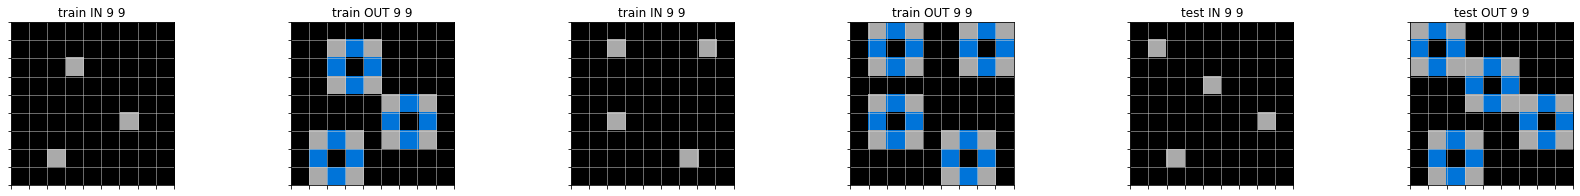

In [79]:
# task_id = 'd5d6de2d'
# task_id = 'd364b489'
# task_id = 'a48eeaf7'
# task_id = '22eb0ac0'
task_id = 'b60334d2'
# task_id = '496994bd'

plot_task(train_tasks[task_id])

In [80]:
task_rgb = get_task_imgs_rgb(train_tasks, task_id)

In [81]:
X, X_color, y = get_cnn_set_imgs(train_tasks[task_id]['train'], task_rgb['train'])

In [82]:
valid_perc = 0.15
n_valid = int(len(X) * valid_perc)
valid_idxs = np.random.choice(range(len(X)), size=n_valid, replace=False)
train_idxs = list(set(range(len(X))) - set(valid_idxs))

X_train, X_train_color, y_train = X[train_idxs], X_color[train_idxs], y[train_idxs]
X_valid, X_valid_color, y_valid = X[valid_idxs], X_color[valid_idxs], y[valid_idxs]

In [39]:
X_train, X_train_color, y_train = X, X_color, y

# CNN

In [13]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Concatenate, concatenate, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import keras

In [14]:
# Replace with the size of your images
IMG_SIZE = 9
# 3 for RGB images or 1 for grayscale images
NB_CHANNELS = 3
# Typical values are 8, 16 or 32
BATCH_SIZE = 4
# Replace with the total number training images
NB_TRAIN_IMG = len(X_train)
# Replace with the total number validation images
NB_VALID_IMG = len(X_valid)

## Current architecture

In [76]:
def get_model(img_size_x, img_size_y, n_channels):    
    model1_input = Input(shape=(img_size_x, img_size_y, n_channels))

    model1 = Conv2D(filters=8, 
                    kernel_size=(2,2), 
                    padding='same',
                    activation='relu',
                    kernel_regularizer=regularizers.l2(l=0.01),
                    input_shape=(IMG_SIZE, IMG_SIZE, NB_CHANNELS))(model1_input)
    model1 = MaxPooling2D(pool_size=(2,2),
                          strides=2)(model1)
    model1 = Conv2D(filters=16, 
                    kernel_size=(2,2), 
                    padding='same',
                    activation='relu',
                   kernel_regularizer=regularizers.l2(l=0.01))(model1)
    model1 = MaxPooling2D(pool_size=(2,2),
                          strides=2)(model1)


    # add color current square
    model2_input = Input(shape=NB_CHANNELS)
    model2 = Dense(8, activation='relu')(model2_input)
    model2 = Dense(16, activation='relu')(model2)
    model2 = Dense(32, activation='softmax')(model2)
    model2 = Reshape((2,2,8), input_shape=(32,))(model2)

    merged = concatenate([model1, model2])

    conv = Flatten()(merged)
    dense = Dense(64, activation='relu')(conv)
    dense = Dropout(0.25)(dense)
    output = Dense(10, activation='softmax')(dense)
    model = Model(inputs=[model1_input, model2_input], outputs=[output])
#     opt = SGD(learning_rate=0.001)
    opt = Adam(learning_rate=0.006)
    model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer=opt,
#                   optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [431]:
model1_input = Input(shape=(IMG_SIZE, IMG_SIZE, NB_CHANNELS))

model1 = Conv2D(filters=32, 
               kernel_size=(3,3), 
               strides=(1,1),
               padding='same',
               input_shape=(IMG_SIZE, IMG_SIZE, NB_CHANNELS),
               data_format='channels_last')(model1_input)
model1 = Activation('relu')(model1)
model1 = MaxPooling2D(pool_size=(2,2),
                     strides=2)(model1)
model1 = Conv2D(filters=64, 
               kernel_size=(3,3), 
               strides=(1,1),
               padding='valid')(model1)
model1 = Activation('relu')(model1)
model1 = MaxPooling2D(pool_size=(2,2),
                     strides=2)(model1)


# add color current square
model2_input = Input(shape=NB_CHANNELS)
model2 = Dense(8, activation='relu')(model2_input)
model2 = Dense(64, activation='softmax')(model2)
model2 = Reshape((1,1,64), input_shape=(64,))(model2)

# merged = Concatenate([model1.output, model2.output])
merged = concatenate([model1, model2])

conv = Flatten()(merged)
dense = Dense(64, activation='relu')(conv)
dense = Dropout(0.25)(dense)
output = Dense(10, activation='softmax')(dense)
model = Model(inputs=[model1_input, model2_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node conv2d_152/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_152/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,64], [2,2,64,64].

## Customs

In [307]:
model1 = Sequential()

model1.add(Conv2D(filters=32, 
               kernel_size=(3,3), 
               strides=(1,1),
               padding='same',
               input_shape=(IMG_SIZE, IMG_SIZE, NB_CHANNELS),
               data_format='channels_last'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))

model1.add(Conv2D(filters=64,
               kernel_size=(2,2),
               strides=(1,1),
               padding='valid'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))

# add color current square
model2 = Sequential()
# model2.add(Conv2D(filters=32, 
#                kernel_size=(2,2), 
#                strides=(1,1),
#                padding='same',
#                input_shape=(1, 1, 3),
#                data_format='channels_last'))
# model2.add(Activation('relu'))
# model2.add(MaxPooling2D(pool_size=(2,2),
#                      strides=2))

# model2.add(Conv2D(filters=64,
#                kernel_size=(2,2),
#                strides=(1,1),
#                padding='valid'))
# model2.add(Activation('relu'))
# model2.add(MaxPooling2D(pool_size=(2,2),
#                      strides=2))
model2.add(Input(3))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(256, activation='softmax'))
model2.add(Reshape((2,2,64), input_shape=(256,)))

merged = Concatenate([model1.output, model2.output])

model = Sequential()
model.add(merged)
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model = concatenate([model.output, model2.output])
# model = model.append(model2)

# conv = Flatten()(model)
# dense = Dense(64, activation='relu')(conv)
# dense = Dropout(0.25)(dense)
# output = Dense(10, activation='softmax')(dense)
# model = Model(inputs=[current_input, voltage_input], outputs=[output])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.add(Flatten())        
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(Dense(10))
# model.add(Activation('softmax'))
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## VGG

In [169]:
model = Sequential()
model.add(Conv2D(input_shape=(IMG_SIZE, IMG_SIZE, NB_CHANNELS),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=10, activation="softmax"))

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Generators

In [240]:
train_datagen = ImageDataGenerator(
#     rotation_range = 40,                  
#     width_shift_range = 0.2,                  
#     height_shift_range = 0.2,                  
#     rescale = 1./255,                  
    shear_range = 0.2,                  
#     zoom_range = 0.2,                     
    horizontal_flip = False)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train,
    y_train,
#     target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode='categorical',
    batch_size = BATCH_SIZE)

validation_generator = validation_datagen.flow(
    X_valid,
    y_valid,
#     target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode='categorical',
    batch_size = BATCH_SIZE)

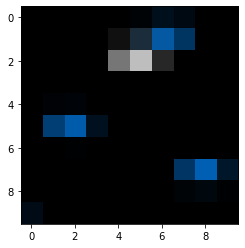

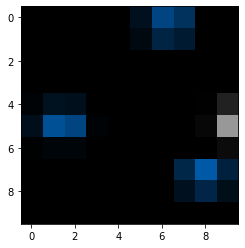

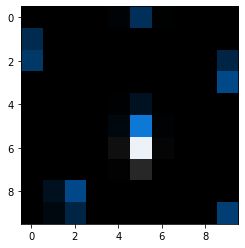

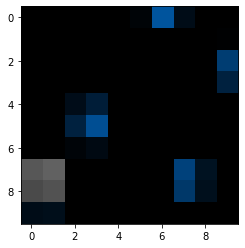

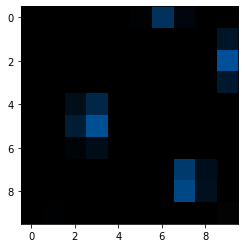

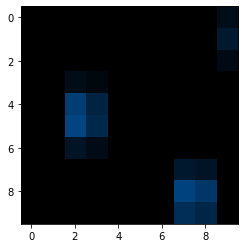

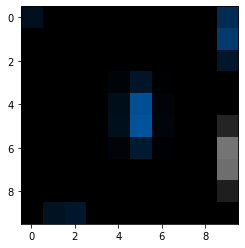

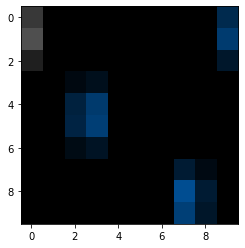

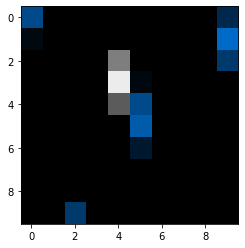

In [569]:
datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
it = datagen.flow(X_train, batch_size=1)
for i in range(9):
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plot_image(image)

# Train/Test

In [16]:
from sklearn.utils.class_weight import compute_class_weight

In [83]:
cw = compute_class_weight('balanced', np.unique(y_train), y_train)
cw = {clss: w for clss, w in zip(np.unique(y_train), cw)}
for i in range(10):
    if i not in cw:
        cw[i] = 0
cw

/home/ibci/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 5], y=[0 0 0 0 0 0 0 0 0 5 5 0 0 0 0 1 1 0 0 0 0 0 0 5 1 5 0 0 0 0 0 0 5 1 5 0 0
 0 0 0 0 1 0 1 0 5 0 5 1 5 0 1 0 1 0 0 0 0 0 5 1 5 0 0 0 0 0 5 1 5 0 5 1 5
 0 1 0 1 0 0 1 0 0 5 1 5 0 0 5 1 5 0 0 0 0 0 0 0 0 0 0 5 1 5 0 0 0 0 0 1 0
 1 0 0 0 0 5 1 5 0 5 1 5 0 0 0 1 0 1 0 0 0 0 0 0 5 1 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.5348837209302325,
 1: 1.84,
 5: 1.7037037037037037,
 2: 0,
 3: 0,
 4: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0}

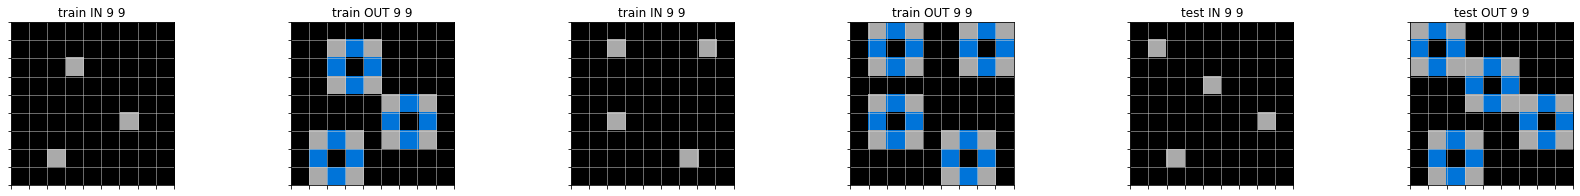

In [84]:
plot_task(train_tasks[task_id])

In [87]:
model = get_model(img_size_x=9, img_size_y=9, n_channels=3)

100
Loss: 1.179638147354126
Val loss: 1.1270579099655151


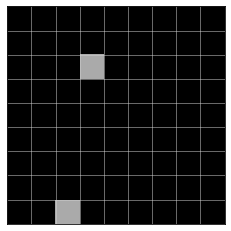

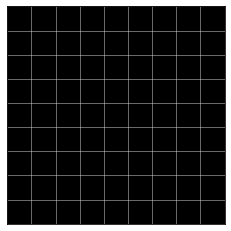

200
Loss: 1.149139404296875
Val loss: 1.8916950225830078


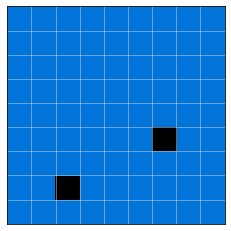

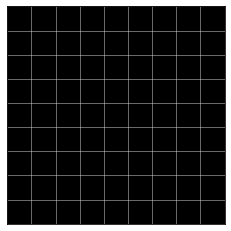

300
Loss: 0.8557698130607605
Val loss: 0.9456625580787659


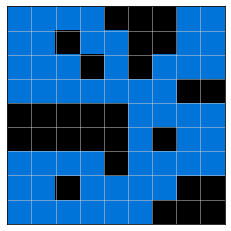

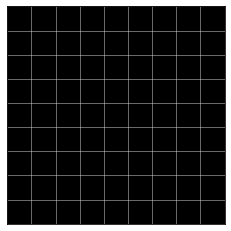

400
Loss: 0.6244196891784668
Val loss: 0.4623335301876068


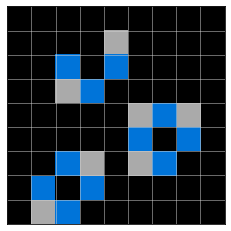

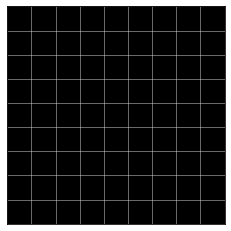

500
Loss: 0.4108324348926544
Val loss: 0.47685614228248596


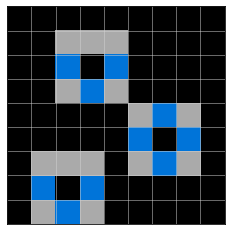

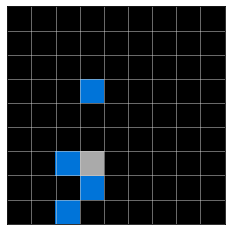

600
Loss: 0.25517648458480835
Val loss: 0.5378697514533997


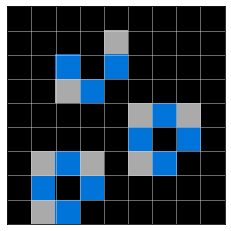

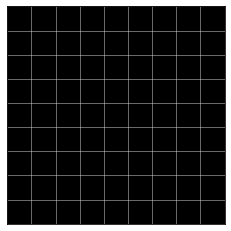

700
Loss: 0.19334851205348969
Val loss: 0.8034244179725647


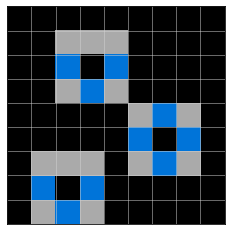

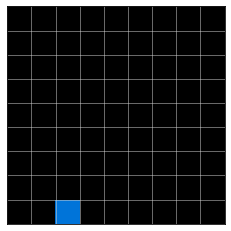

800
Loss: 0.3587418794631958
Val loss: 0.508614718914032


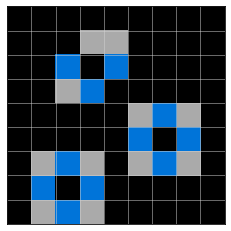

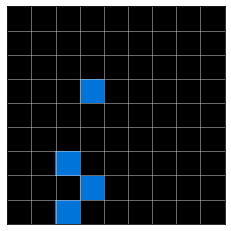

900
Loss: 0.16392464935779572
Val loss: 0.5072592496871948


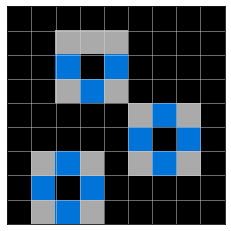

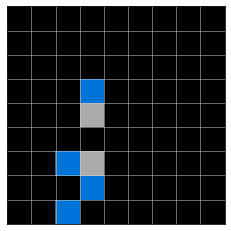

1000
Loss: 0.12072130292654037
Val loss: 0.4650741517543793


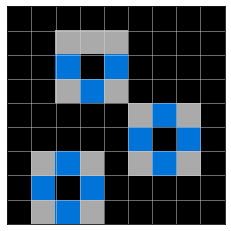

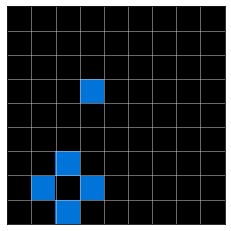

1100
Loss: 0.11292300373315811
Val loss: 0.6390337944030762


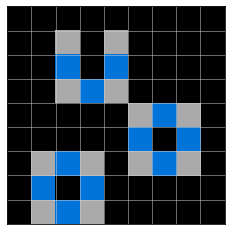

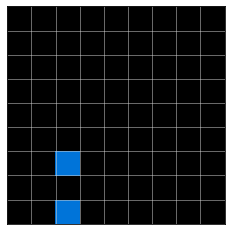

1200
Loss: 0.11004795134067535
Val loss: 0.5758997797966003


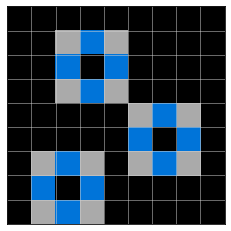

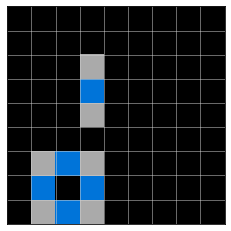

1300
Loss: 0.10320992767810822
Val loss: 0.48174288868904114


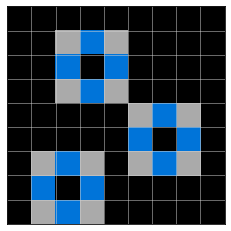

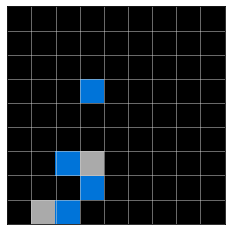

1400
Loss: 0.19422870874404907
Val loss: 0.5225287079811096


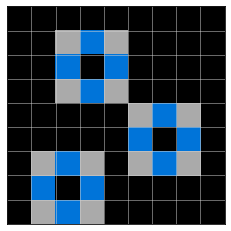

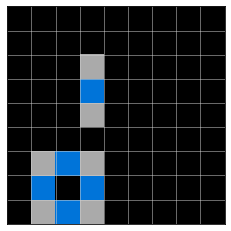

1500
Loss: 2.077446699142456
Val loss: 0.32183122634887695


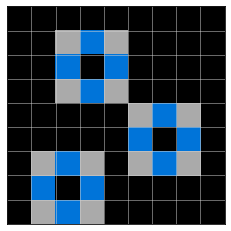

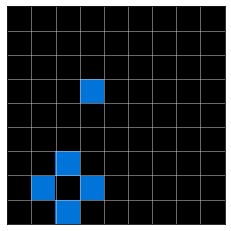

1600
Loss: 0.08654818683862686
Val loss: 0.2859393060207367


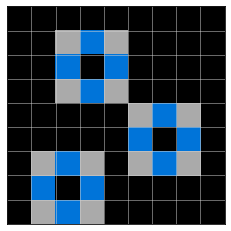

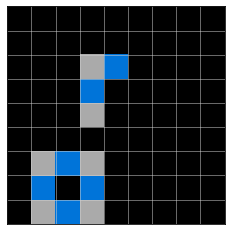

1700
Loss: 0.07803348451852798
Val loss: 0.45625364780426025


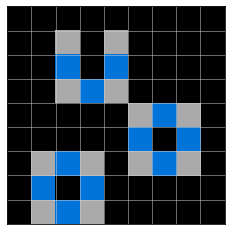

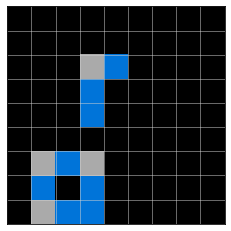

1800
Loss: 0.10430178791284561
Val loss: 0.2711966037750244


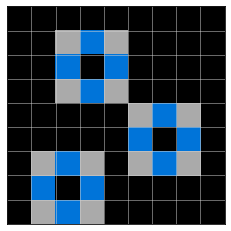

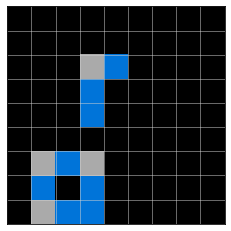

1900
Loss: 0.07921631634235382
Val loss: 0.4265056550502777


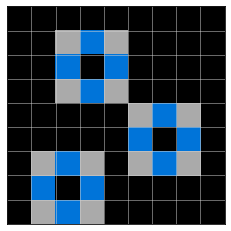

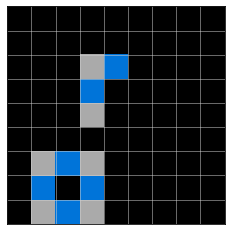

2000
Loss: 0.5477522611618042
Val loss: 0.27933216094970703


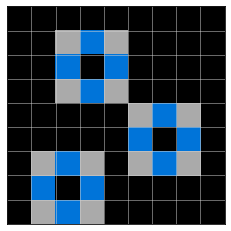

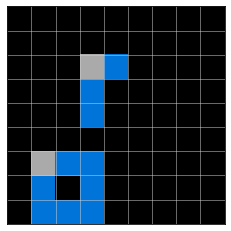

2100
Loss: 0.07172228395938873
Val loss: 0.49080243706703186


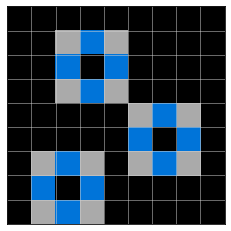

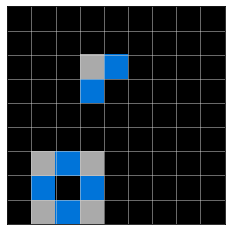

2200
Loss: 0.07321391254663467
Val loss: 0.42483410239219666


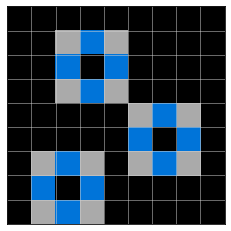

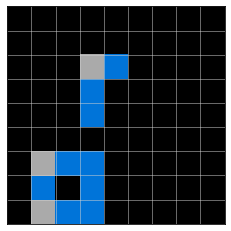

2300
Loss: 0.08336760848760605
Val loss: 4.9051833152771


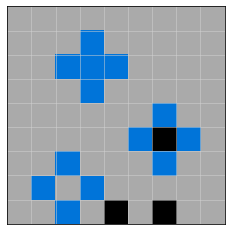

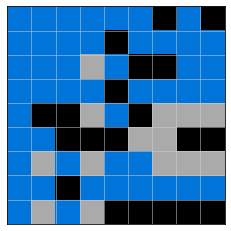

2400
Loss: 0.0979284942150116
Val loss: 0.34676817059516907


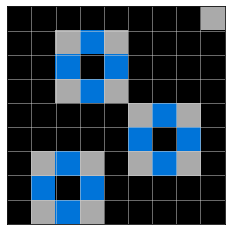

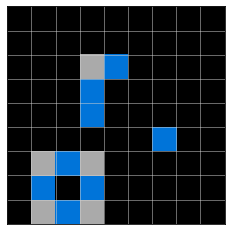

2500
Loss: 0.0963452011346817
Val loss: 0.44907984137535095


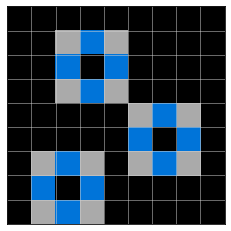

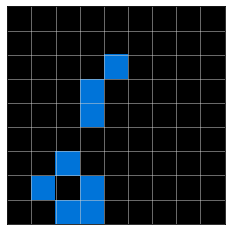

2600
Loss: 0.06916657090187073
Val loss: 0.5331183075904846


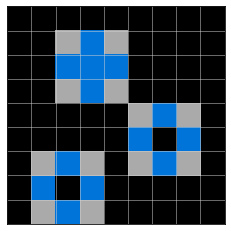

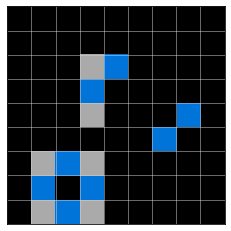

2700
Loss: 0.13493700325489044
Val loss: 0.7556629180908203


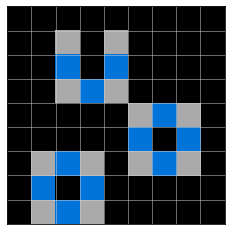

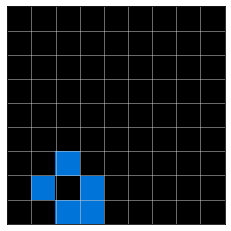

2800
Loss: 0.07438914477825165
Val loss: 0.6178821325302124


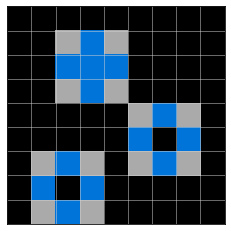

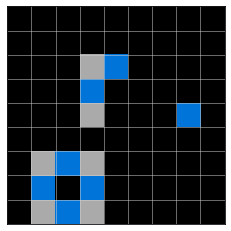

2900
Loss: 0.10295790433883667
Val loss: 0.7125118374824524


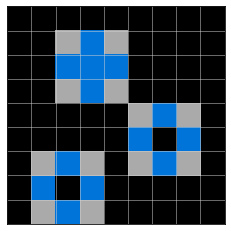

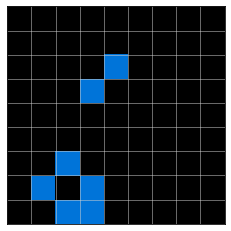

3000
Loss: 0.06674741953611374
Val loss: 0.47485408186912537


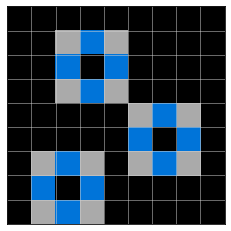

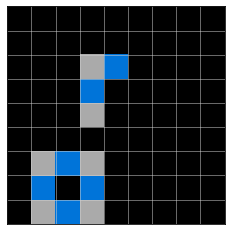

3100
Loss: 0.0660664513707161
Val loss: 0.6553626656532288


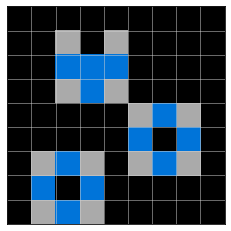

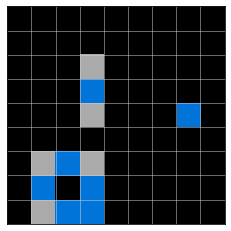

3200
Loss: 0.07673955708742142
Val loss: 0.45487937331199646


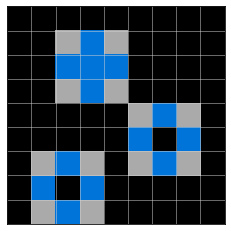

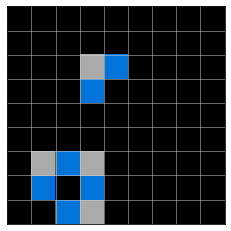

3300
Loss: 0.0635114535689354
Val loss: 0.5920191407203674


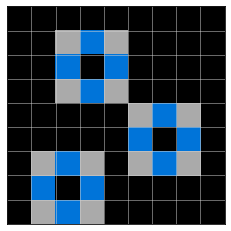

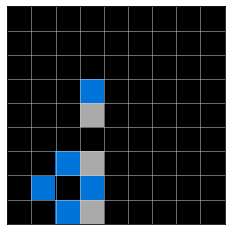

3400
Loss: 0.07220672070980072
Val loss: 0.9229531288146973


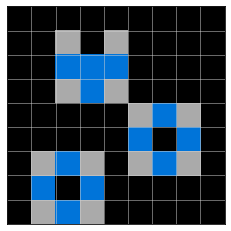

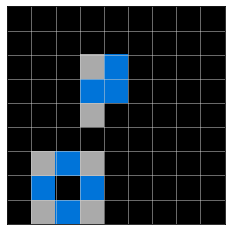

3500
Loss: 0.06499264389276505
Val loss: 0.4638262987136841


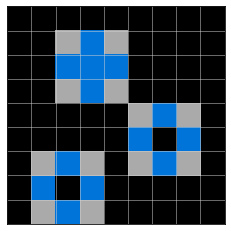

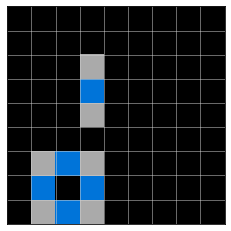

3600
Loss: 0.28609663248062134
Val loss: 0.774287223815918


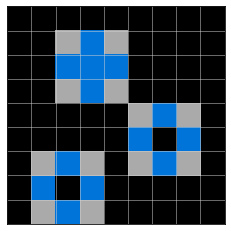

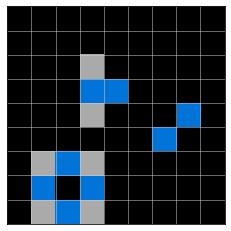

3700
Loss: 0.5193966031074524
Val loss: 0.5223782658576965


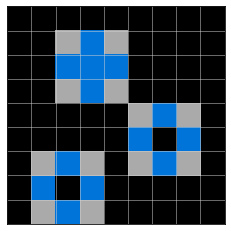

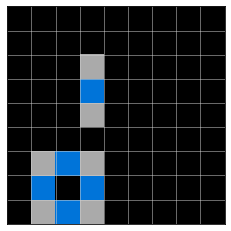

3800
Loss: 0.7954820394515991
Val loss: 0.9324230551719666


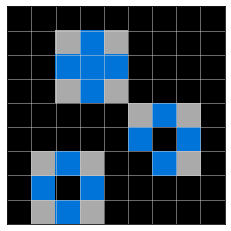

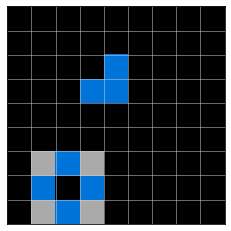

3900
Loss: 0.09074033796787262
Val loss: 0.7340192198753357


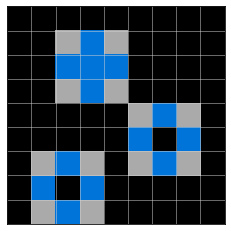

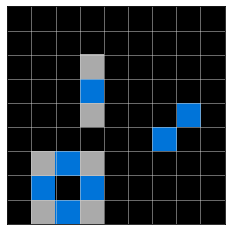

4000
Loss: 0.7270447611808777
Val loss: 1.7658709287643433


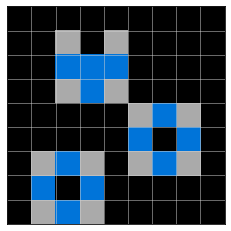

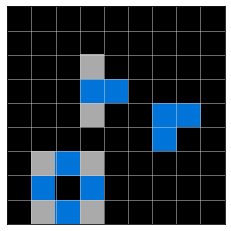

4100
Loss: 5.040890693664551
Val loss: 1.2217788696289062


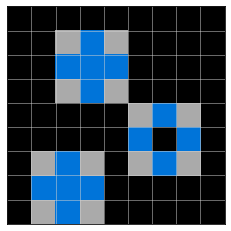

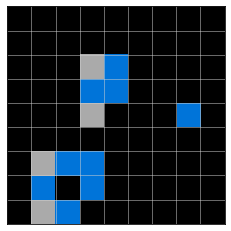

4200
Loss: 0.0751732811331749
Val loss: 1.0305523872375488


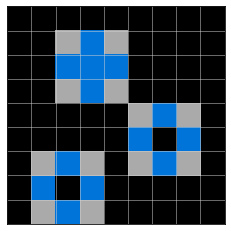

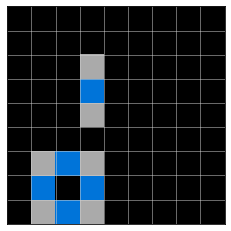

4300
Loss: 0.07173299044370651
Val loss: 1.3632240295410156


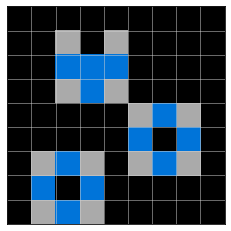

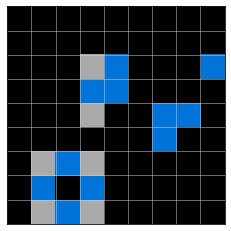

4400
Loss: 0.07366903871297836
Val loss: 1.287693738937378


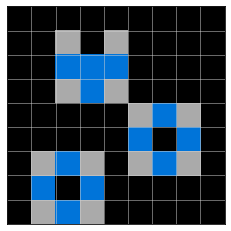

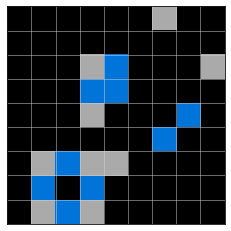

4500
Loss: 0.07758688926696777
Val loss: 1.2346895933151245


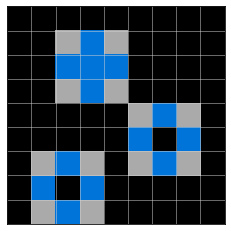

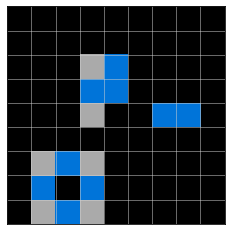

4600
Loss: 0.13345201313495636
Val loss: 1.1552690267562866


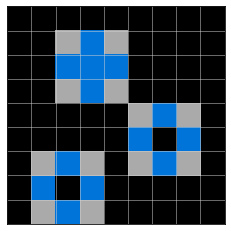

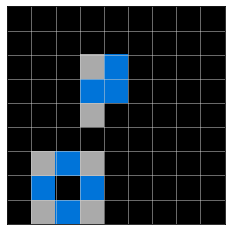

4700
Loss: 0.06541898101568222
Val loss: 1.3651336431503296


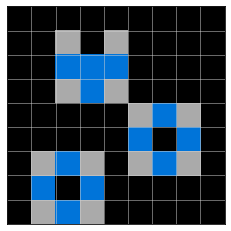

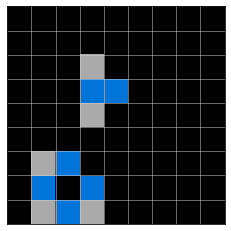

4800
Loss: 0.12116454541683197
Val loss: 1.1173112392425537


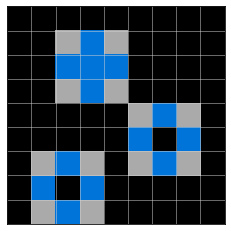

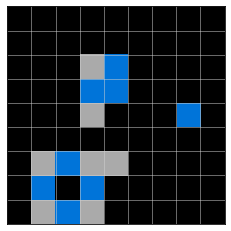

4900
Loss: 0.1013772189617157
Val loss: 1.0536731481552124


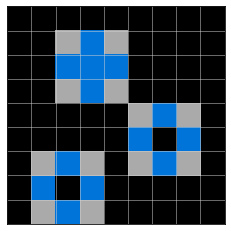

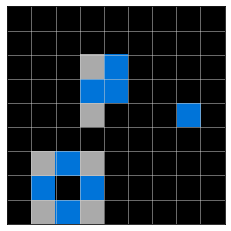

5000
Loss: 0.06414541602134705
Val loss: 1.295603632926941


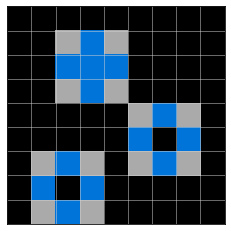

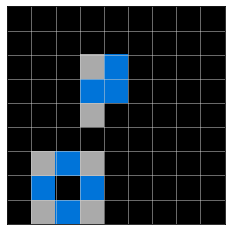

5100
Loss: 0.06270261853933334
Val loss: 0.7063198685646057


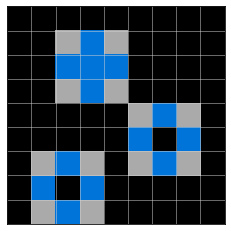

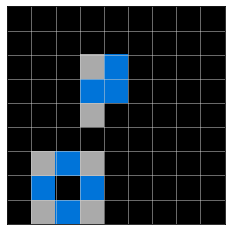

5200
Loss: 0.06544137001037598
Val loss: 1.2114088535308838


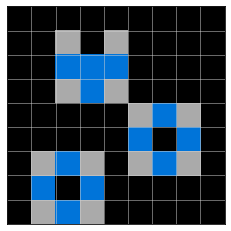

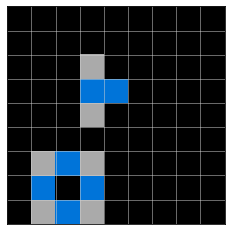

5300
Loss: 0.06341318786144257
Val loss: 1.0783768892288208


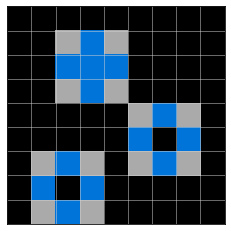

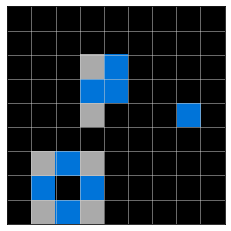

5400
Loss: 0.0710136890411377
Val loss: 1.0290521383285522


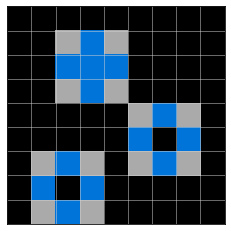

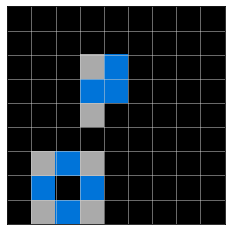

5500
Loss: 0.0632452443242073
Val loss: 1.9764460325241089


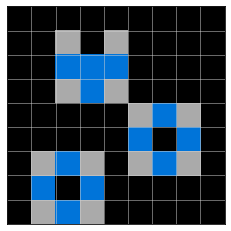

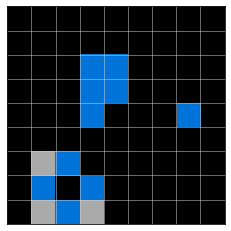

5600
Loss: 0.06697012484073639
Val loss: 1.5794378519058228


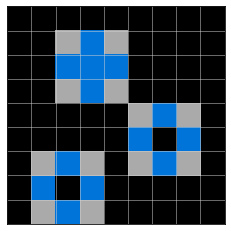

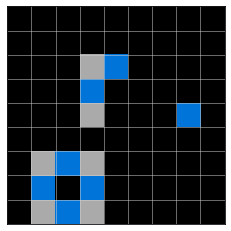

5700
Loss: 0.06375318765640259
Val loss: 1.2394541501998901


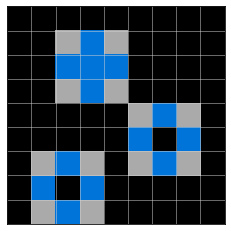

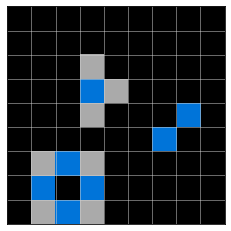

5800
Loss: 0.10669025778770447
Val loss: 1.6265602111816406


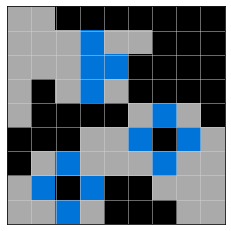

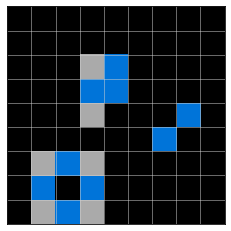

5900
Loss: 0.10362992435693741
Val loss: 1.792832851409912


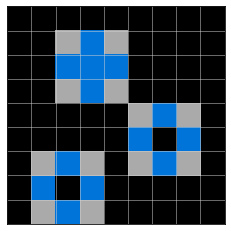

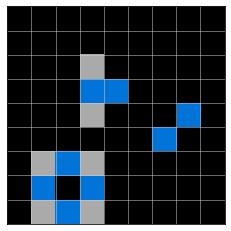

6000
Loss: 0.10061630606651306
Val loss: 1.8819122314453125


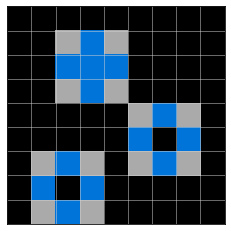

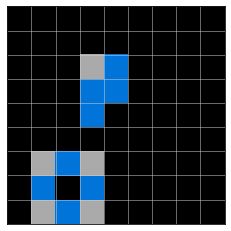

6100
Loss: 0.133513405919075
Val loss: 1.9849363565444946


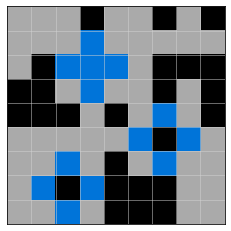

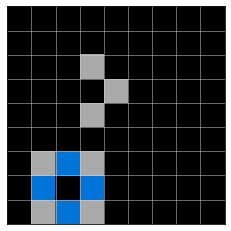

6200
Loss: 0.17941680550575256
Val loss: 1.4985824823379517


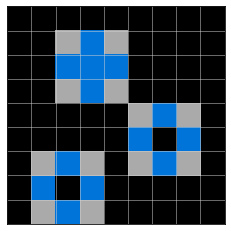

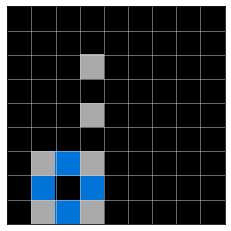

6300
Loss: 0.13062942028045654
Val loss: 2.1565496921539307


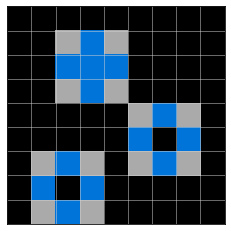

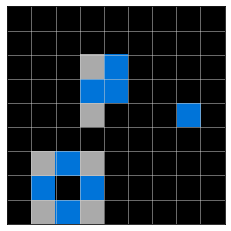

6400
Loss: 0.09401265531778336
Val loss: 1.5896612405776978


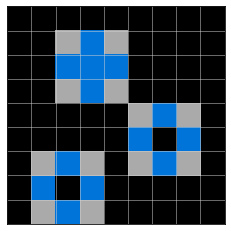

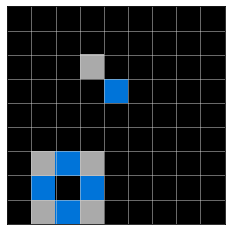

6500
Loss: 0.4282207787036896
Val loss: 1.5394682884216309


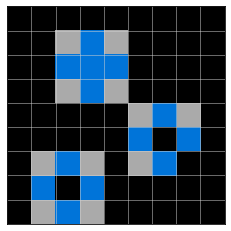

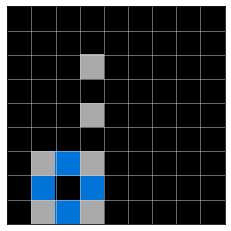

6600
Loss: 0.14560899138450623
Val loss: 2.7336795330047607


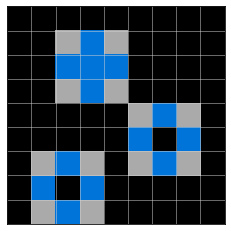

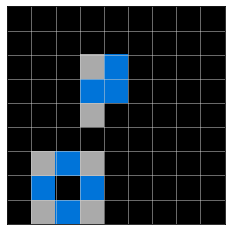

6700
Loss: 0.582115650177002
Val loss: 2.555858850479126


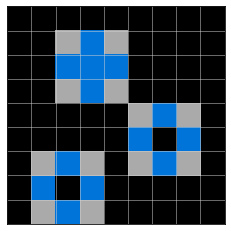

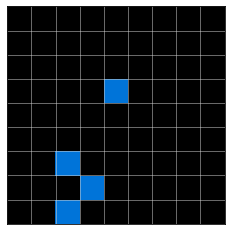

6800
Loss: 0.07340900599956512
Val loss: 2.739579916000366


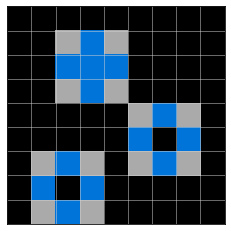

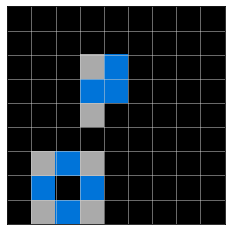

6900
Loss: 0.09659478068351746
Val loss: 3.425884246826172


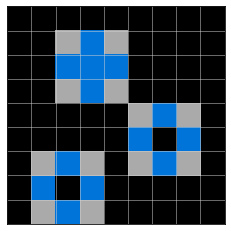

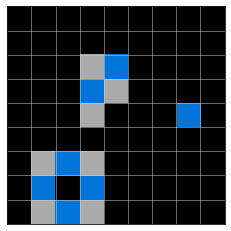

7000
Loss: 0.07765750586986542
Val loss: 3.356947660446167


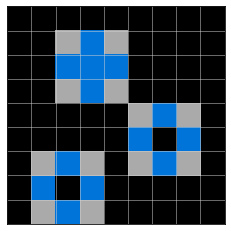

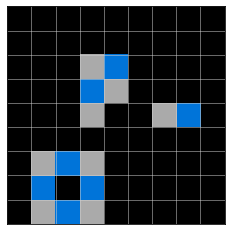

7100
Loss: 0.07555786520242691
Val loss: 2.4021949768066406


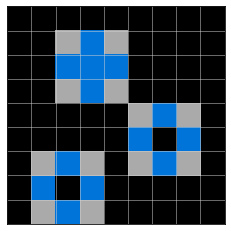

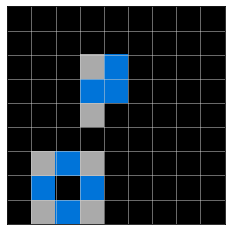

7200
Loss: 0.12330552935600281
Val loss: 2.569084405899048


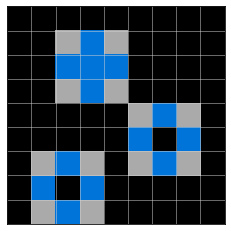

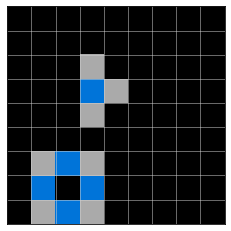

7300
Loss: 0.07007850706577301
Val loss: 2.4648194313049316


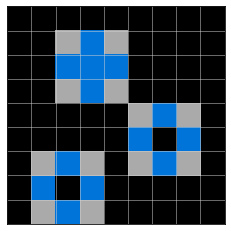

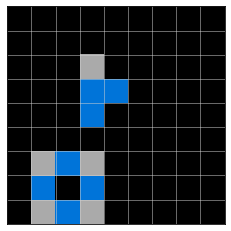

7400
Loss: 0.08547820150852203
Val loss: 2.834092140197754


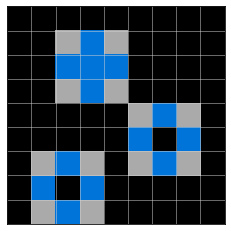

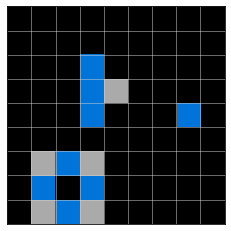

7500
Loss: 0.10090349614620209
Val loss: 2.6955010890960693


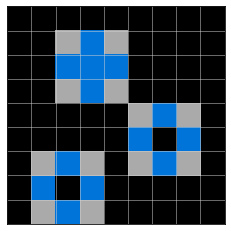

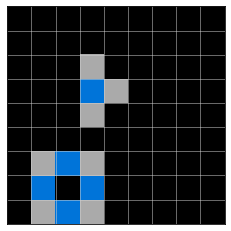

7600
Loss: 0.13876572251319885
Val loss: 3.0436840057373047


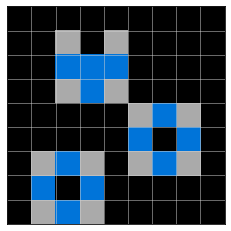

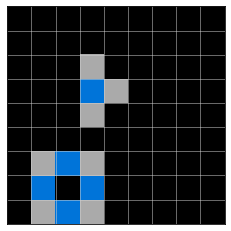

7700
Loss: 0.10592291504144669
Val loss: 3.004818916320801


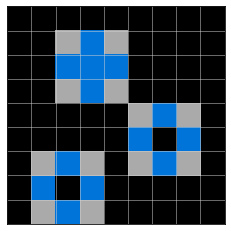

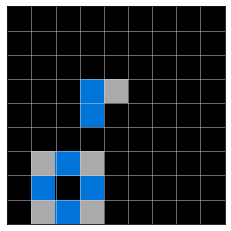

7800
Loss: 0.10049271583557129
Val loss: 2.730431318283081


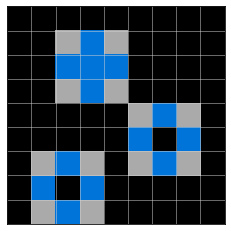

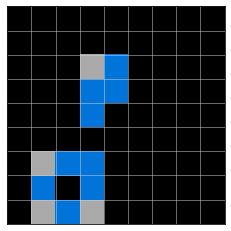

7900
Loss: 0.15136346220970154
Val loss: 2.846069097518921


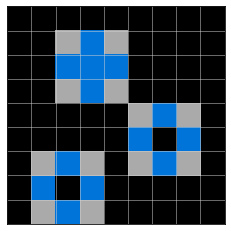

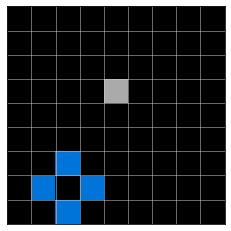

8000
Loss: 0.07086272537708282
Val loss: 3.044888496398926


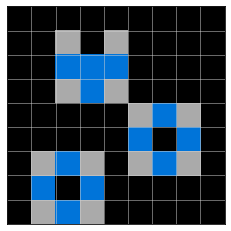

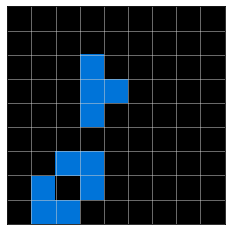

8100
Loss: 0.2786272168159485
Val loss: 3.0342562198638916


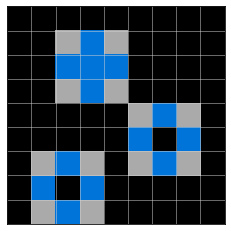

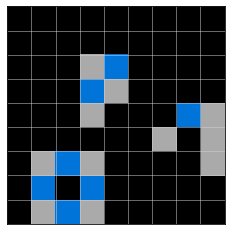

8200
Loss: 0.08339208364486694
Val loss: 3.057999610900879


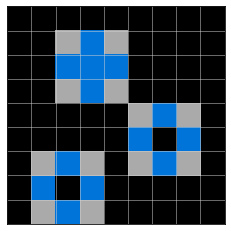

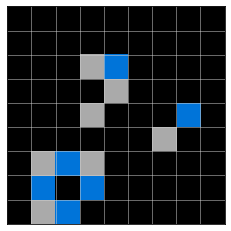

8300
Loss: 0.19363534450531006
Val loss: 2.3612382411956787


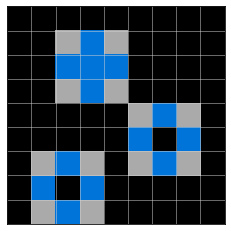

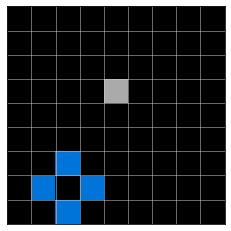

8400
Loss: 0.08212637901306152
Val loss: 3.124424695968628


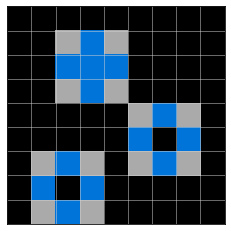

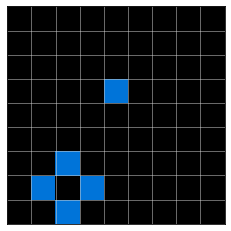

8500
Loss: 0.07400541752576828
Val loss: 3.323962450027466


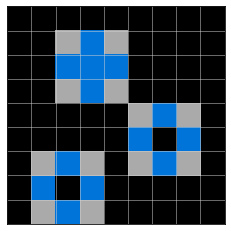

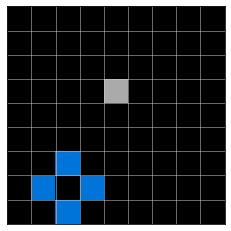

8600
Loss: 1.9367434978485107
Val loss: 4.333287715911865


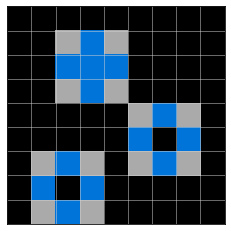

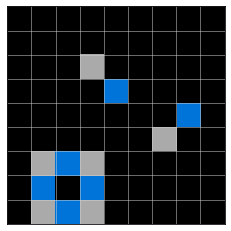

8700
Loss: 0.10723854601383209
Val loss: 3.539191484451294


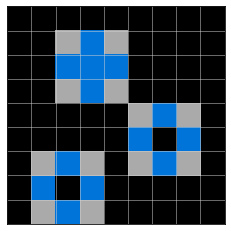

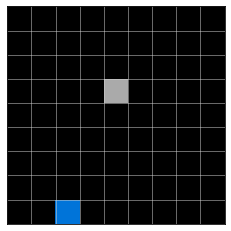

8800
Loss: 0.0768844410777092
Val loss: 3.720510721206665


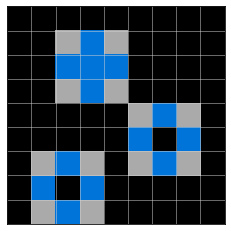

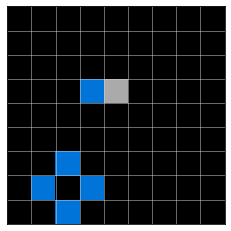

8900
Loss: 0.07445085048675537
Val loss: 2.7749130725860596


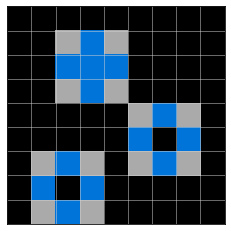

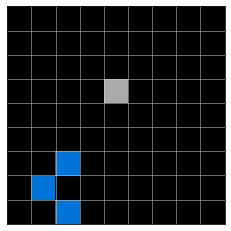

9000
Loss: 0.10014978796243668
Val loss: 3.7503483295440674


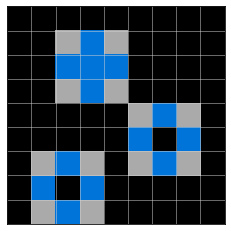

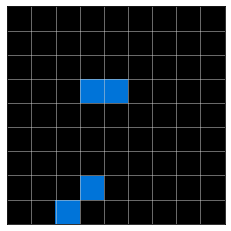

9100
Loss: 0.08604492992162704
Val loss: 2.9561855792999268


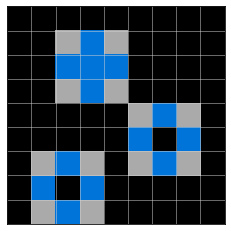

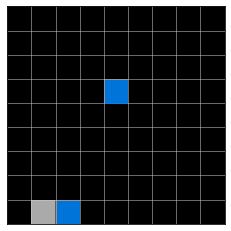

9200
Loss: 0.07330703735351562
Val loss: 4.448116302490234


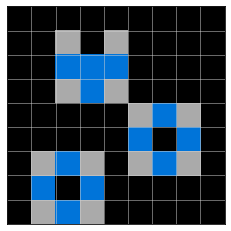

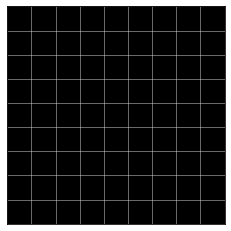

9300
Loss: 0.09708921611309052
Val loss: 3.46325421333313


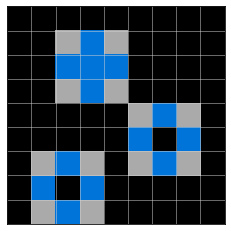

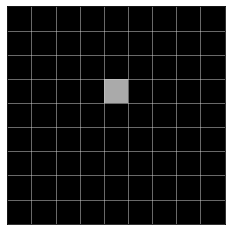

9400
Loss: 0.07071556150913239
Val loss: 4.2360639572143555


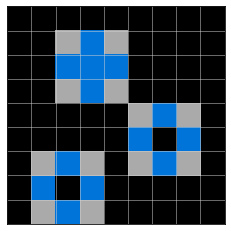

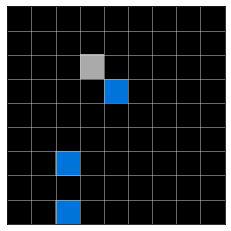

9500
Loss: 0.07730807363986969
Val loss: 4.567762851715088


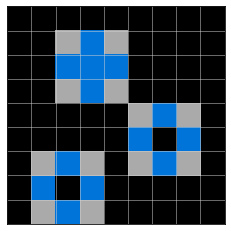

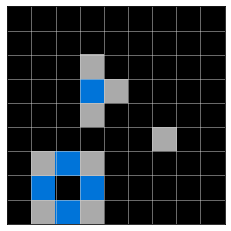

9600
Loss: 0.11325965076684952
Val loss: 4.323343753814697


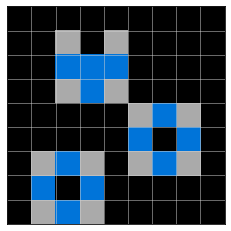

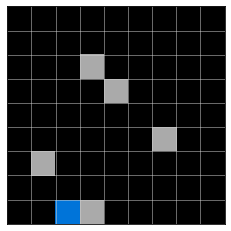

9700
Loss: 0.440288782119751
Val loss: 3.284478187561035


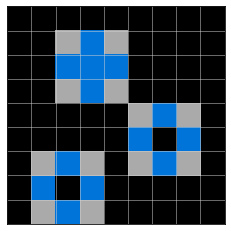

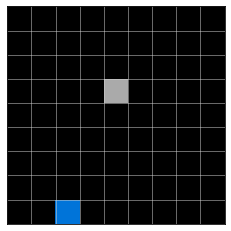

9800
Loss: 0.0806245282292366
Val loss: 4.165459632873535


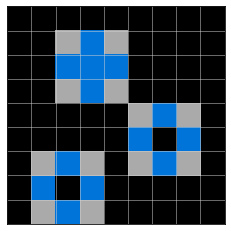

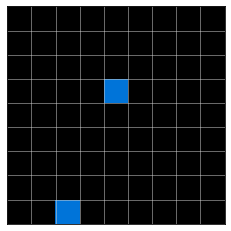

9900
Loss: 0.1303395926952362
Val loss: 3.744004011154175


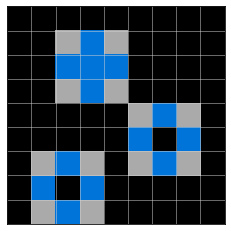

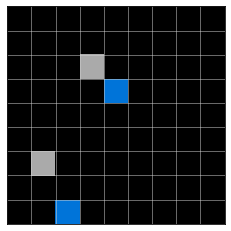

10000
Loss: 0.07816168665885925
Val loss: 3.896850824356079


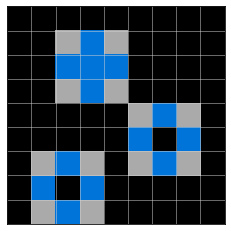

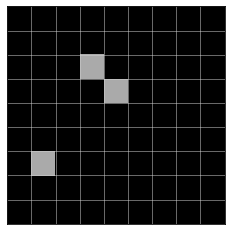

10100
Loss: 0.20089738070964813
Val loss: 2.818535566329956


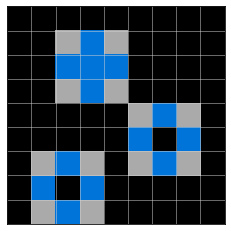

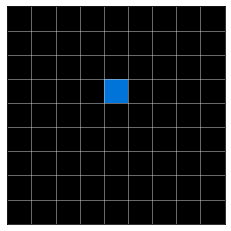

10200
Loss: 0.089329794049263
Val loss: 2.3532519340515137


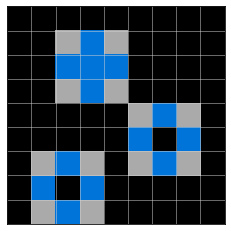

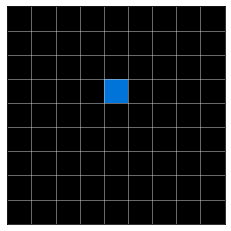

10300
Loss: 0.07506001740694046
Val loss: 1.5542893409729004


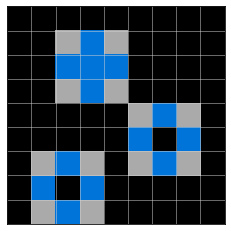

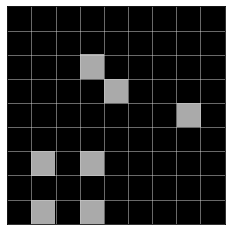

10400
Loss: 0.08551175892353058
Val loss: 3.1418869495391846


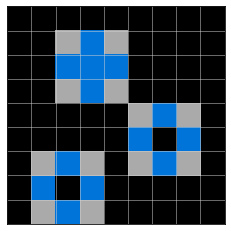

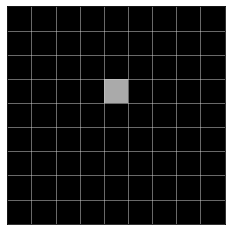

10500
Loss: 0.07568942755460739
Val loss: 2.0729644298553467


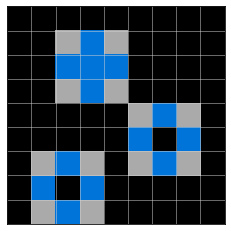

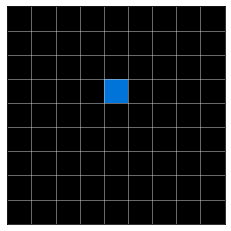

10600
Loss: 0.07180104404687881
Val loss: 4.365070819854736


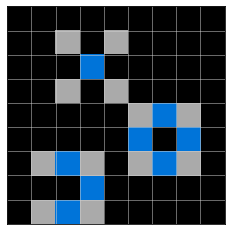

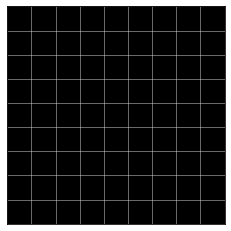

10700
Loss: 0.08422704041004181
Val loss: 0.8221921324729919


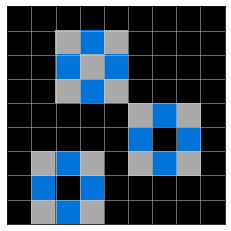

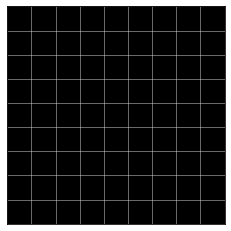

10800
Loss: 0.06913094222545624
Val loss: 1.8818608522415161


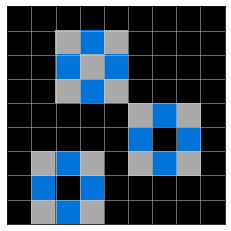

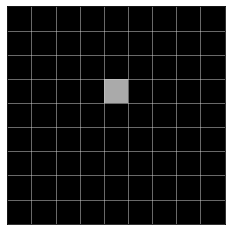

10900
Loss: 0.11006529629230499
Val loss: 2.5503897666931152


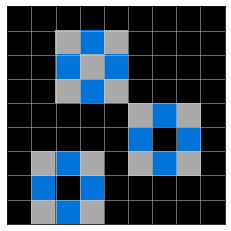

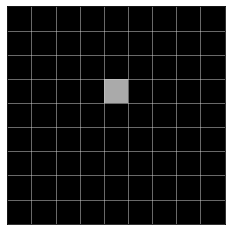

11000
Loss: 0.07465974241495132
Val loss: 2.7954776287078857


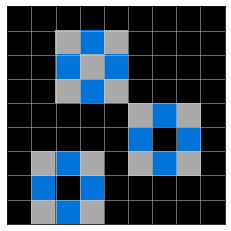

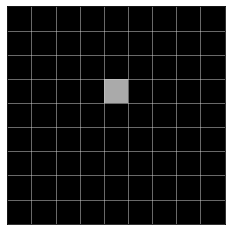

11100
Loss: 0.07582949101924896
Val loss: 2.2829482555389404


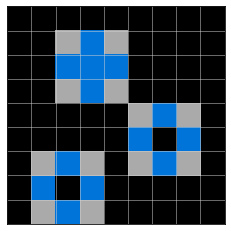

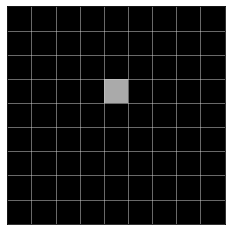

11200
Loss: 0.08702721446752548
Val loss: 1.6431946754455566


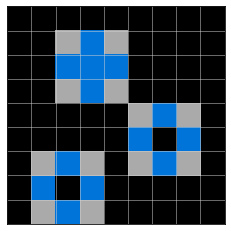

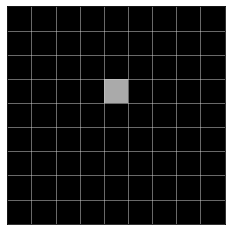

11300
Loss: 0.10182324796915054
Val loss: 2.657952070236206


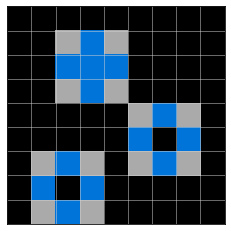

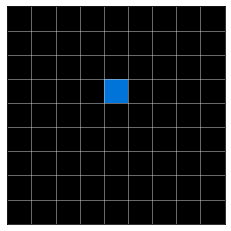

11400
Loss: 0.06646778434515
Val loss: 2.2827956676483154


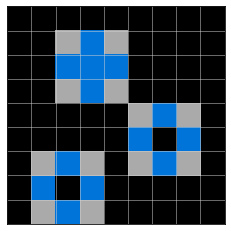

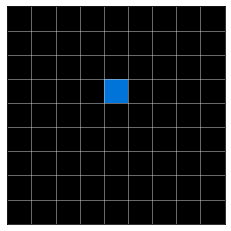

11500
Loss: 0.12272954732179642
Val loss: 1.5105260610580444


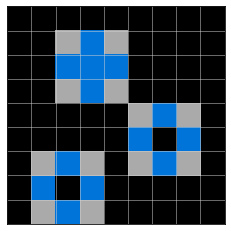

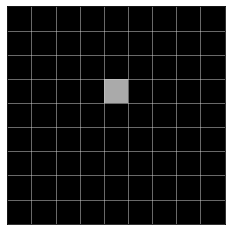

11600
Loss: 0.10226354002952576
Val loss: 1.7628048658370972


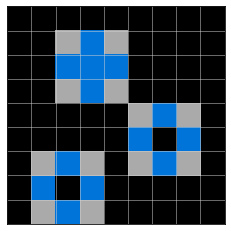

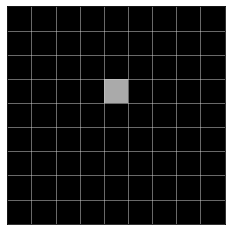

11700
Loss: 0.6511756777763367
Val loss: 1.7895541191101074


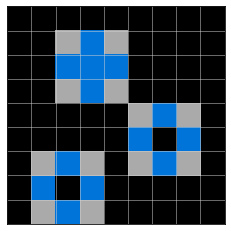

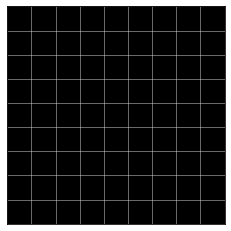

11800
Loss: 0.0746069848537445
Val loss: 2.809555768966675


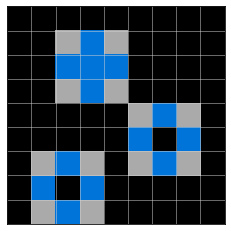

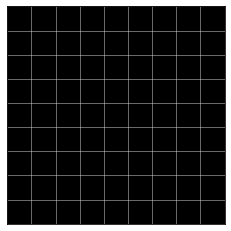

11900
Loss: 0.11038555949926376
Val loss: 2.2738895416259766


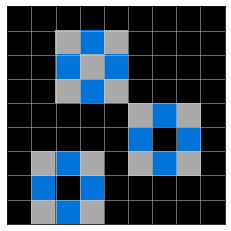

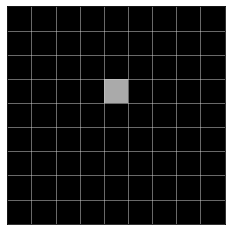

12000
Loss: 0.07630539685487747
Val loss: 1.3871402740478516


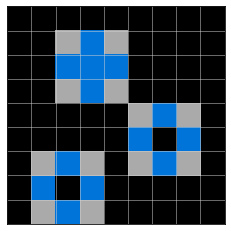

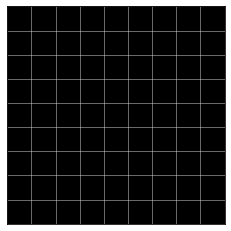

12100
Loss: 0.06948983669281006
Val loss: 1.6140323877334595


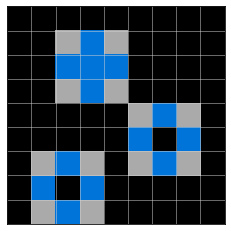

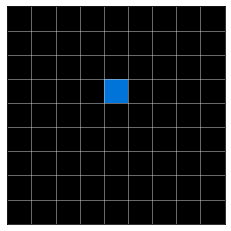

12200
Loss: 0.1291963756084442
Val loss: 0.8049618601799011


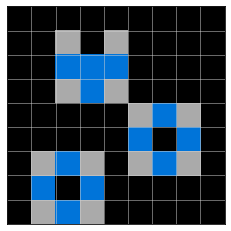

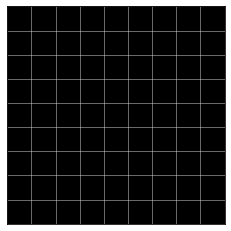

12300
Loss: 0.068014957010746
Val loss: 1.8195137977600098


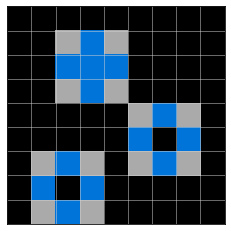

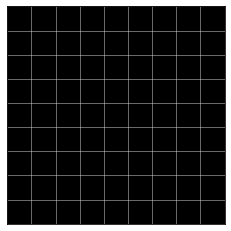

12400
Loss: 0.09868326038122177
Val loss: 1.9917864799499512


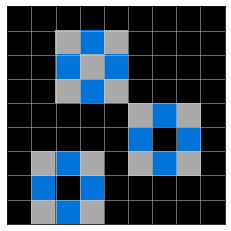

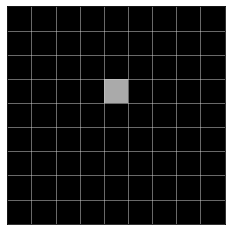

12500
Loss: 0.0621560774743557
Val loss: 1.992317795753479


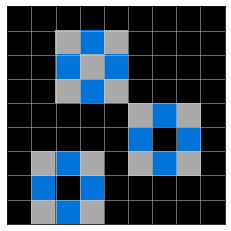

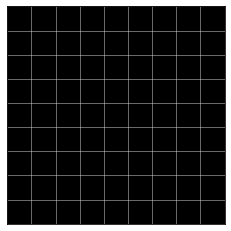

12600
Loss: 0.062094032764434814
Val loss: 1.2678687572479248


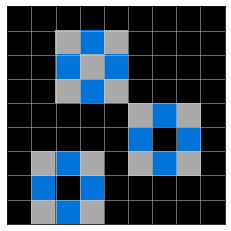

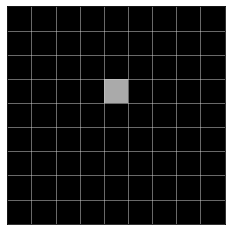

12700
Loss: 0.1861519068479538
Val loss: 0.9969028830528259


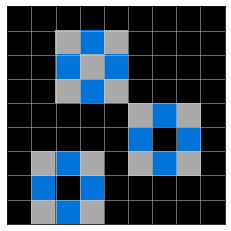

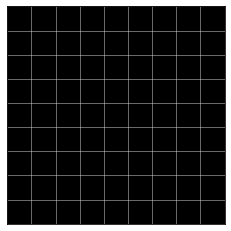

12800
Loss: 0.1708059012889862
Val loss: 1.782727599143982


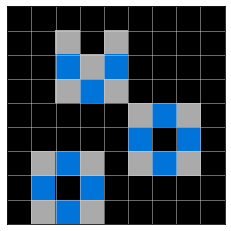

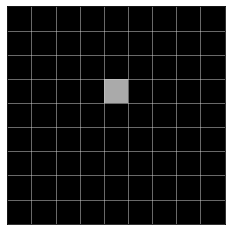

12900
Loss: 0.1399497091770172
Val loss: 0.739981472492218


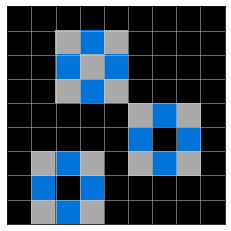

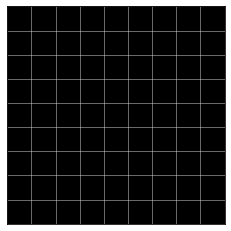

13000
Loss: 0.3577747941017151
Val loss: 2.6309542655944824


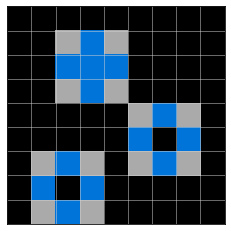

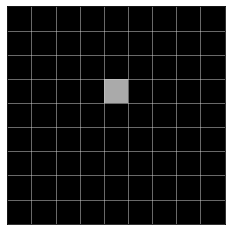

13100
Loss: 0.07201209664344788
Val loss: 2.356142282485962


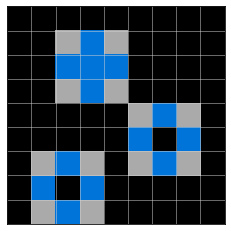

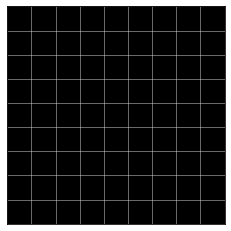

13200
Loss: 0.22708623111248016
Val loss: 1.0299805402755737


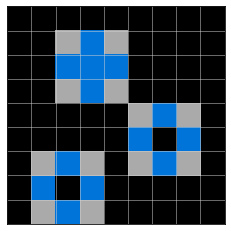

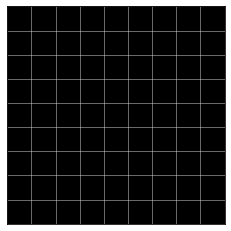

13300
Loss: 0.05787903070449829
Val loss: 1.790305256843567


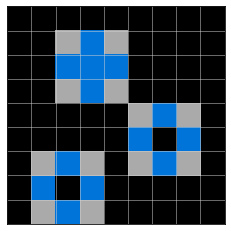

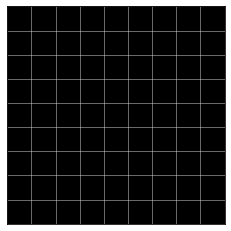

13400
Loss: 0.06334254890680313
Val loss: 3.2318923473358154


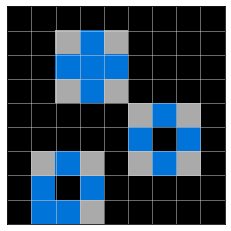

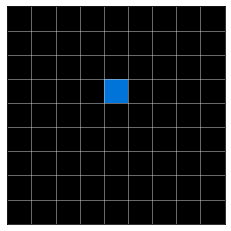

13500
Loss: 0.11352516710758209
Val loss: 1.446958065032959


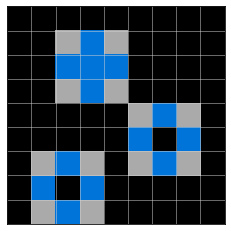

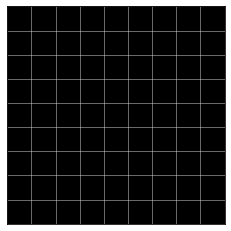

13600
Loss: 0.0604829303920269
Val loss: 1.2346268892288208


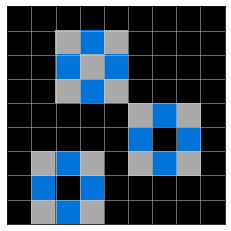

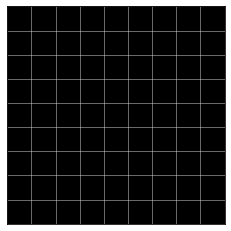

13700
Loss: 0.06853135675191879
Val loss: 2.6460835933685303


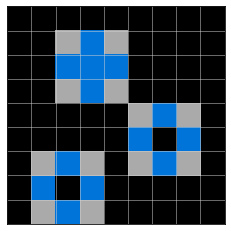

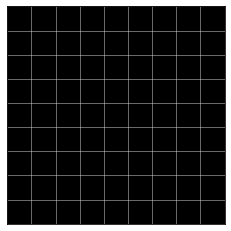

13800
Loss: 0.061783622950315475
Val loss: 1.6095695495605469


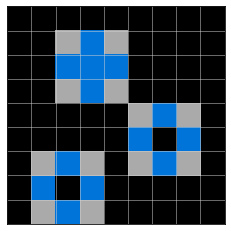

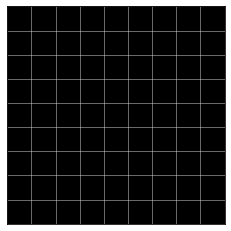

13900
Loss: 0.05825257673859596
Val loss: 1.712804913520813


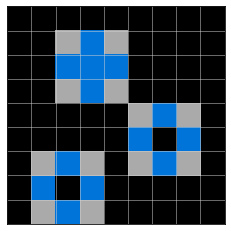

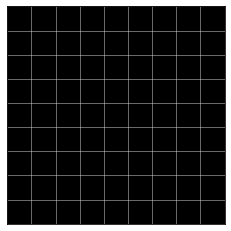

14000
Loss: 0.06060057878494263
Val loss: 0.6925390362739563


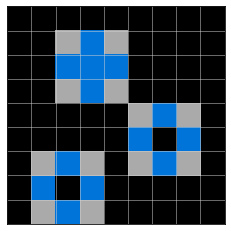

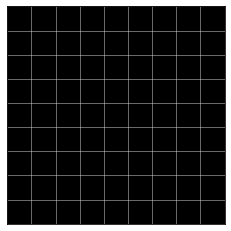

14100
Loss: 0.23560404777526855
Val loss: 1.740073561668396


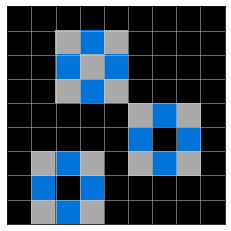

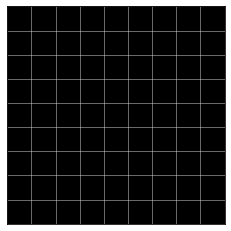

14200
Loss: 0.11349731683731079
Val loss: 1.391066074371338


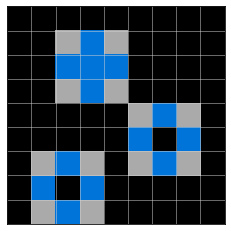

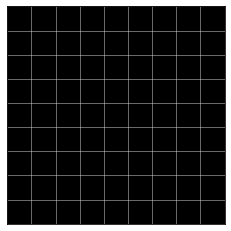

14300
Loss: 0.7854061126708984
Val loss: 2.1719424724578857


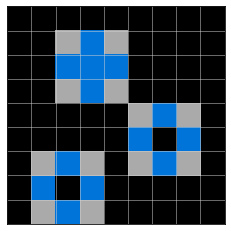

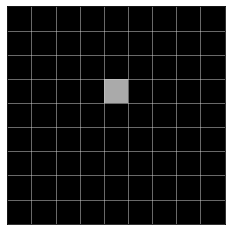

14400
Loss: 1.3156973123550415
Val loss: 0.7468281388282776


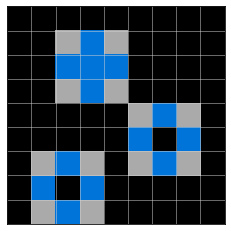

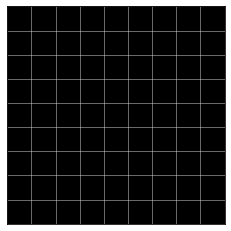

14500
Loss: 0.06371886283159256
Val loss: 2.35562801361084


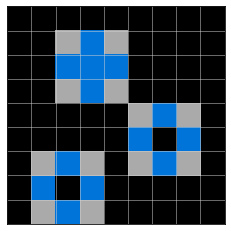

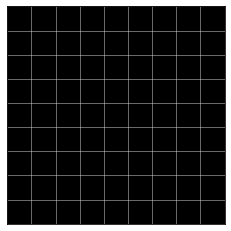

14600
Loss: 0.07103059440851212
Val loss: 2.3847737312316895


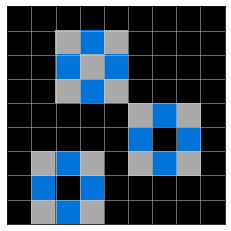

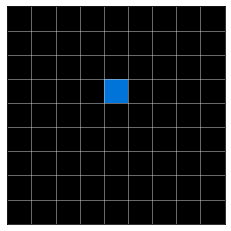

14700
Loss: 0.13630370795726776
Val loss: 1.7714637517929077


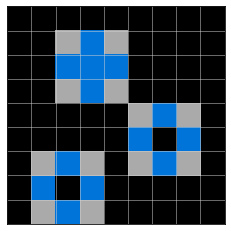

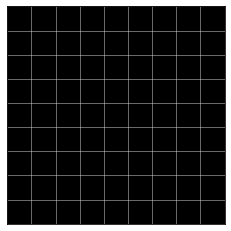

14800
Loss: 0.19736963510513306
Val loss: 2.995964288711548


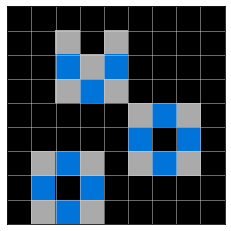

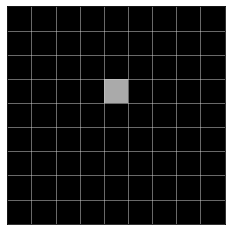

14900
Loss: 1.6483155488967896
Val loss: 1.4977840185165405


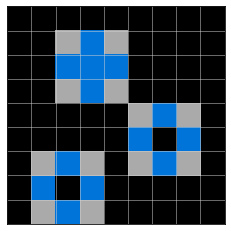

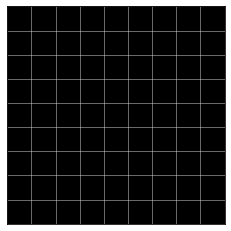

15000
Loss: 0.16546578705310822
Val loss: 1.124847173690796


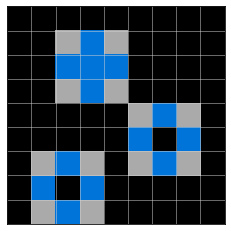

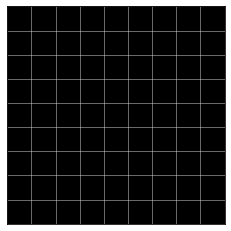

15100
Loss: 0.06277830898761749
Val loss: 1.3769499063491821


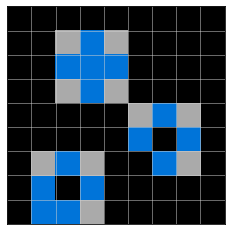

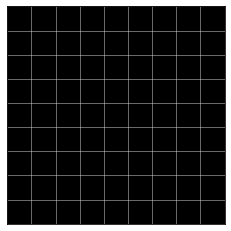

15200
Loss: 0.06549417227506638
Val loss: 1.4687477350234985


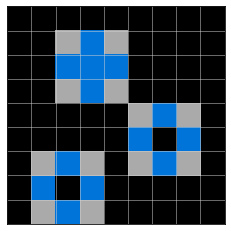

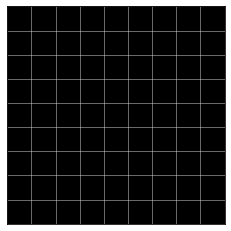

15300
Loss: 0.06697465479373932
Val loss: 0.7515365481376648


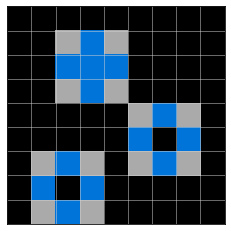

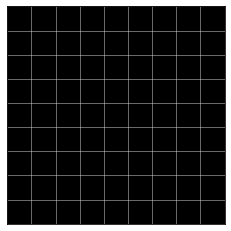

15400
Loss: 0.05744900181889534
Val loss: 0.25313836336135864


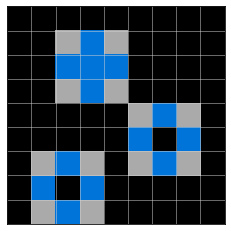

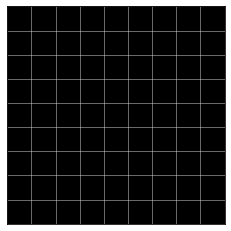

15500
Loss: 0.3697986304759979
Val loss: 2.0461549758911133


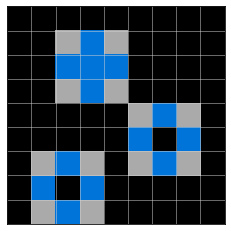

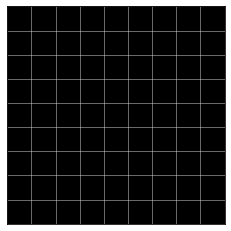

15600
Loss: 0.14431579411029816
Val loss: 1.2298455238342285


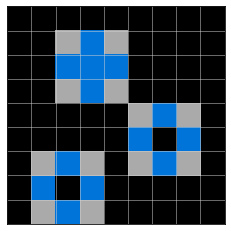

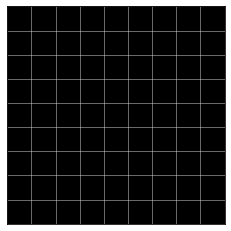

15700
Loss: 0.059558093547821045
Val loss: 2.441915273666382


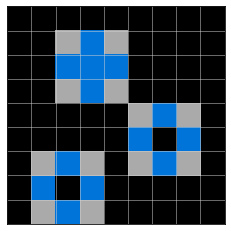

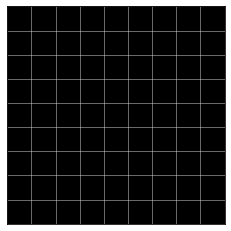

15800
Loss: 0.14440342783927917
Val loss: 1.816267490386963


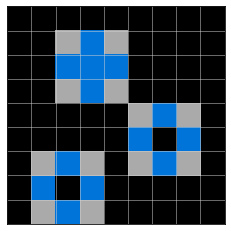

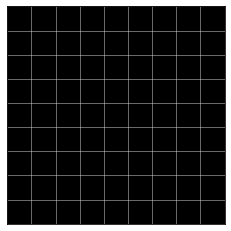

15900
Loss: 0.12225610017776489
Val loss: 2.2504327297210693


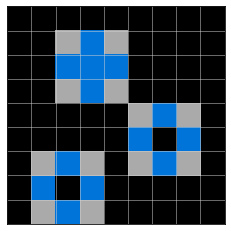

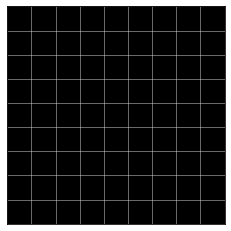

16000
Loss: 0.05426272749900818
Val loss: 1.7616554498672485


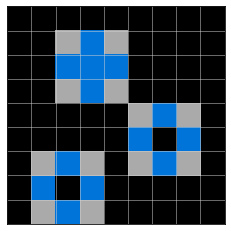

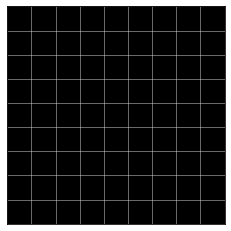

16100
Loss: 0.0535171739757061
Val loss: 1.4602622985839844


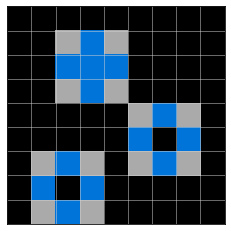

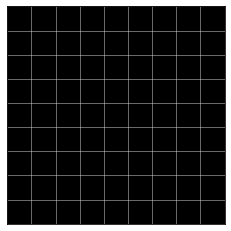

16200
Loss: 0.06626296788454056
Val loss: 3.315126419067383


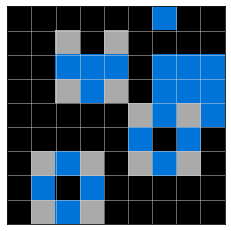

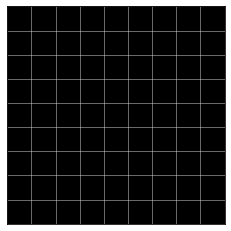

16300
Loss: 0.055910758674144745
Val loss: 1.7151421308517456


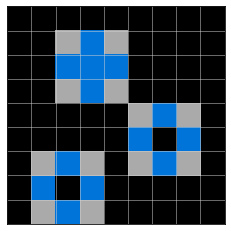

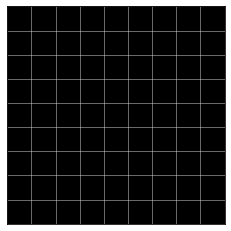

16400
Loss: 0.07427503168582916
Val loss: 2.047597885131836


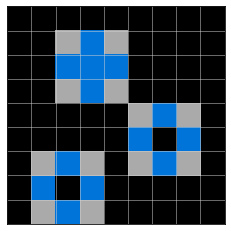

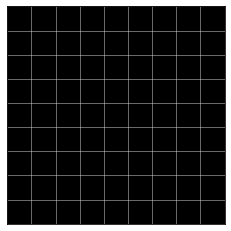

16500
Loss: 0.05538433790206909
Val loss: 0.8791047930717468


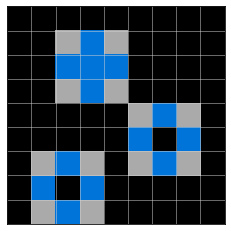

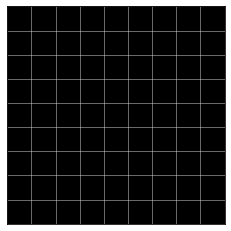

16600
Loss: 0.0538010373711586
Val loss: 0.10259971022605896


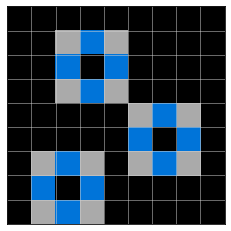

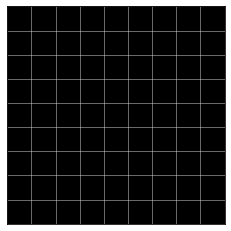

16700
Loss: 0.10527192801237106
Val loss: 0.9779391884803772


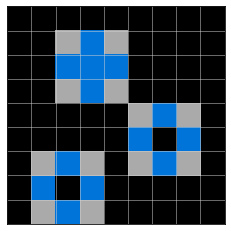

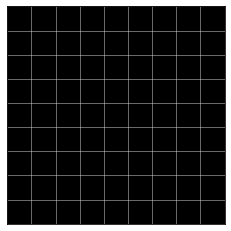

16800
Loss: 0.053984545171260834
Val loss: 0.3211011290550232


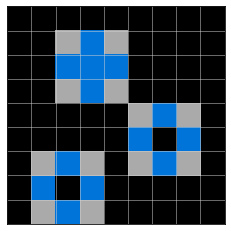

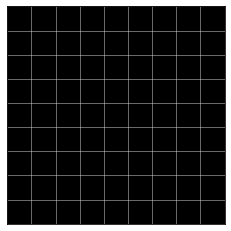

16900
Loss: 0.055519476532936096
Val loss: 0.05902309715747833


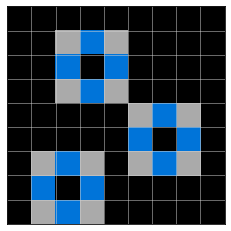

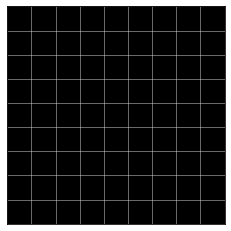

17000
Loss: 0.10939480364322662
Val loss: 0.056053172796964645


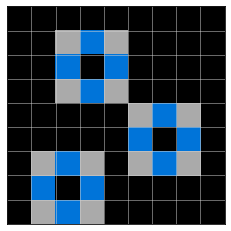

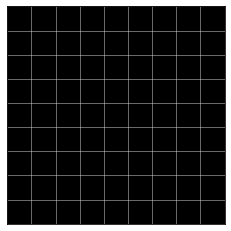

17100
Loss: 0.27853235602378845
Val loss: 0.9205884337425232


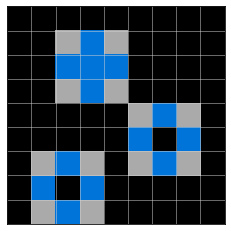

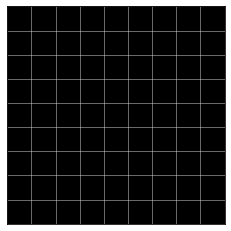

17200
Loss: 0.13355877995491028
Val loss: 0.7301101088523865


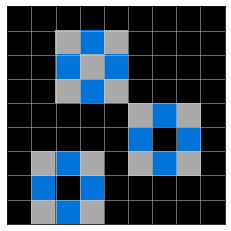

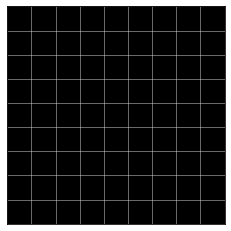

17300
Loss: 0.5621967315673828
Val loss: 0.5645226836204529


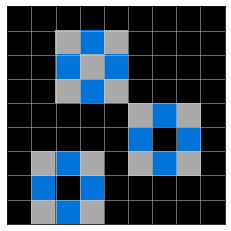

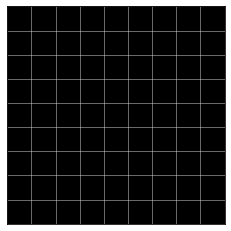

17400
Loss: 0.05565784499049187
Val loss: 1.0805974006652832


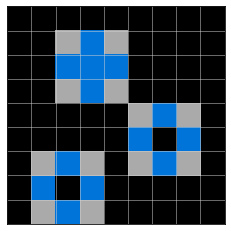

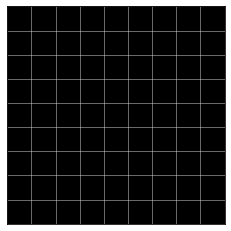

17500
Loss: 0.05413036048412323
Val loss: 1.3253992795944214


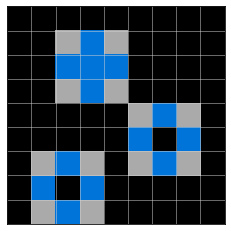

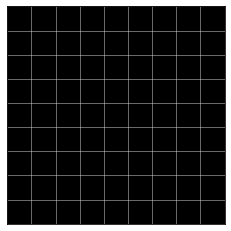

17600
Loss: 1.2423866987228394
Val loss: 2.154298782348633


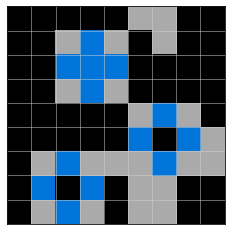

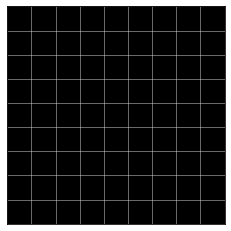

17700
Loss: 0.05441559478640556
Val loss: 0.08804118633270264


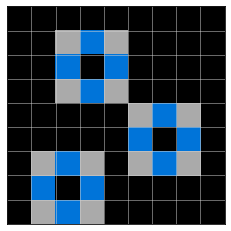

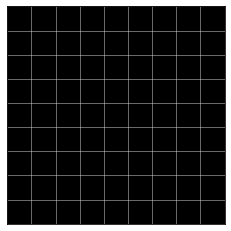

17800
Loss: 0.054309964179992676
Val loss: 0.057136908173561096


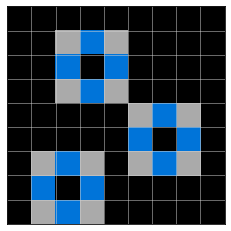

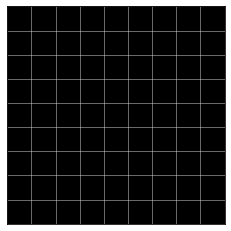

17900
Loss: 0.08218830823898315
Val loss: 0.7085936069488525


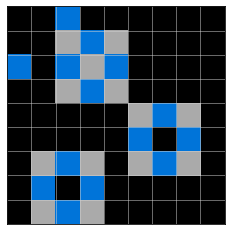

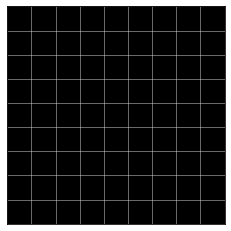

18000
Loss: 0.06485313177108765
Val loss: 1.1474685668945312


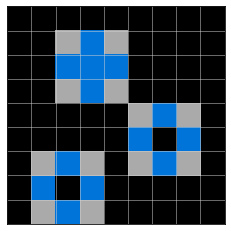

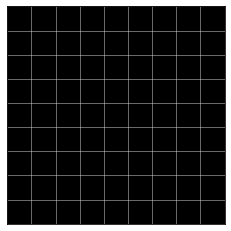

18100
Loss: 0.24592526257038116
Val loss: 1.0762574672698975


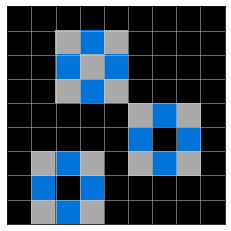

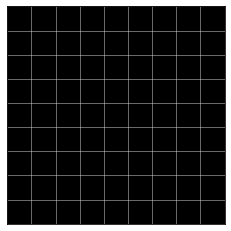

18200
Loss: 0.4595082700252533
Val loss: 1.8451894521713257


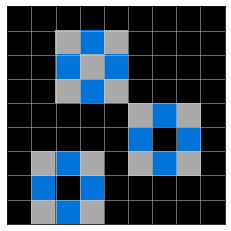

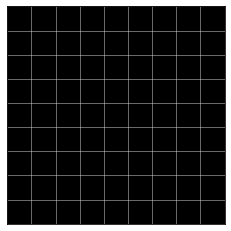

18300
Loss: 0.11171427369117737
Val loss: 0.17127783596515656


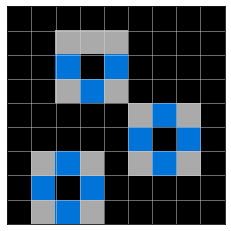

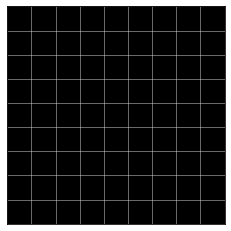

18400
Loss: 0.05315155163407326
Val loss: 0.17997510731220245


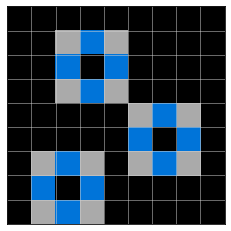

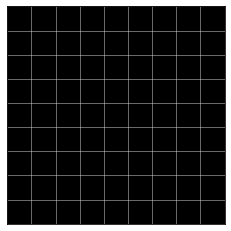

18500
Loss: 0.24201083183288574
Val loss: 0.5549916625022888


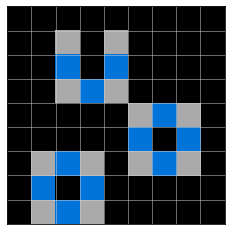

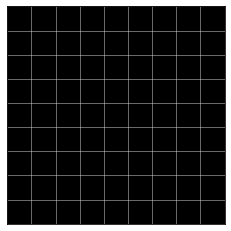

18600
Loss: 0.05540991574525833
Val loss: 0.5496044158935547


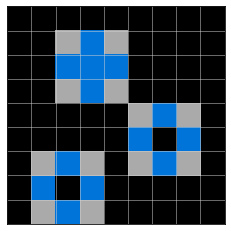

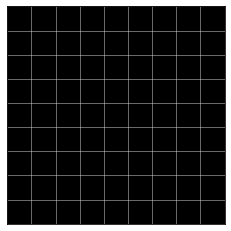

18700
Loss: 0.05650629475712776
Val loss: 0.11932285875082016


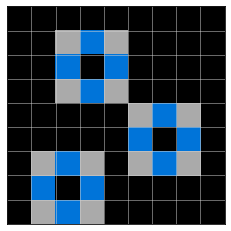

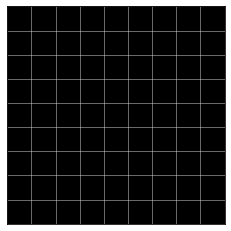

18800
Loss: 0.04946101829409599
Val loss: 0.05102767422795296


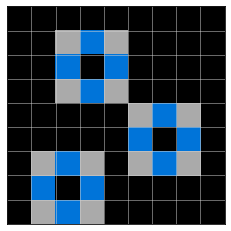

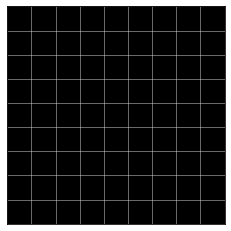

18900
Loss: 0.051048487424850464
Val loss: 0.05448369309306145


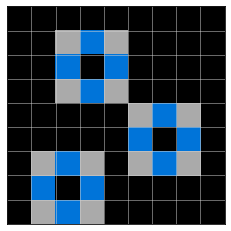

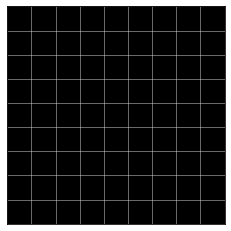

19000
Loss: 0.1495322287082672
Val loss: 0.5955193042755127


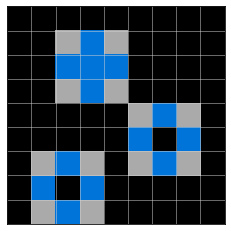

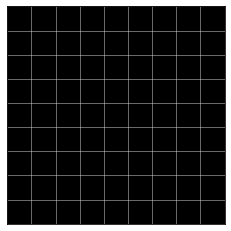

19100
Loss: 0.15148712694644928
Val loss: 0.052052855491638184


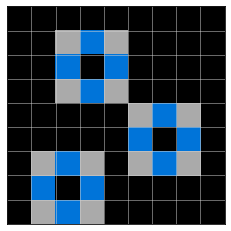

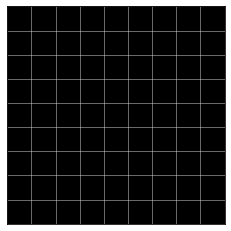

19200
Loss: 0.0483471155166626
Val loss: 0.2278875708580017


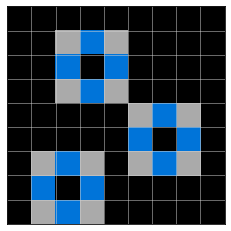

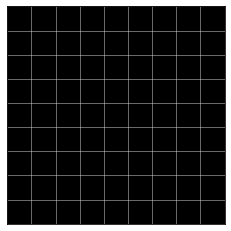

19300
Loss: 0.04941452667117119
Val loss: 0.3636588156223297


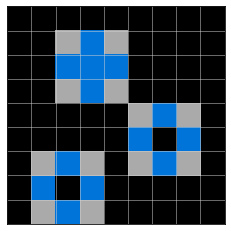

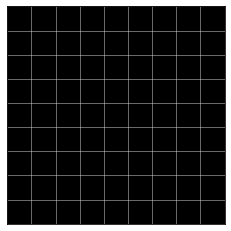

19400
Loss: 0.04911747947335243
Val loss: 0.3227740526199341


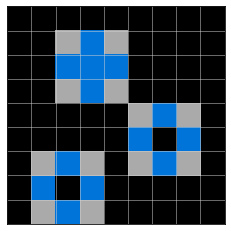

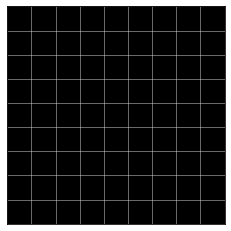

19500
Loss: 0.05159934237599373
Val loss: 0.05169318988919258


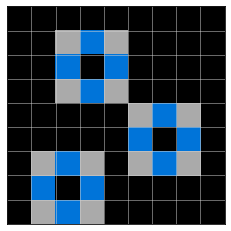

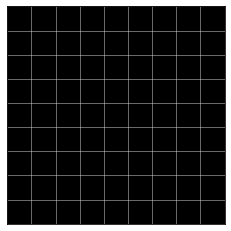

19600
Loss: 0.07732924073934555
Val loss: 0.3180784583091736


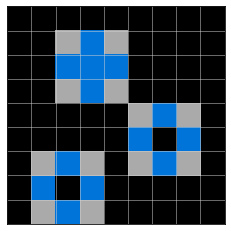

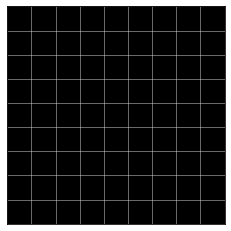

19700
Loss: 0.4956034719944
Val loss: 1.4684628248214722


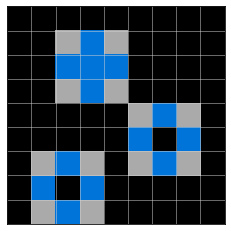

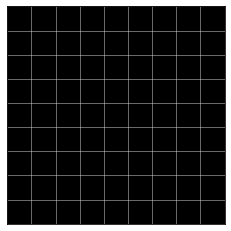

19800
Loss: 0.04885094240307808
Val loss: 0.24010992050170898


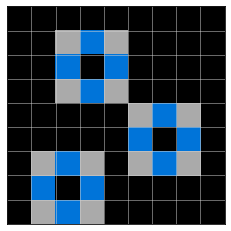

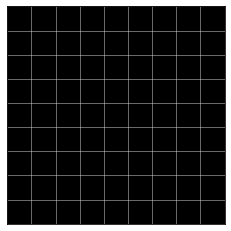

19900
Loss: 0.0500449500977993
Val loss: 0.057535797357559204


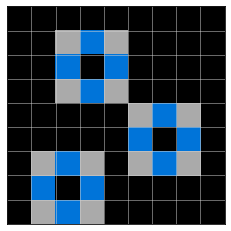

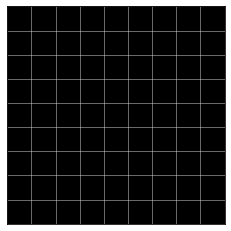

20000
Loss: 0.10893391817808151
Val loss: 0.21760834753513336


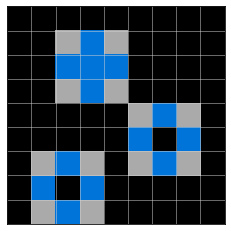

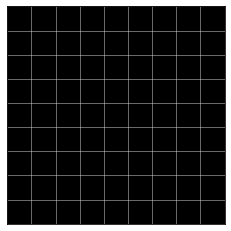

20100
Loss: 0.06507427990436554
Val loss: 0.05016155168414116


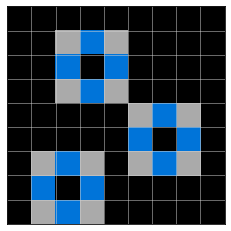

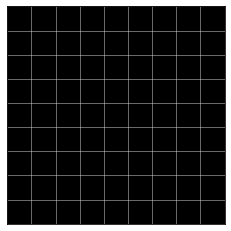

20200
Loss: 0.0989108458161354
Val loss: 0.09813044220209122


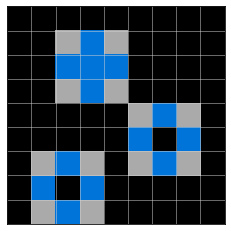

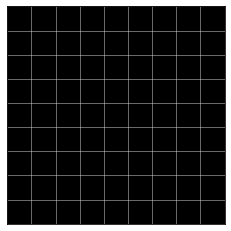

20300
Loss: 0.04729160666465759
Val loss: 0.23404043912887573


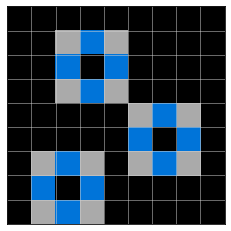

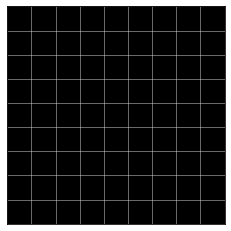

20400
Loss: 0.21327321231365204
Val loss: 0.6321645975112915


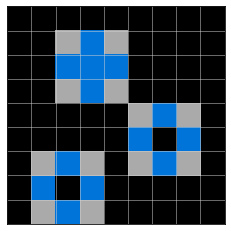

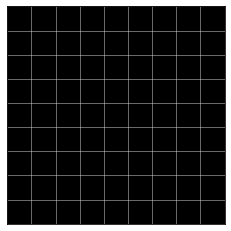

20500
Loss: 1.0136853456497192
Val loss: 0.4969010055065155


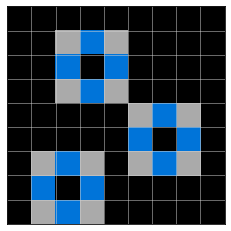

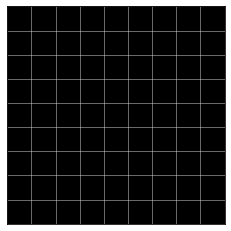

20600
Loss: 0.18709714710712433
Val loss: 0.29025429487228394


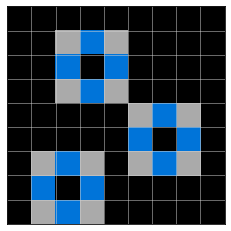

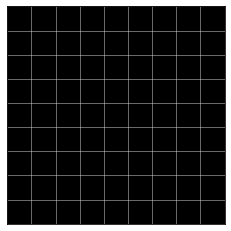

20700
Loss: 0.17857828736305237
Val loss: 0.16083575785160065


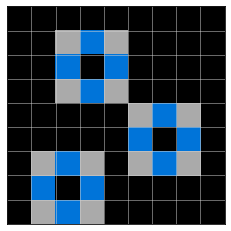

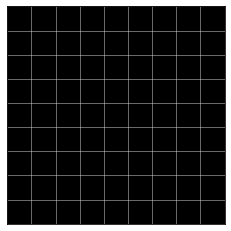

20800
Loss: 0.06687033176422119
Val loss: 0.18840527534484863


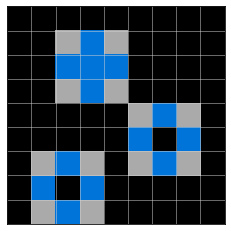

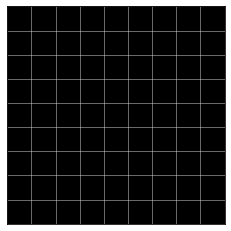

20900
Loss: 0.05045437440276146
Val loss: 0.5483080744743347


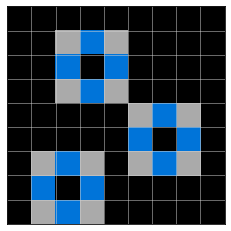

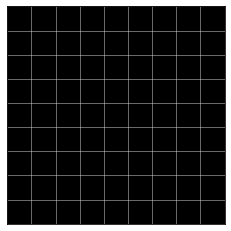

21000
Loss: 0.05542082339525223
Val loss: 0.6786806583404541


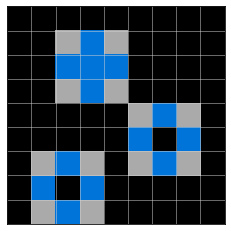

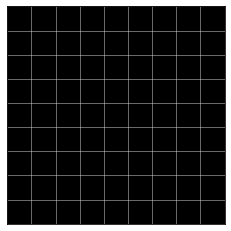

21100
Loss: 0.0662045031785965
Val loss: 0.05544934794306755


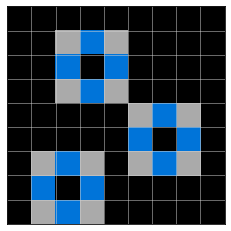

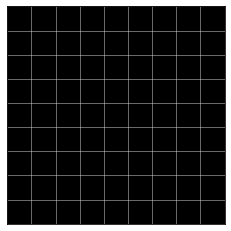

21200
Loss: 0.049086153507232666
Val loss: 0.0808604508638382


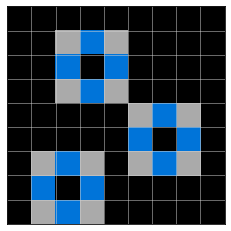

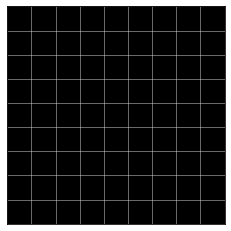

21300
Loss: 0.5971599817276001
Val loss: 0.05646883323788643


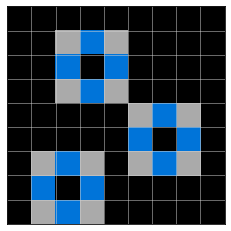

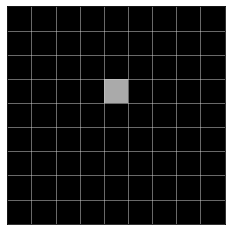

21400
Loss: 0.1246376484632492
Val loss: 0.7627133727073669


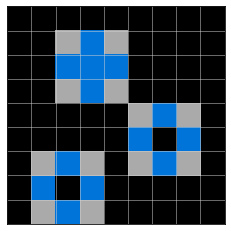

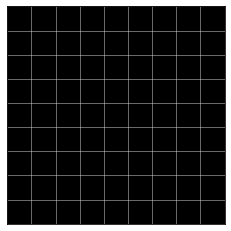

21500
Loss: 0.04952066391706467
Val loss: 0.38183704018592834


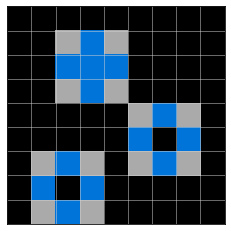

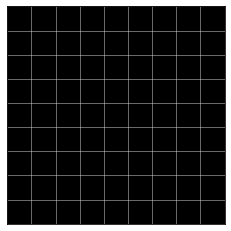

21600
Loss: 0.5825076103210449
Val loss: 0.1714666336774826


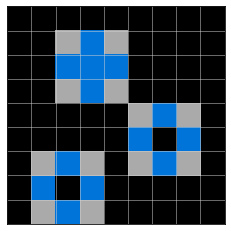

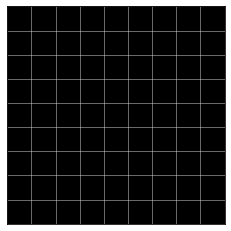

21700
Loss: 0.05022917687892914
Val loss: 0.05261826887726784


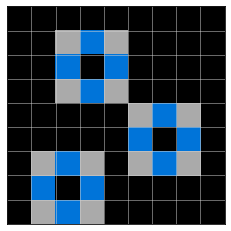

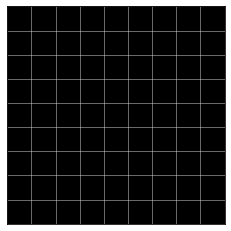

21800
Loss: 0.06951595842838287
Val loss: 0.059009749442338943


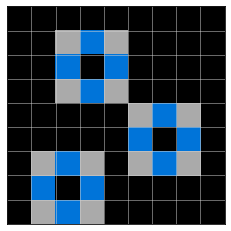

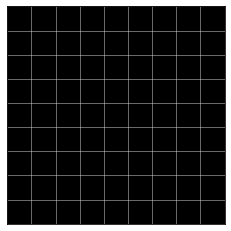

21900
Loss: 0.11481264978647232
Val loss: 0.1266532987356186


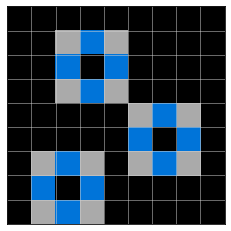

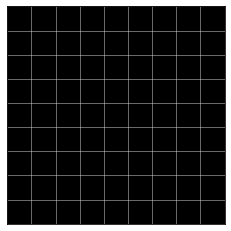

22000
Loss: 0.05067962780594826
Val loss: 1.3211504220962524


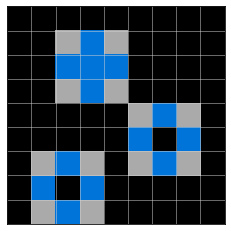

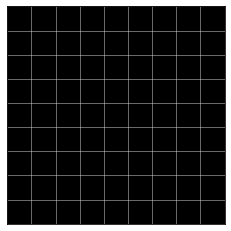

22100
Loss: 0.0764859989285469
Val loss: 0.05023638531565666


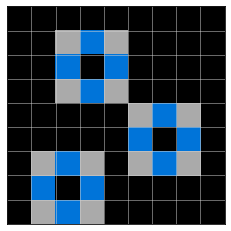

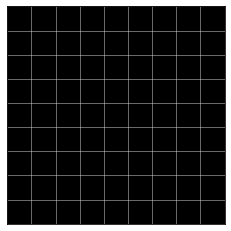

22200
Loss: 0.050600565969944
Val loss: 0.05090591311454773


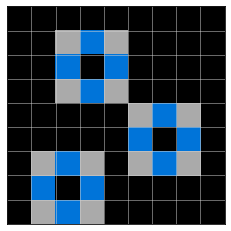

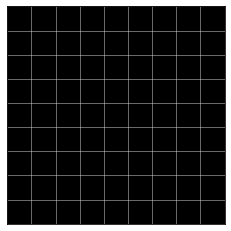

22300
Loss: 0.05076291412115097
Val loss: 0.05038364231586456


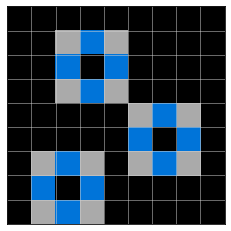

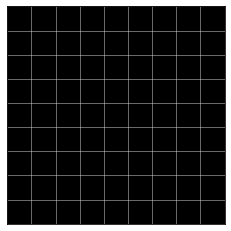

22400
Loss: 0.11854352802038193
Val loss: 1.9590505361557007


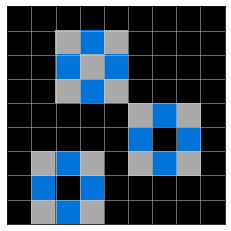

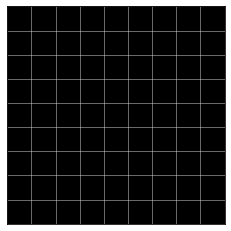

22500
Loss: 0.0709567666053772
Val loss: 0.7045948505401611


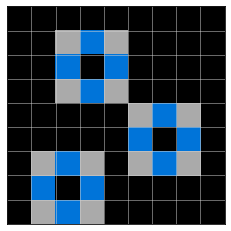

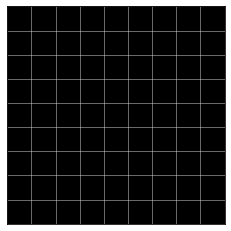

22600
Loss: 0.14166077971458435
Val loss: 0.24816636741161346


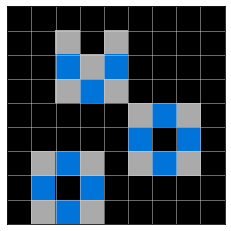

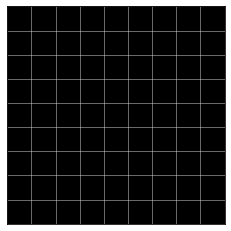

22700
Loss: 0.38254934549331665
Val loss: 1.4656285047531128


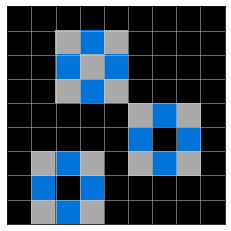

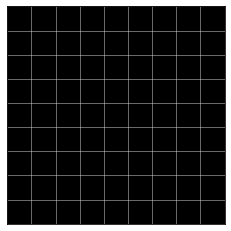

22800
Loss: 0.06969496607780457
Val loss: 0.5216148495674133


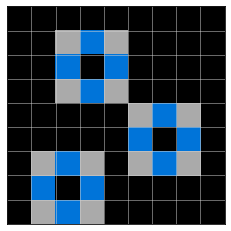

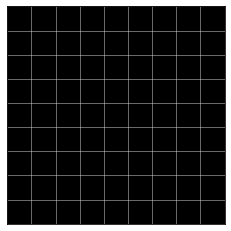

22900
Loss: 0.15952950716018677
Val loss: 0.23598897457122803


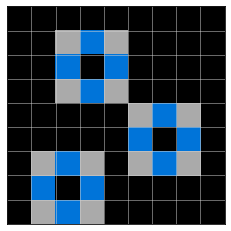

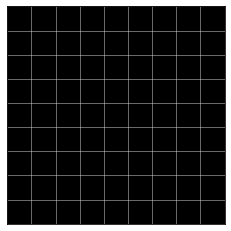

23000
Loss: 0.04835687577724457
Val loss: 0.2204180508852005


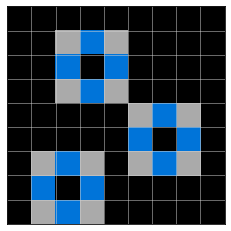

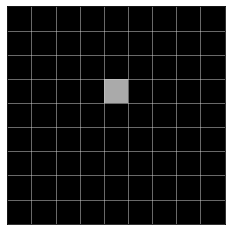

23100
Loss: 0.05663587898015976
Val loss: 0.06094721332192421


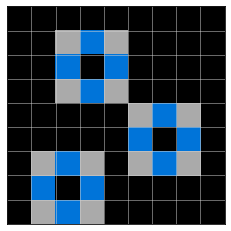

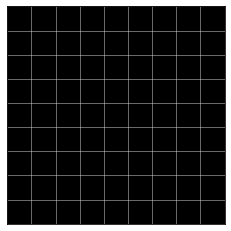

23200
Loss: 0.04952970892190933
Val loss: 0.8888576030731201


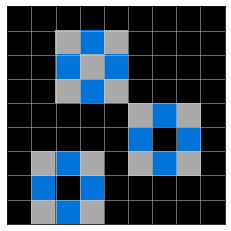

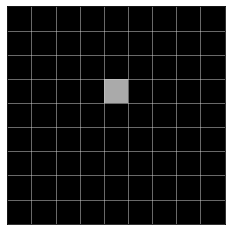

23300
Loss: 0.048270341008901596
Val loss: 0.051298800855875015


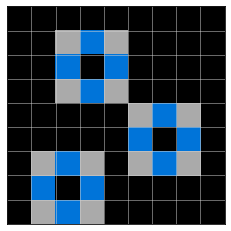

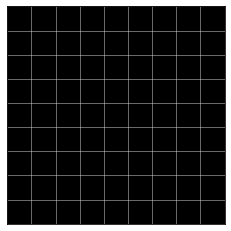

23400
Loss: 0.07512041181325912
Val loss: 0.09785432368516922


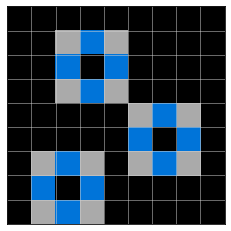

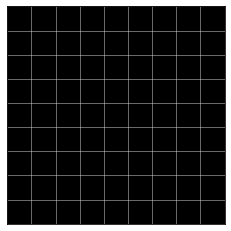

23500
Loss: 0.06681685149669647
Val loss: 0.052305713295936584


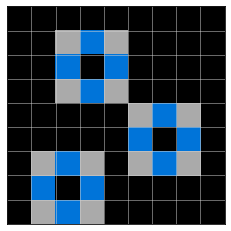

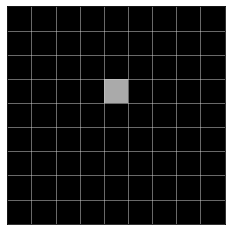

23600
Loss: 0.0643947422504425
Val loss: 0.078976109623909


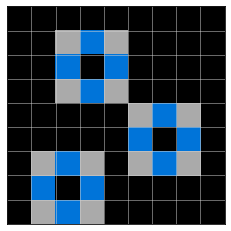

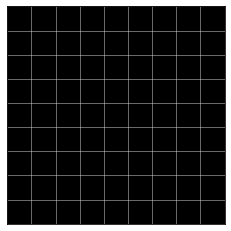

23700
Loss: 0.08489377796649933
Val loss: 0.053401995450258255


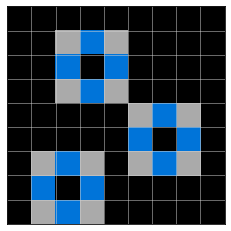

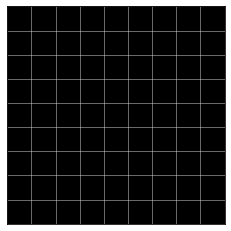

23800
Loss: 0.04805723577737808
Val loss: 0.14580786228179932


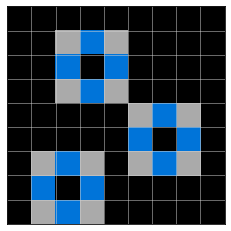

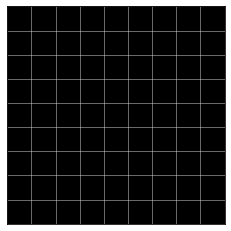

23900
Loss: 0.04888850823044777
Val loss: 0.18207985162734985


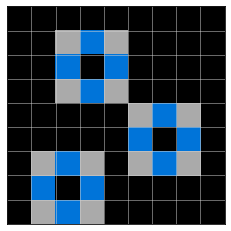

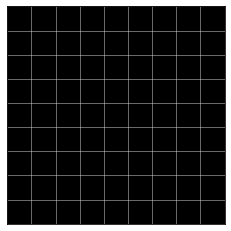

24000
Loss: 0.04684323072433472
Val loss: 0.20978796482086182


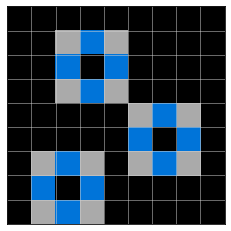

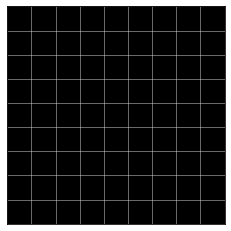

24100
Loss: 0.29963648319244385
Val loss: 0.1444692313671112


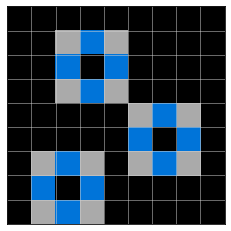

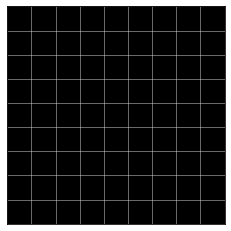

24200
Loss: 0.29192256927490234
Val loss: 0.8162959218025208


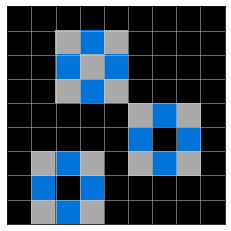

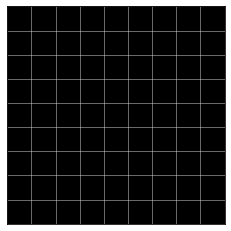

24300
Loss: 0.05269649997353554
Val loss: 0.6526796817779541


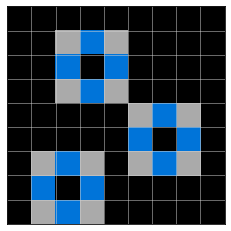

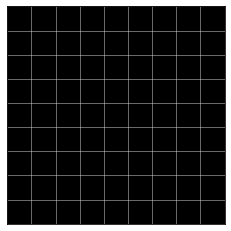

24400
Loss: 0.12074748426675797
Val loss: 0.050310131162405014


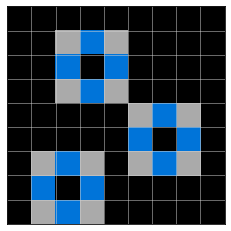

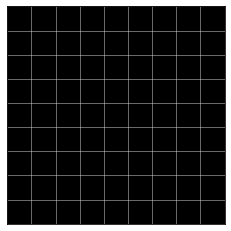

24500
Loss: 0.05022800341248512
Val loss: 0.09126552939414978


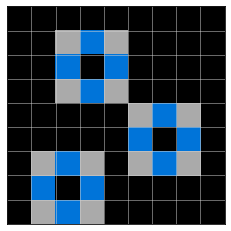

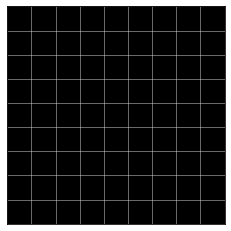

24600
Loss: 0.056728143244981766
Val loss: 0.05023661255836487


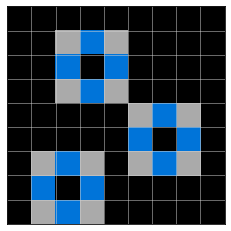

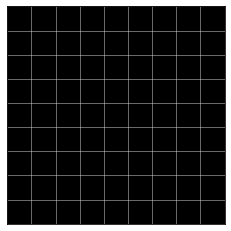

24700
Loss: 0.04746634513139725
Val loss: 0.05940597876906395


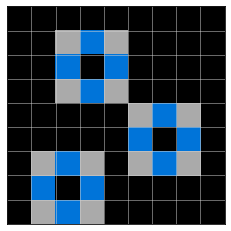

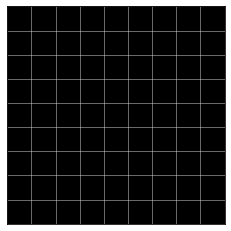

24800
Loss: 0.6198791265487671
Val loss: 0.5048471689224243


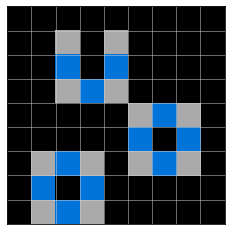

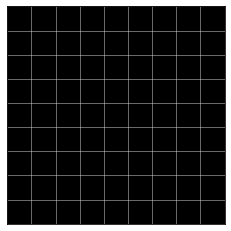

24900
Loss: 0.14680518209934235
Val loss: 0.05594082176685333


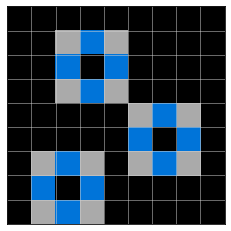

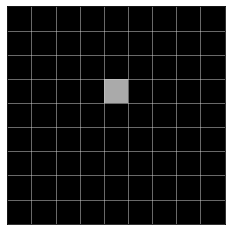

25000
Loss: 0.14924119412899017
Val loss: 0.27176234126091003


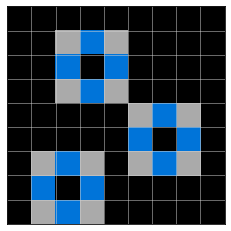

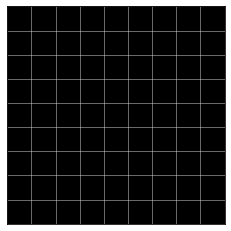

25100
Loss: 0.09399835765361786
Val loss: 0.05087044835090637


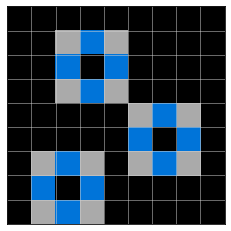

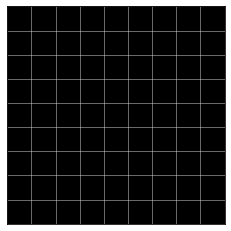

25200
Loss: 0.22810032963752747
Val loss: 0.7525689005851746


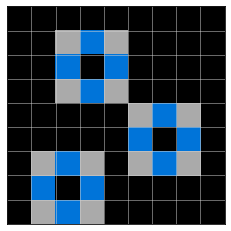

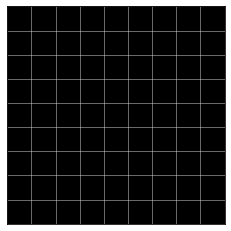

25300
Loss: 0.04706859216094017
Val loss: 0.31191831827163696


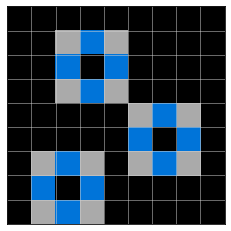

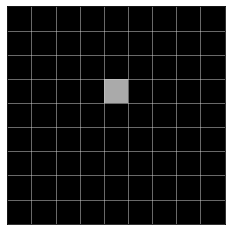

25400
Loss: 0.046791113913059235
Val loss: 0.14907455444335938


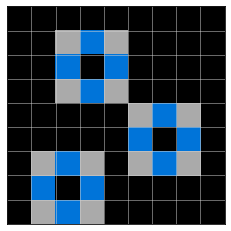

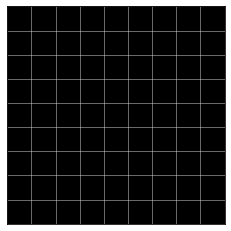

25500
Loss: 0.04894723743200302
Val loss: 0.06787058711051941


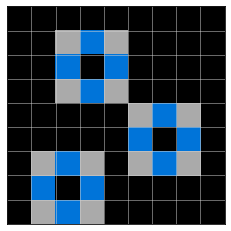

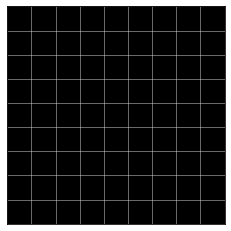

25600
Loss: 0.18401101231575012
Val loss: 0.12976765632629395


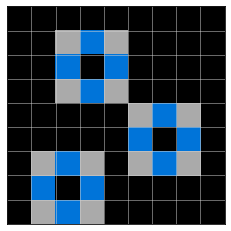

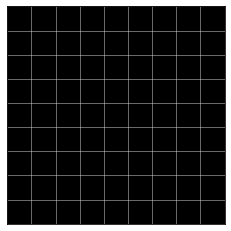

25700
Loss: 0.04778255149722099
Val loss: 0.6993839740753174


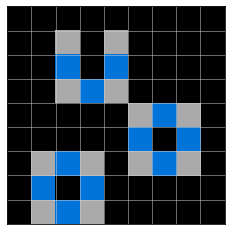

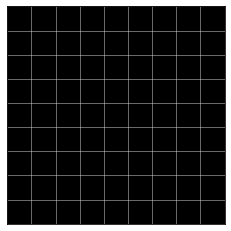

25800
Loss: 0.16541427373886108
Val loss: 0.06250763684511185


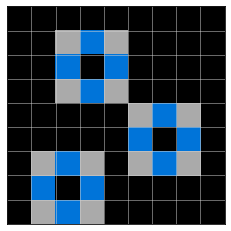

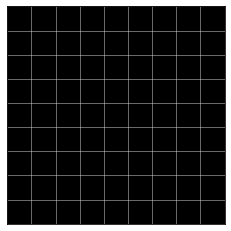

25900
Loss: 0.34083881974220276
Val loss: 0.5366182327270508


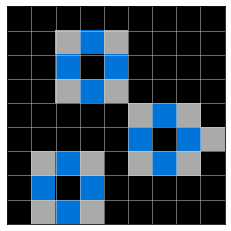

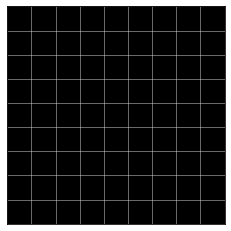

26000
Loss: 0.18911392986774445
Val loss: 0.23779727518558502


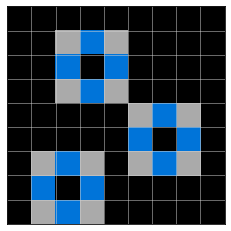

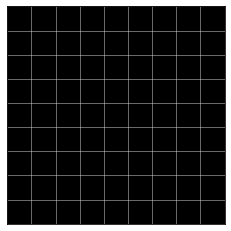

26100
Loss: 0.47082653641700745
Val loss: 0.2560673654079437


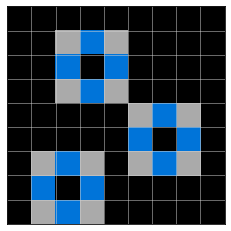

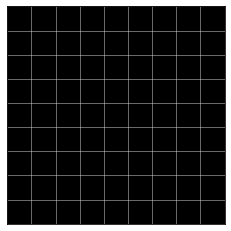

26200
Loss: 0.05189792439341545
Val loss: 0.07526418566703796


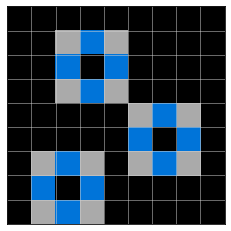

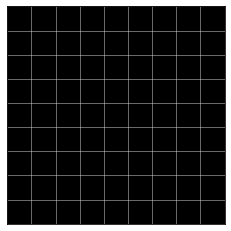

26300
Loss: 0.048510175198316574
Val loss: 0.3750399649143219


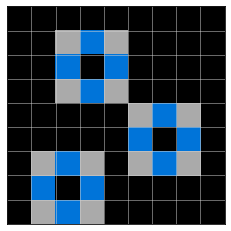

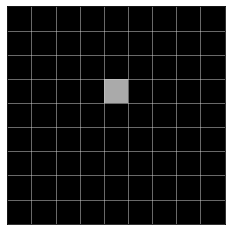

26400
Loss: 0.12296418100595474
Val loss: 0.23636607825756073


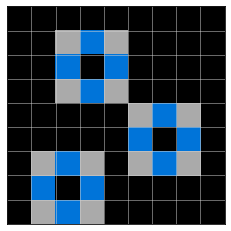

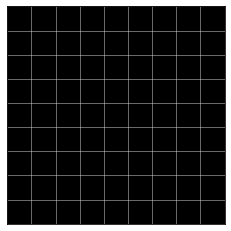

26500
Loss: 0.09763035923242569
Val loss: 0.8353055119514465


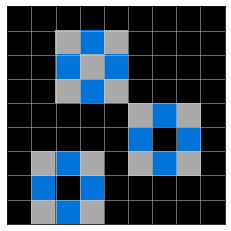

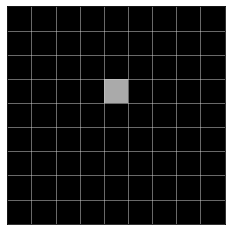

26600
Loss: 1.102389931678772
Val loss: 0.34526100754737854


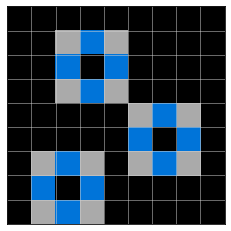

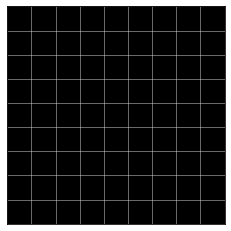

26700
Loss: 0.0485338494181633
Val loss: 0.2656266391277313


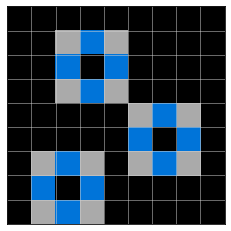

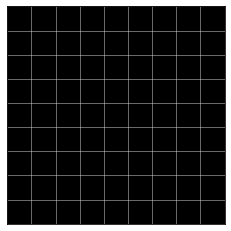

26800
Loss: 0.04825937747955322
Val loss: 0.11225556582212448


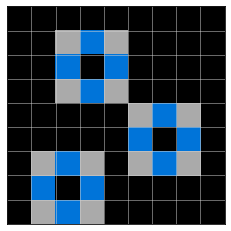

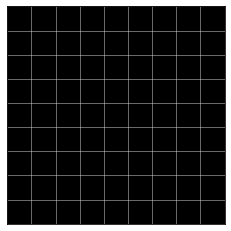

26900
Loss: 0.04950158670544624
Val loss: 0.05402626469731331


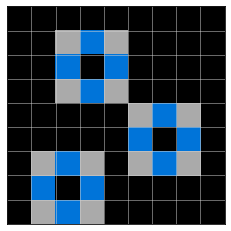

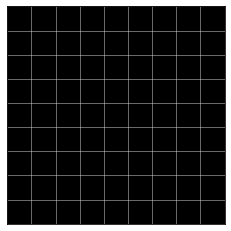

27000
Loss: 0.2858375906944275
Val loss: 0.2163875848054886


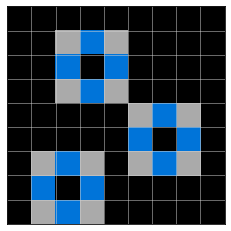

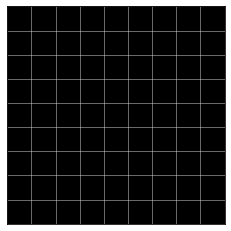

27100
Loss: 0.0509481206536293
Val loss: 0.05060221254825592


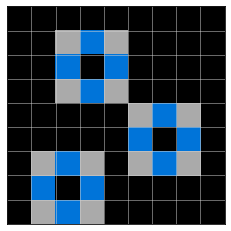

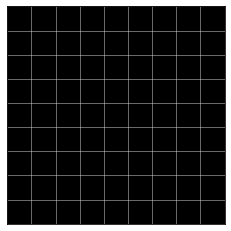

27200
Loss: 0.06009605526924133
Val loss: 0.33383166790008545


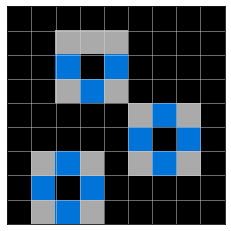

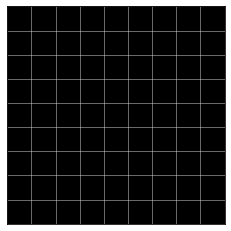

27300
Loss: 0.10673543810844421
Val loss: 0.2218259572982788


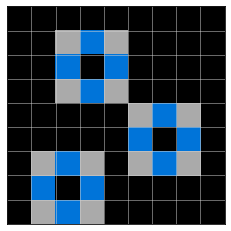

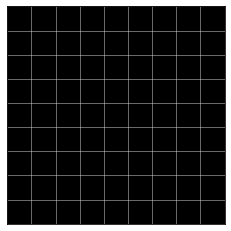

27400
Loss: 0.050287216901779175
Val loss: 0.3639664649963379


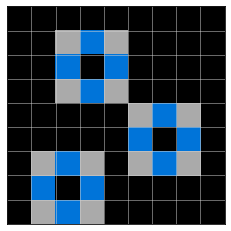

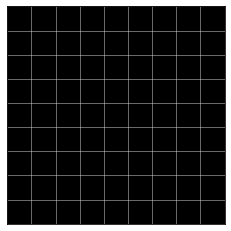

27500
Loss: 0.049240972846746445
Val loss: 0.21061702072620392


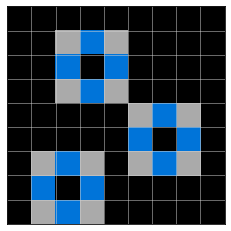

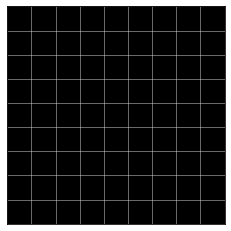

27600
Loss: 0.30198028683662415
Val loss: 0.606273889541626


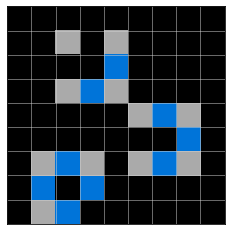

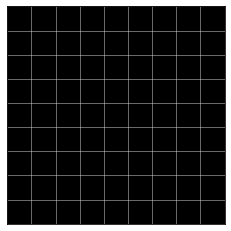

27700
Loss: 0.09367282688617706
Val loss: 0.29249870777130127


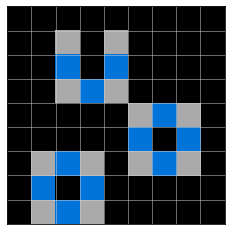

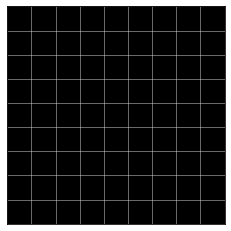

27800
Loss: 0.054053690284490585
Val loss: 0.15769889950752258


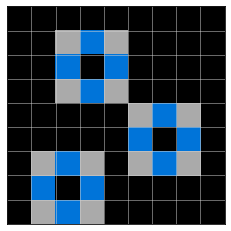

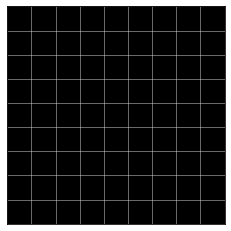

27900
Loss: 0.08400826156139374
Val loss: 0.13888436555862427


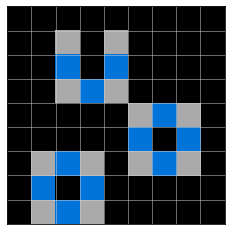

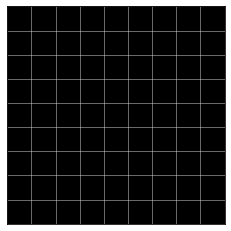

28000
Loss: 0.05186918377876282
Val loss: 0.06039808690547943


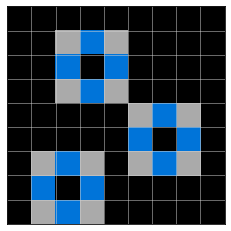

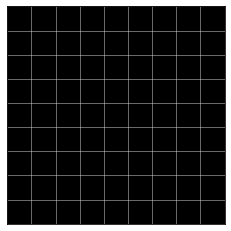

28100
Loss: 0.05074620991945267
Val loss: 0.3370775878429413


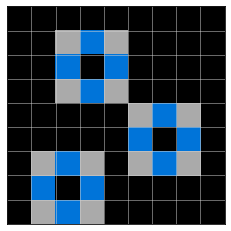

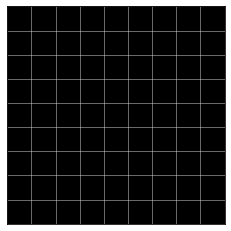

28200
Loss: 0.05317161604762077
Val loss: 0.37345150113105774


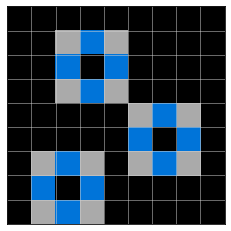

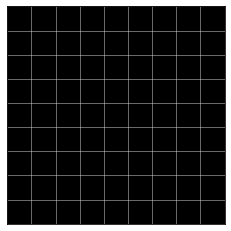

28300
Loss: 0.11029516905546188
Val loss: 0.06357518583536148


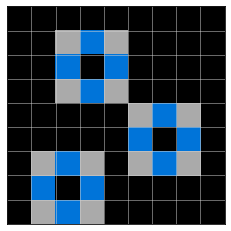

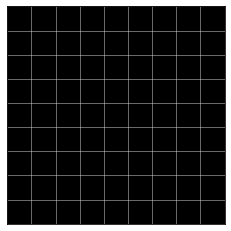

28400
Loss: 0.5470981597900391
Val loss: 0.6599719524383545


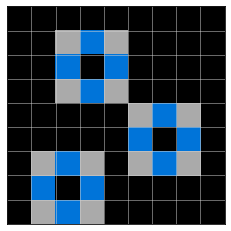

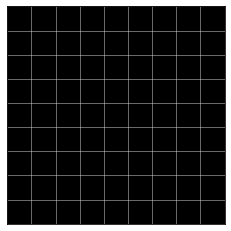

28500
Loss: 0.10602569580078125
Val loss: 0.05242210254073143


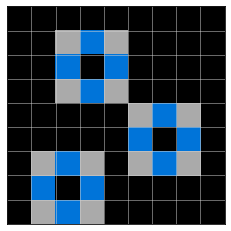

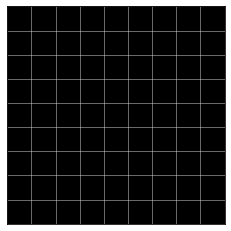

28600
Loss: 0.05295903608202934
Val loss: 0.3832418620586395


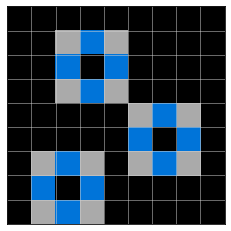

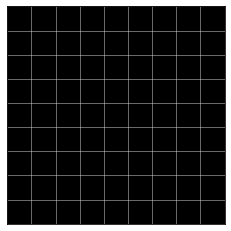

28700
Loss: 0.4601540267467499
Val loss: 0.10893860459327698


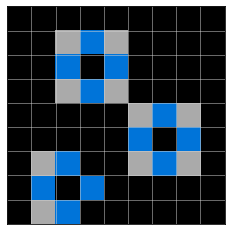

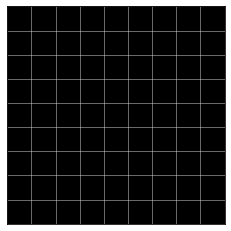

28800
Loss: 0.05386240407824516
Val loss: 0.34890806674957275


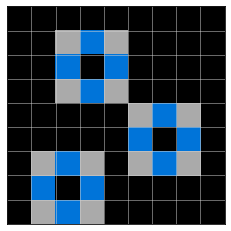

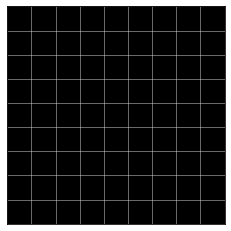

28900
Loss: 0.0693109929561615
Val loss: 0.05746592581272125


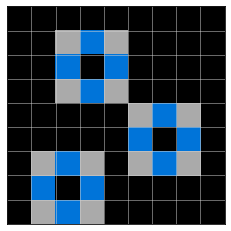

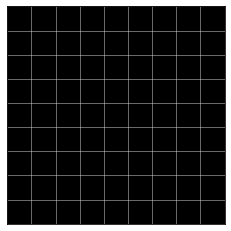

29000
Loss: 0.8713140487670898
Val loss: 0.5624969601631165


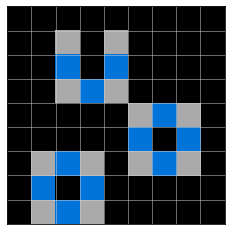

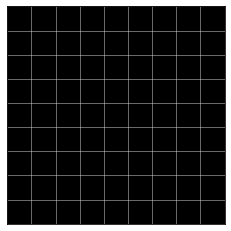

29100
Loss: 0.1322159767150879
Val loss: 0.3058737516403198


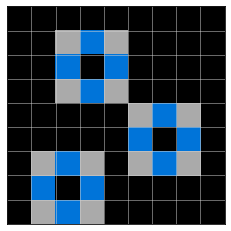

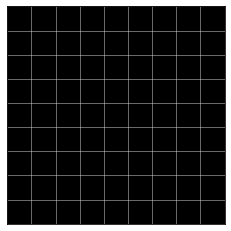

29200
Loss: 0.1262824982404709
Val loss: 0.3578459322452545


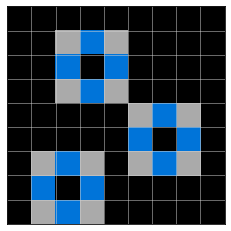

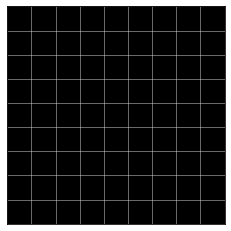

29300
Loss: 0.07859088480472565
Val loss: 12.324333190917969


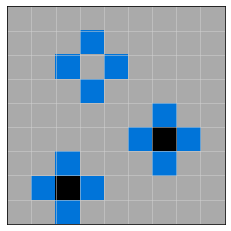

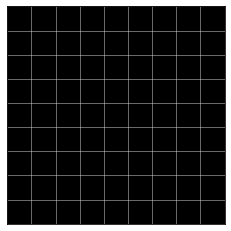

29400
Loss: 0.08408930152654648
Val loss: 0.2076192945241928


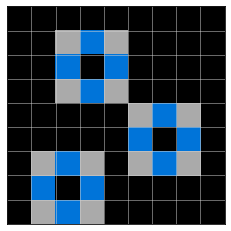

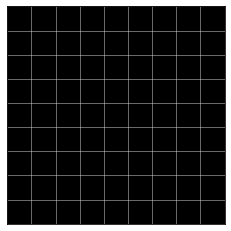

29500
Loss: 0.05199722200632095
Val loss: 0.5155506730079651


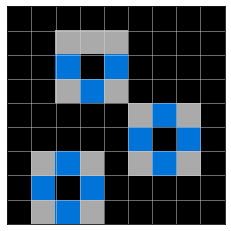

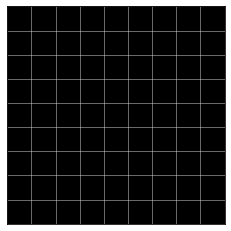

29600
Loss: 0.3650428056716919
Val loss: 0.16713102161884308


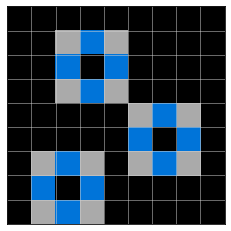

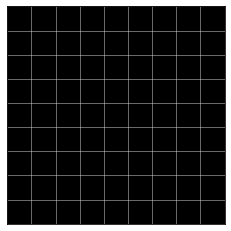

29700
Loss: 0.052270758897066116
Val loss: 0.08822224289178848


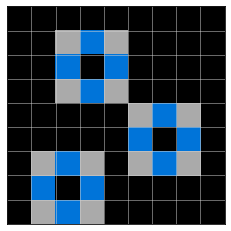

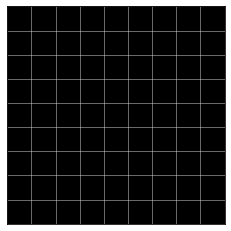

29800
Loss: 0.0599929615855217
Val loss: 0.33959200978279114


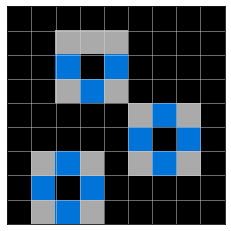

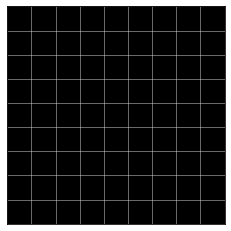

29900
Loss: 0.05040351673960686
Val loss: 0.3189653754234314


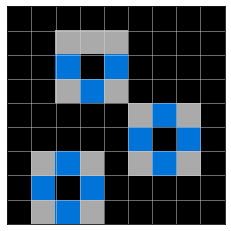

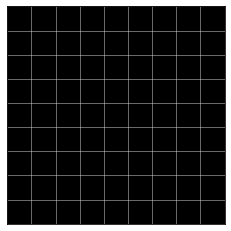

30000
Loss: 0.2028253674507141
Val loss: 0.06603866070508957


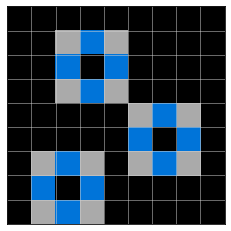

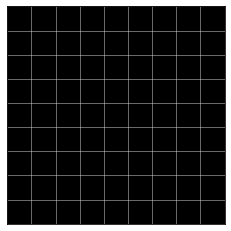

30100
Loss: 0.04921558499336243
Val loss: 0.14127933979034424


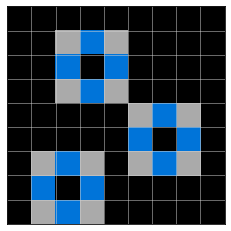

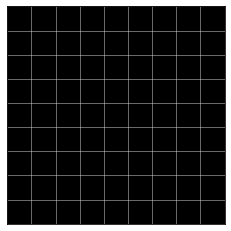

30200
Loss: 0.4840764105319977
Val loss: 0.7632542252540588


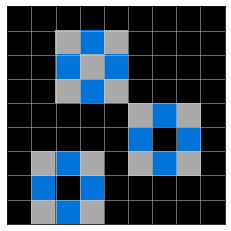

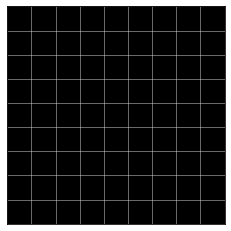

30300
Loss: 0.05090663582086563
Val loss: 0.053820714354515076


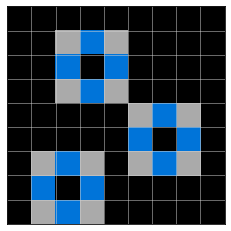

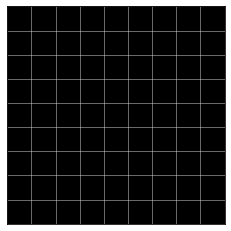

30400
Loss: 0.14965201914310455
Val loss: 0.08850476145744324


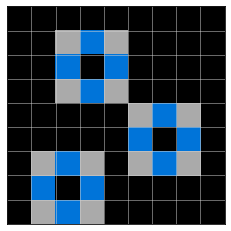

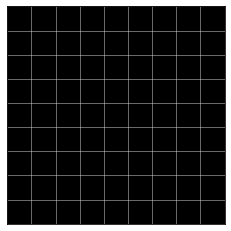

30500
Loss: 0.06099739670753479
Val loss: 0.41409340500831604


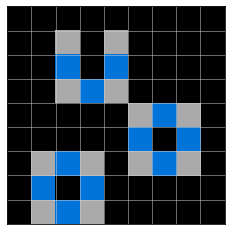

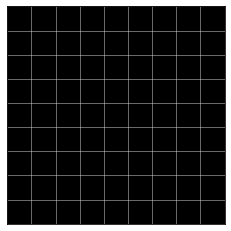

30600
Loss: 0.050560541450977325
Val loss: 0.3927535116672516


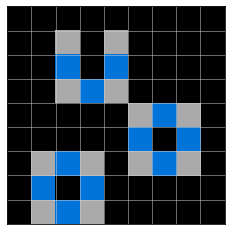

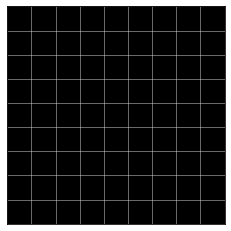

30700
Loss: 0.05101433023810387
Val loss: 0.05445363000035286


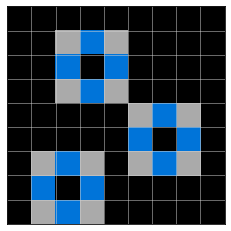

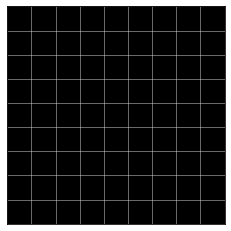

30800
Loss: 0.13545779883861542
Val loss: 0.6007447242736816


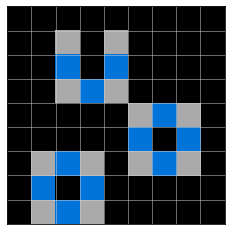

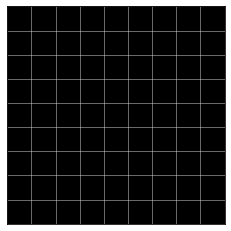

30900
Loss: 0.1084350124001503
Val loss: 0.13134989142417908


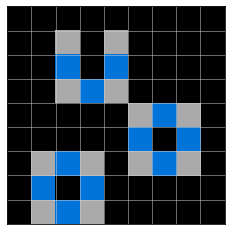

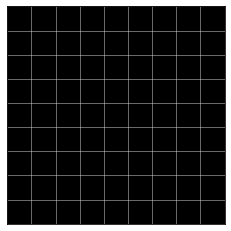

31000
Loss: 0.05084725096821785
Val loss: 1.7909077405929565


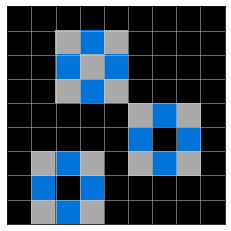

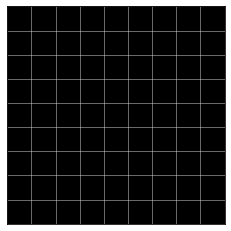

31100
Loss: 0.05054185539484024
Val loss: 0.20499007403850555


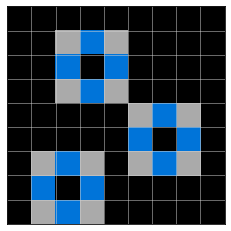

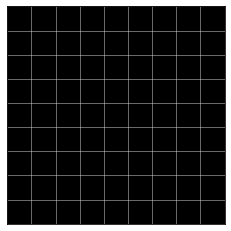

31200
Loss: 0.23010388016700745
Val loss: 0.8998327255249023


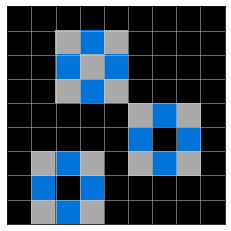

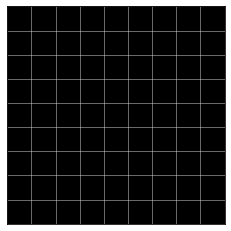

31300
Loss: 0.1481037437915802
Val loss: 0.9815627932548523


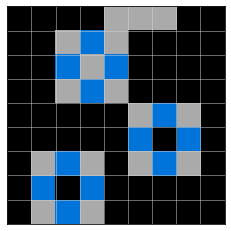

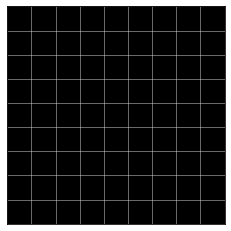

31400
Loss: 0.10939128696918488
Val loss: 0.2118161916732788


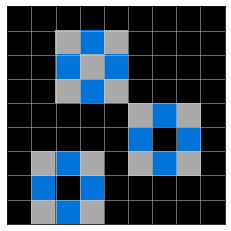

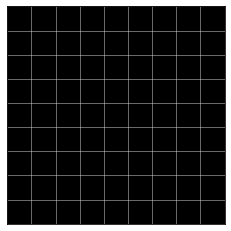

31500
Loss: 0.1083296537399292
Val loss: 1.0986239910125732


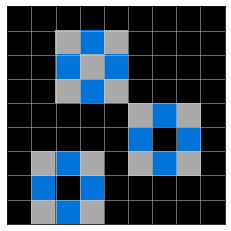

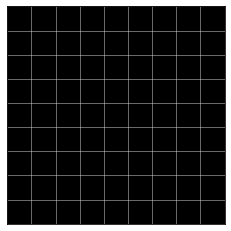

31600
Loss: 0.05789937451481819
Val loss: 0.14870169758796692


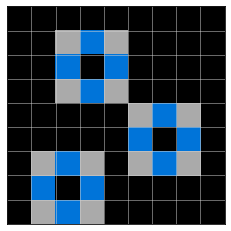

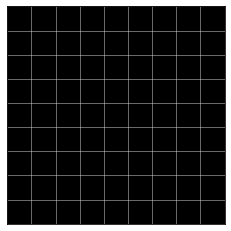

31700
Loss: 0.052980076521635056
Val loss: 0.469319224357605


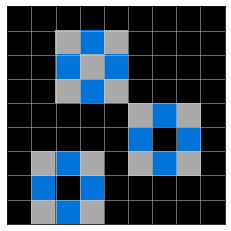

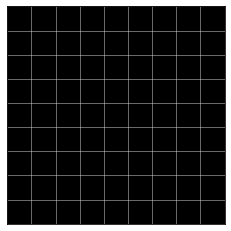

31800
Loss: 0.04976378753781319
Val loss: 1.6017518043518066


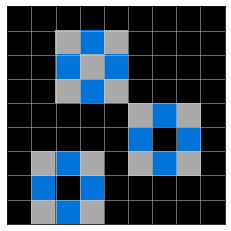

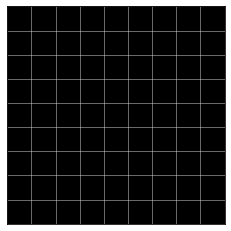

31900
Loss: 0.04684373363852501
Val loss: 0.2007640153169632


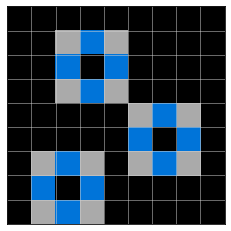

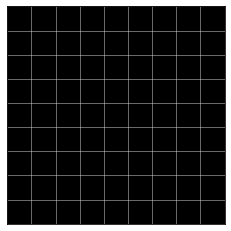

32000
Loss: 0.10597052425146103
Val loss: 1.0242112874984741


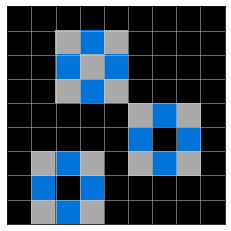

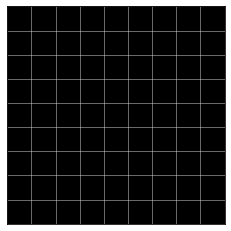

32100
Loss: 0.18783976137638092
Val loss: 3.3078126907348633


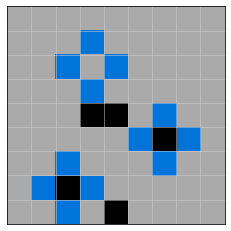

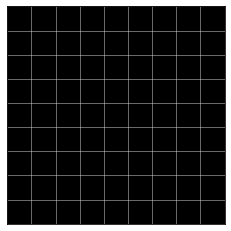

32200
Loss: 0.10224147140979767
Val loss: 0.11577284336090088


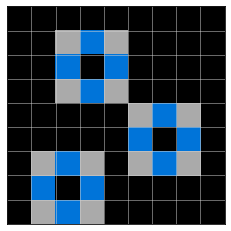

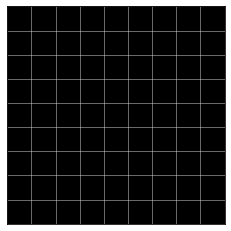

32300
Loss: 0.11446528136730194
Val loss: 0.4429037272930145


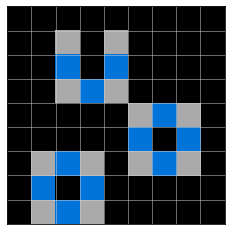

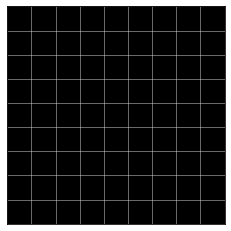

32400
Loss: 0.04751945286989212
Val loss: 0.6825211644172668


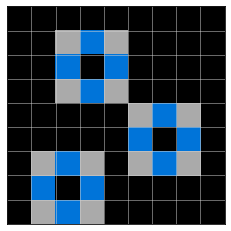

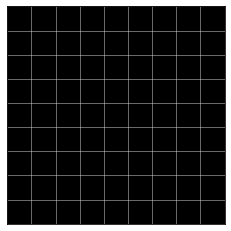

32500
Loss: 0.4715902805328369
Val loss: 0.12197663635015488


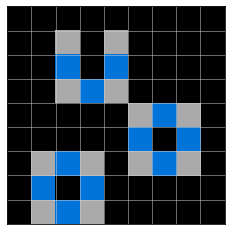

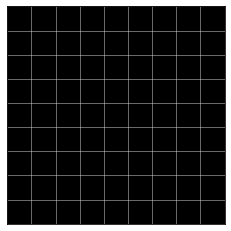

32600
Loss: 2.890355110168457
Val loss: 0.6409079432487488


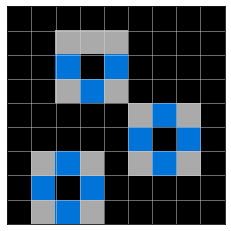

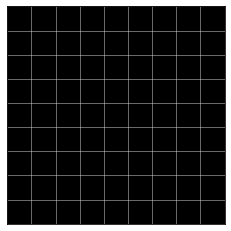

32700
Loss: 0.12821997702121735
Val loss: 0.14896489679813385


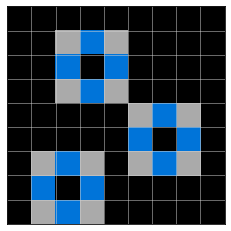

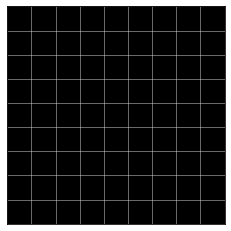

32800
Loss: 0.26412174105644226
Val loss: 4.129632949829102


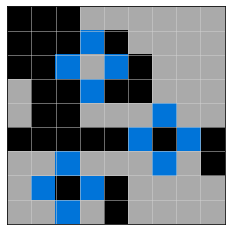

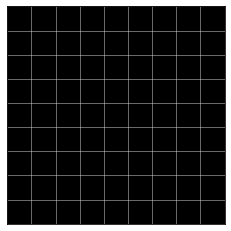

32900
Loss: 0.17621183395385742
Val loss: 0.05470181629061699


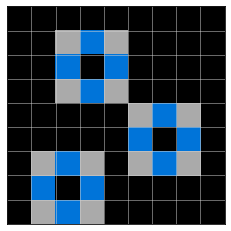

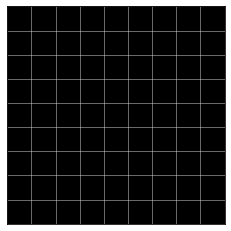

33000
Loss: 0.04944079741835594
Val loss: 0.8272534012794495


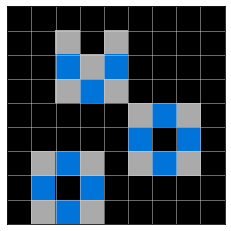

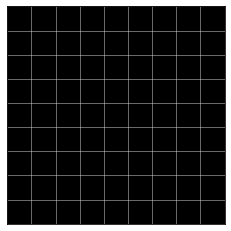

33100
Loss: 0.05469096451997757
Val loss: 1.5680975914001465


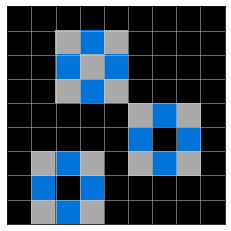

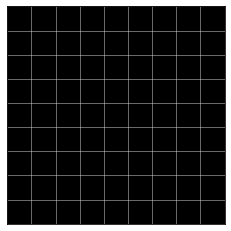

33200
Loss: 0.07664655148983002
Val loss: 0.0490216426551342


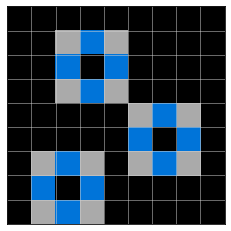

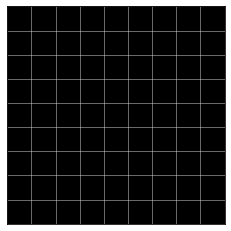

33300
Loss: 0.37613096833229065
Val loss: 0.3588613271713257


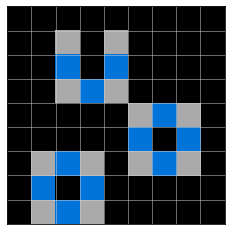

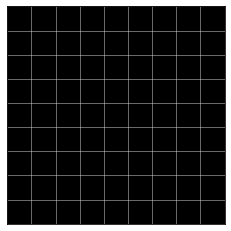

33400
Loss: 0.046613659709692
Val loss: 0.9238827228546143


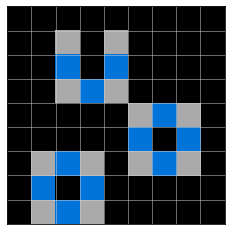

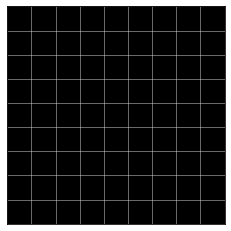

33500
Loss: 0.050181303173303604
Val loss: 0.6159509420394897


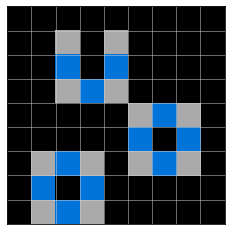

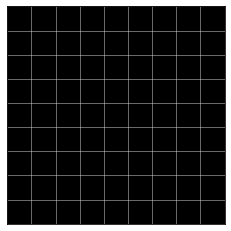

33600
Loss: 0.04742224141955376
Val loss: 0.04876651242375374


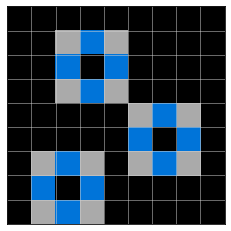

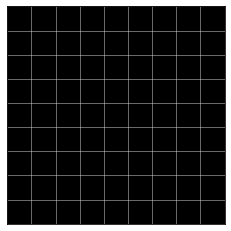

33700
Loss: 0.08687980473041534
Val loss: 0.20414094626903534


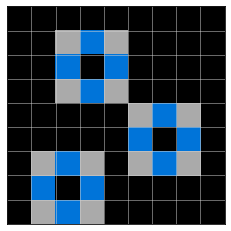

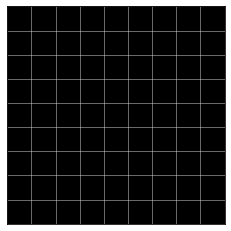

33800
Loss: 0.04592623561620712
Val loss: 0.15006791055202484


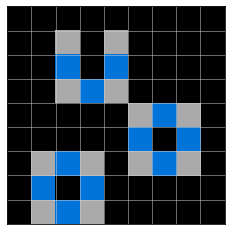

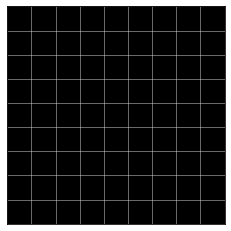

33900
Loss: 0.05016077682375908
Val loss: 0.07442383468151093


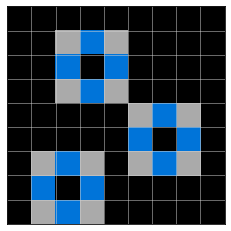

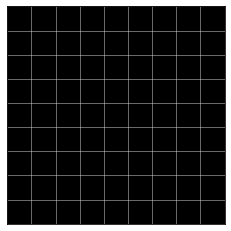

34000
Loss: 0.04919176548719406
Val loss: 0.09299782663583755


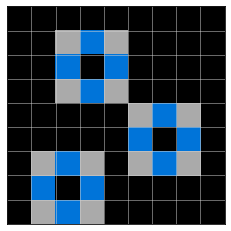

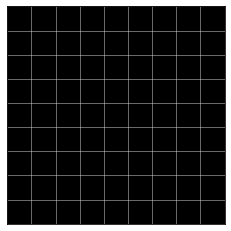

34100
Loss: 0.10275907814502716
Val loss: 0.053928446024656296


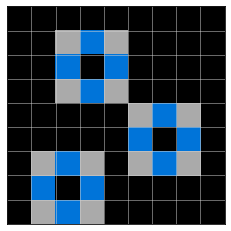

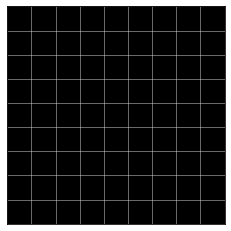

34200
Loss: 0.06757038086652756
Val loss: 1.2984397411346436


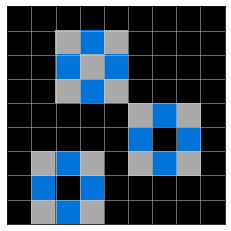

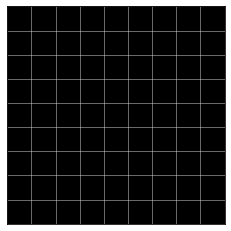

34300
Loss: 0.04680628329515457
Val loss: 0.7003771662712097


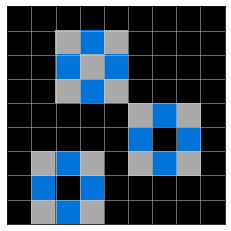

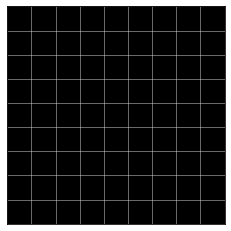

34400
Loss: 0.6868515014648438
Val loss: 2.153482437133789


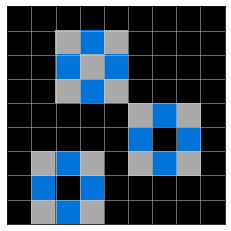

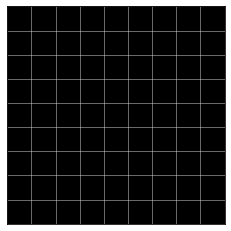

34500
Loss: 0.04675350338220596
Val loss: 2.582660675048828


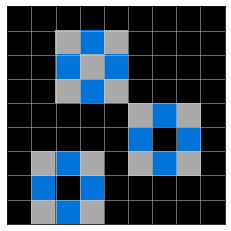

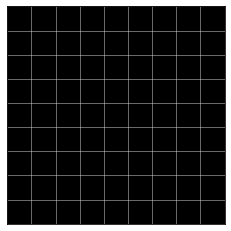

34600
Loss: 0.04661359637975693
Val loss: 1.119219422340393


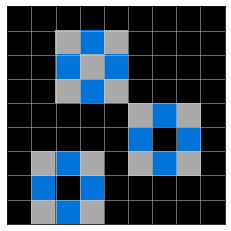

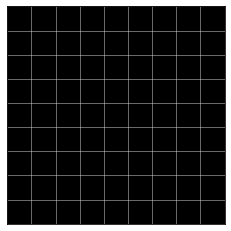

34700
Loss: 0.0454777367413044
Val loss: 0.4375019073486328


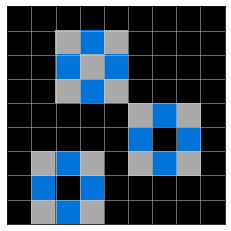

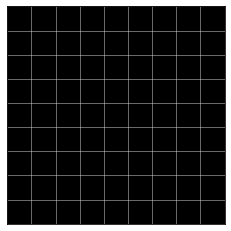

34800
Loss: 0.10064003616571426
Val loss: 3.788823366165161


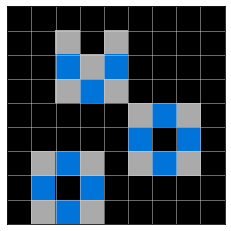

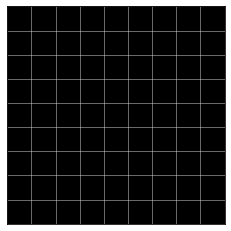

34900
Loss: 0.04604651778936386
Val loss: 1.3462408781051636


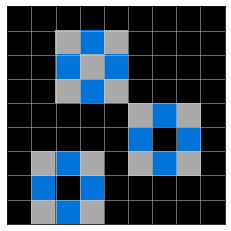

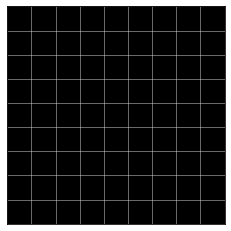

35000
Loss: 0.04483317956328392
Val loss: 2.159184217453003


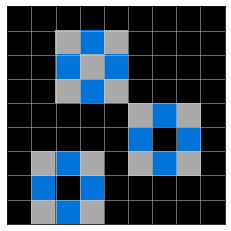

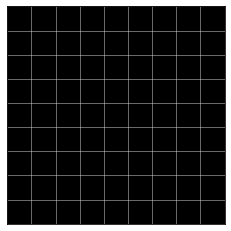

35100
Loss: 0.04561692476272583
Val loss: 0.8041895031929016


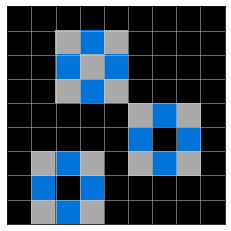

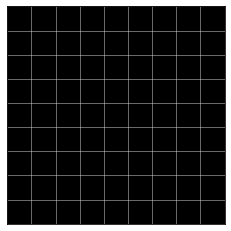

35200
Loss: 1.2797850370407104
Val loss: 2.3638362884521484


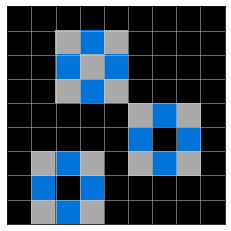

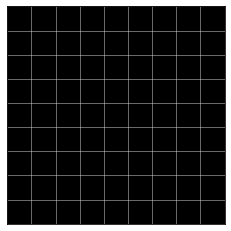

35300
Loss: 0.7052695155143738
Val loss: 2.4360415935516357


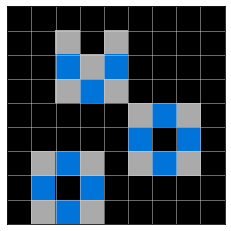

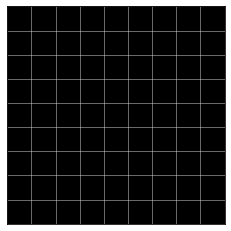

35400
Loss: 0.045667145401239395
Val loss: 0.05503067001700401


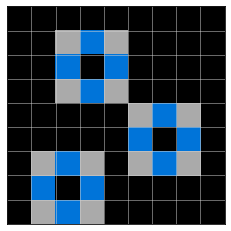

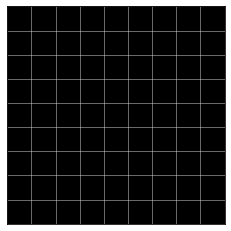

35500
Loss: 0.04635252431035042
Val loss: 0.7408041954040527


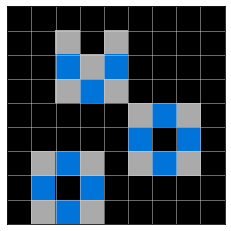

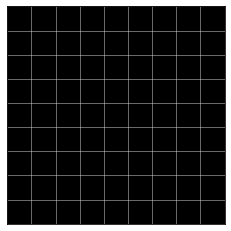

35600
Loss: 0.0727936252951622
Val loss: 1.1543926000595093


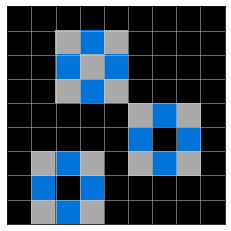

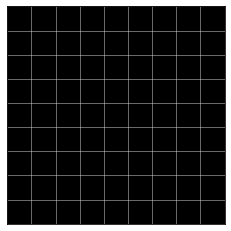

35700
Loss: 0.04421272873878479
Val loss: 0.5885197520256042


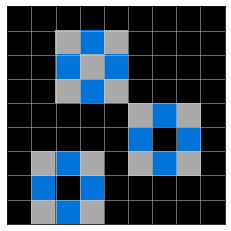

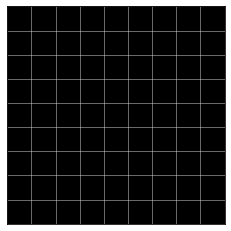

35800
Loss: 0.10283418744802475
Val loss: 0.3944863975048065


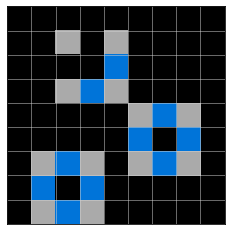

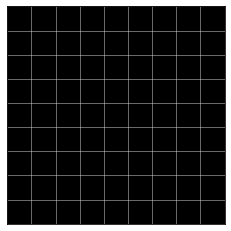

35900
Loss: 0.051115360110998154
Val loss: 0.8006163239479065


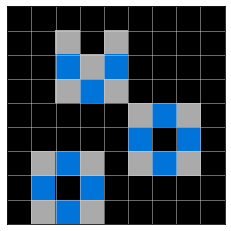

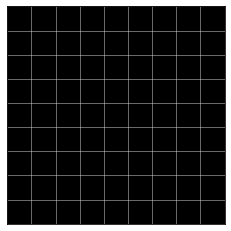

36000
Loss: 0.06154274567961693
Val loss: 1.5824767351150513


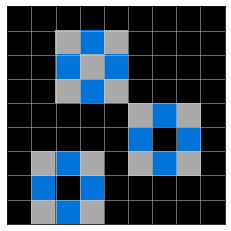

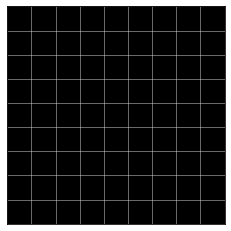

36100
Loss: 0.04572996869683266
Val loss: 0.08719906210899353


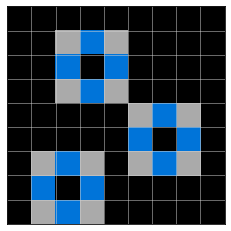

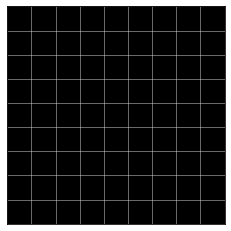

36200
Loss: 0.04803278669714928
Val loss: 0.3728710412979126


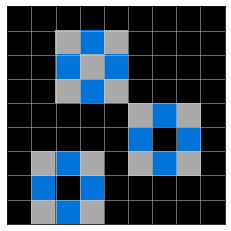

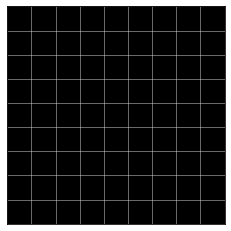

36300
Loss: 0.049940869212150574
Val loss: 0.1501459777355194


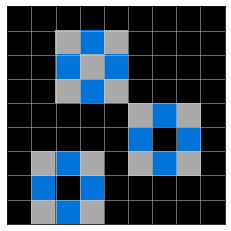

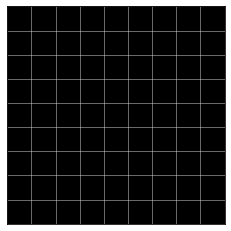

36400
Loss: 0.04650638625025749
Val loss: 0.2820999026298523


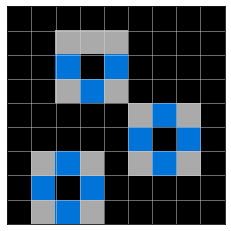

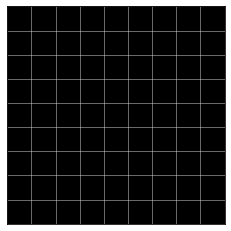

36500
Loss: 0.052452947944402695
Val loss: 2.1254639625549316


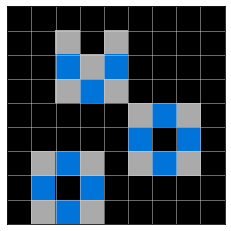

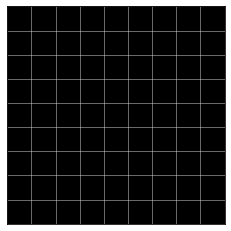

36600
Loss: 0.04927443340420723
Val loss: 0.5868493914604187


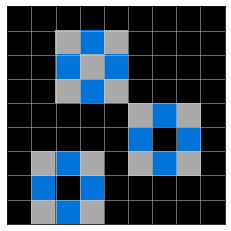

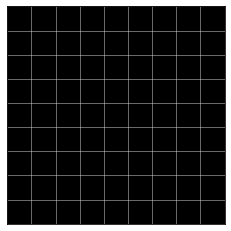

36700
Loss: 0.05919850990176201
Val loss: 1.4816957712173462


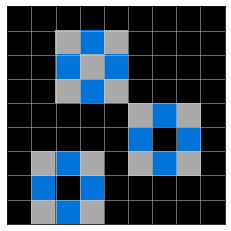

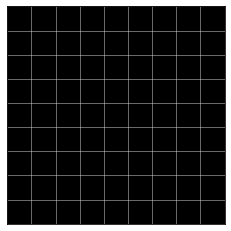

36800
Loss: 0.06153334677219391
Val loss: 0.36726129055023193


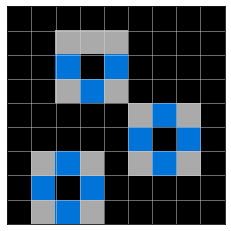

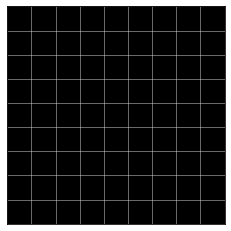

36900
Loss: 0.05528552830219269
Val loss: 1.271325945854187


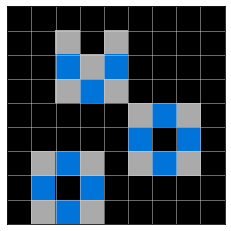

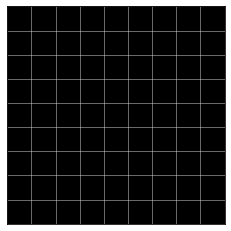

37000
Loss: 0.2249181568622589
Val loss: 0.18735718727111816


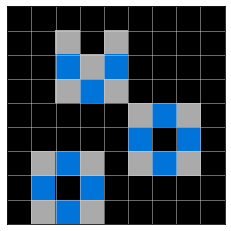

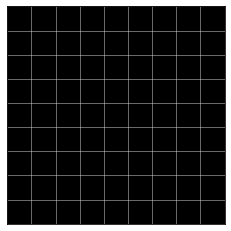

37100
Loss: 0.7640599608421326
Val loss: 0.07592112571001053


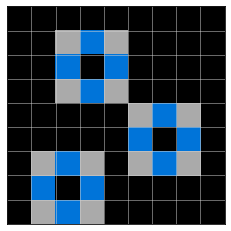

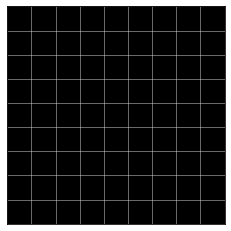

37200
Loss: 0.047065649181604385
Val loss: 1.5047518014907837


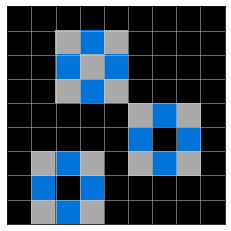

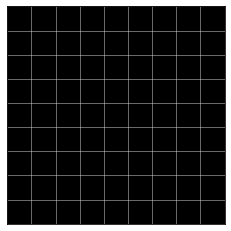

37300
Loss: 0.0985584482550621
Val loss: 0.8540752530097961


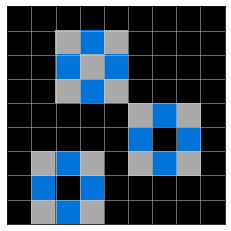

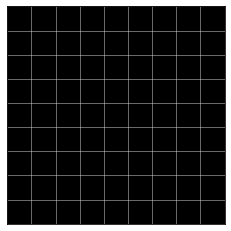

37400
Loss: 0.14733819663524628
Val loss: 1.4710745811462402


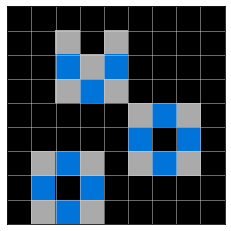

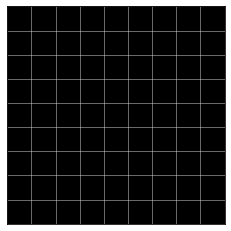

37500
Loss: 0.13911911845207214
Val loss: 0.762639045715332


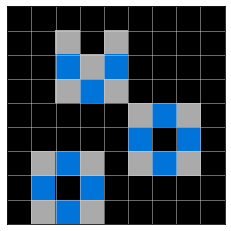

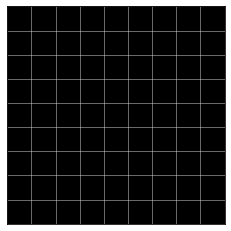

37600
Loss: 0.04390233755111694
Val loss: 0.08185125142335892


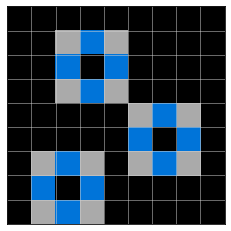

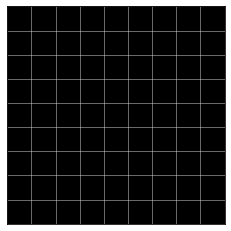

37700
Loss: 0.04650134593248367
Val loss: 0.06871501356363297


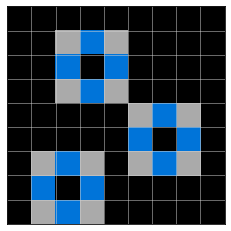

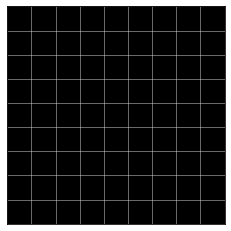

37800
Loss: 0.10005053132772446
Val loss: 0.305122047662735


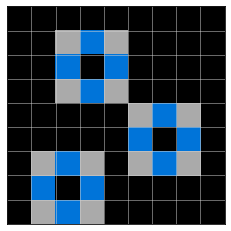

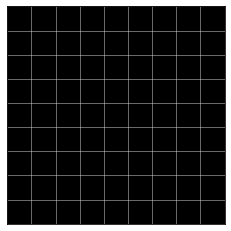

37900
Loss: 0.05451265349984169
Val loss: 0.5006827116012573


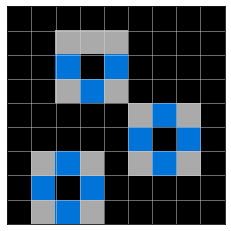

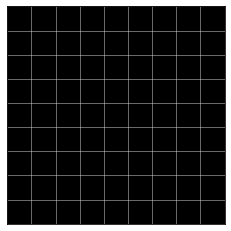

38000
Loss: 0.13739748299121857
Val loss: 0.877652108669281


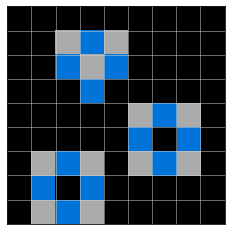

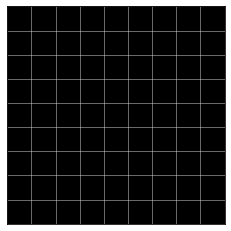

38100
Loss: 0.13681747019290924
Val loss: 1.8854402303695679


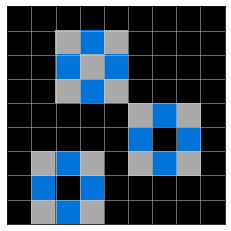

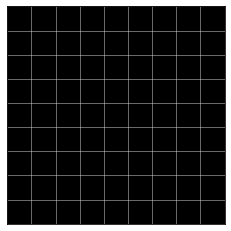

38200
Loss: 0.08399324864149094
Val loss: 0.04707128927111626


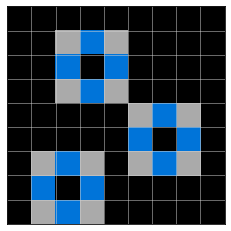

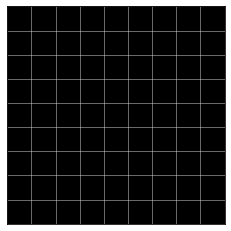

38300
Loss: 0.11728624999523163
Val loss: 0.2795742154121399


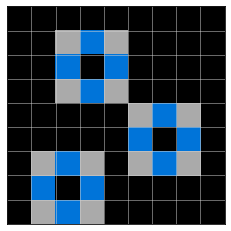

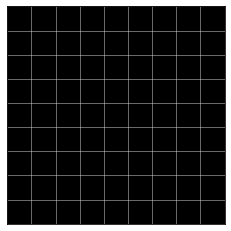

38400
Loss: 0.0975998193025589
Val loss: 0.3367791175842285


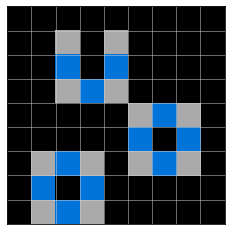

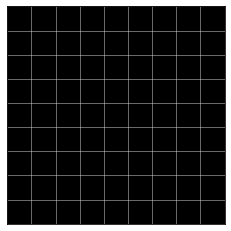

38500
Loss: 0.2640078663825989
Val loss: 0.519638180732727


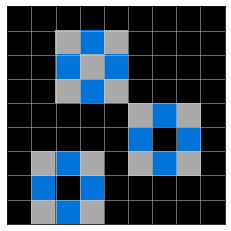

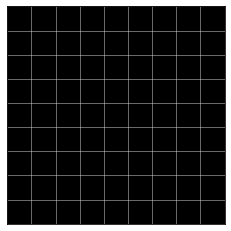

38600
Loss: 0.10579037666320801
Val loss: 0.5131903886795044


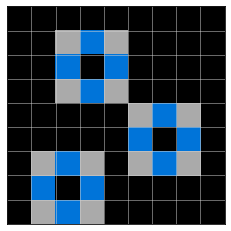

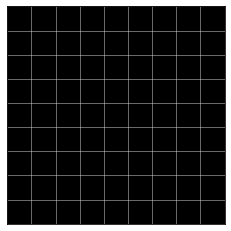

38700
Loss: 0.4007968306541443
Val loss: 0.11060938239097595


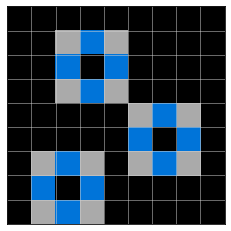

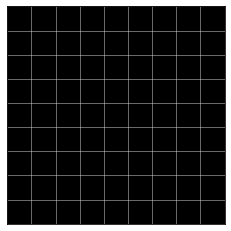

38800
Loss: 0.04809946194291115
Val loss: 0.8714420199394226


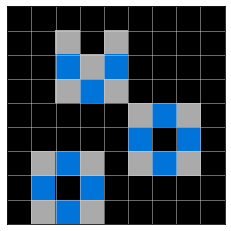

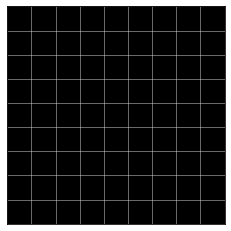

38900
Loss: 0.10923567414283752
Val loss: 0.2223789095878601


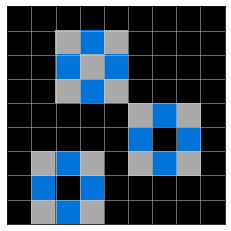

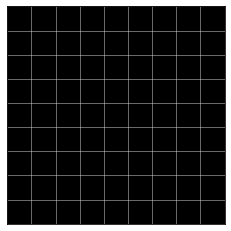

39000
Loss: 0.14849556982517242
Val loss: 0.0937894955277443


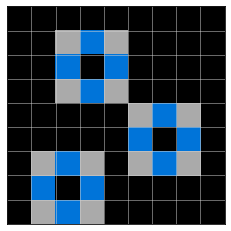

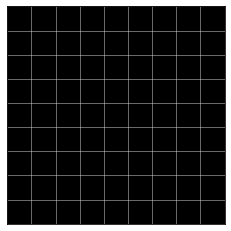

39100
Loss: 0.08759775757789612
Val loss: 0.5496246814727783


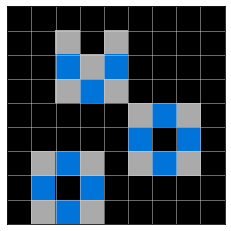

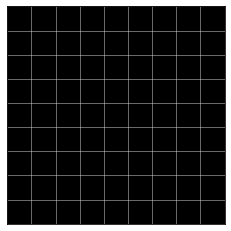

39200
Loss: 0.05053418502211571
Val loss: 0.7297701835632324


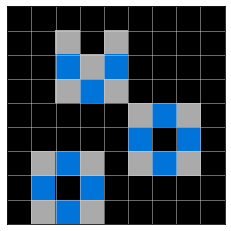

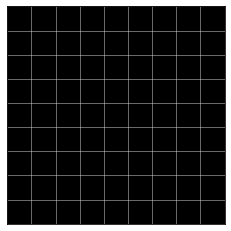

39300
Loss: 0.051220059394836426
Val loss: 1.6391547918319702


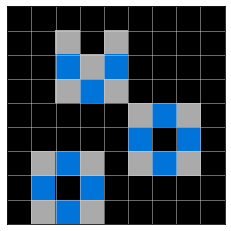

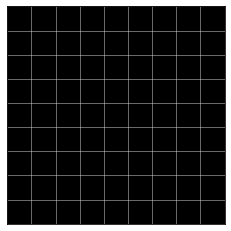

39400
Loss: 0.05079950764775276
Val loss: 0.24611477553844452


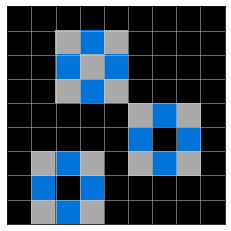

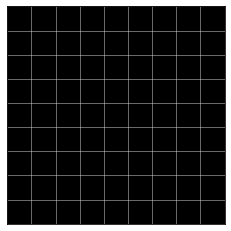

39500
Loss: 0.04693984240293503
Val loss: 0.19817429780960083


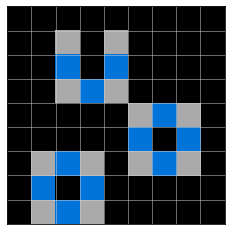

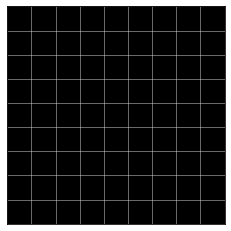

39600
Loss: 0.16019728779792786
Val loss: 0.46615204215049744


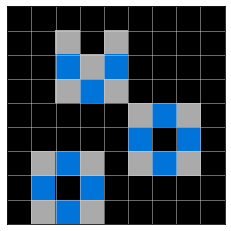

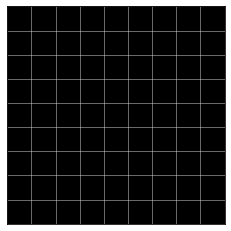

39700
Loss: 0.14186133444309235
Val loss: 0.6936547756195068


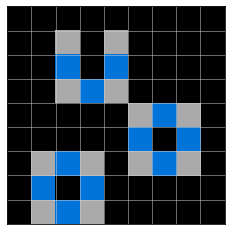

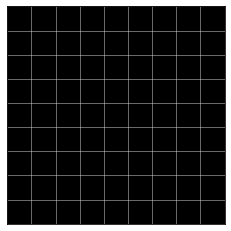

39800
Loss: 0.10143998265266418
Val loss: 0.33858799934387207


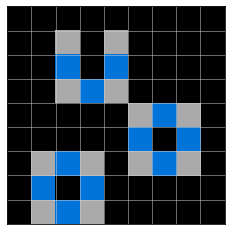

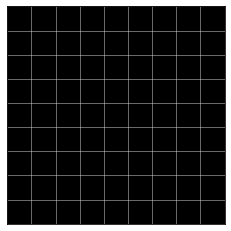

39900
Loss: 0.13695591688156128
Val loss: 0.2804872393608093


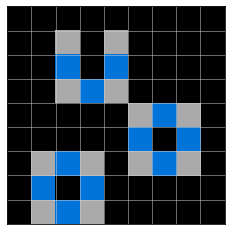

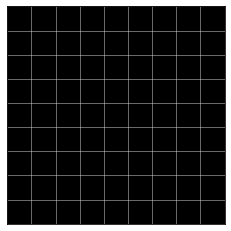

40000
Loss: 0.04649733006954193
Val loss: 0.3888830244541168


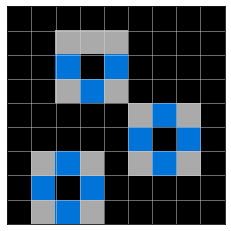

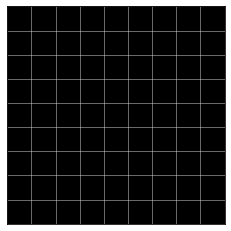

40100
Loss: 0.7936306595802307
Val loss: 0.04513581469655037


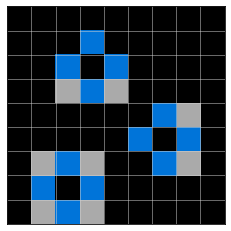

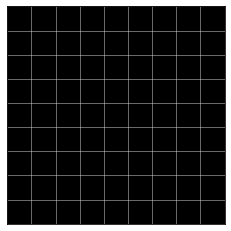

40200
Loss: 0.048657551407814026
Val loss: 0.7563582062721252


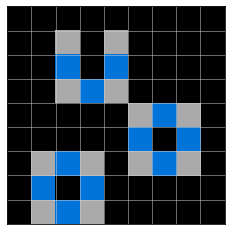

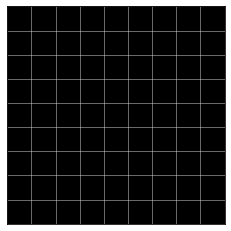

40300
Loss: 0.6052197813987732
Val loss: 0.7708113789558411


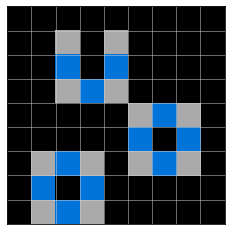

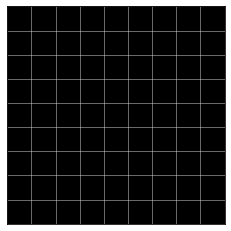

40400
Loss: 0.08948956429958344
Val loss: 0.05421094968914986


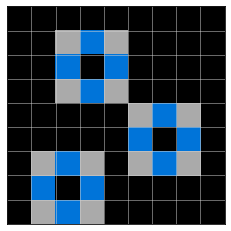

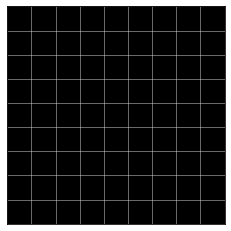

40500
Loss: 0.10239192098379135
Val loss: 0.7474543452262878


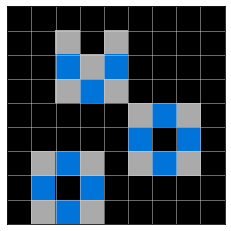

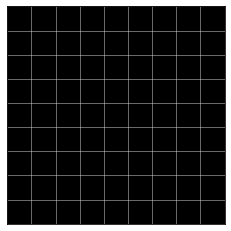

40600
Loss: 0.04744347184896469
Val loss: 0.5228692293167114


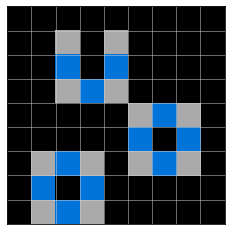

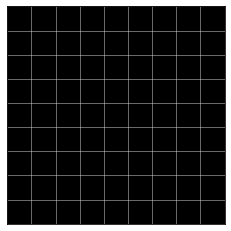

40700
Loss: 0.17445626854896545
Val loss: 0.3114367127418518


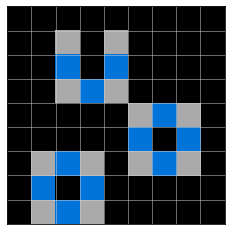

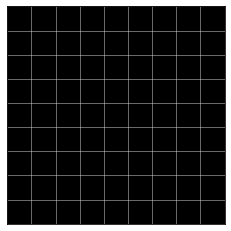

40800
Loss: 0.04634407162666321
Val loss: 0.6265683174133301


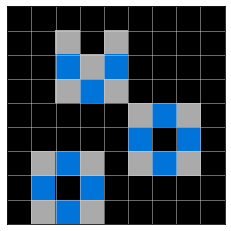

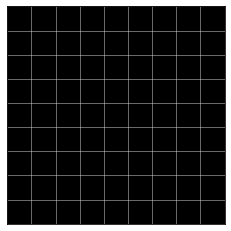

40900
Loss: 0.04684273526072502
Val loss: 0.34445294737815857


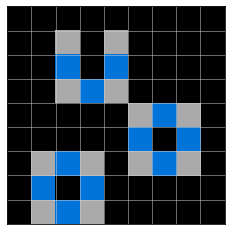

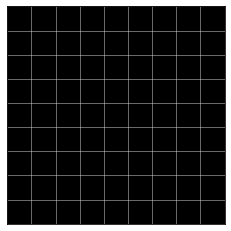

41000
Loss: 0.04666564613580704
Val loss: 0.28538525104522705


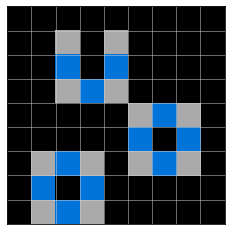

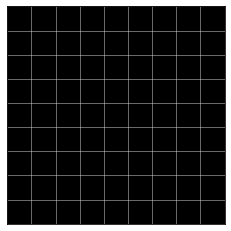

41100
Loss: 0.12619349360466003
Val loss: 8.897588729858398


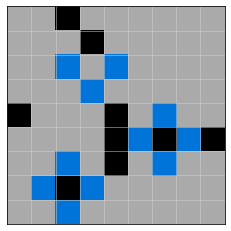

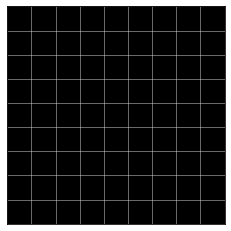

41200
Loss: 0.04656892642378807
Val loss: 0.7034847736358643


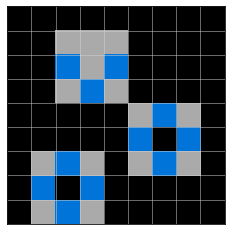

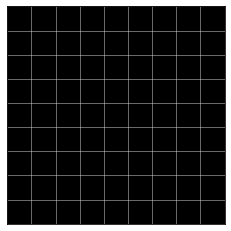

41300
Loss: 0.529241681098938
Val loss: 0.7364129424095154


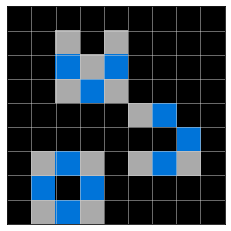

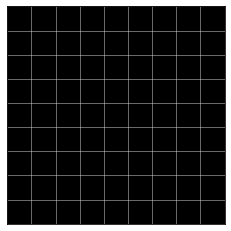

41400
Loss: 0.17576245963573456
Val loss: 0.23698680102825165


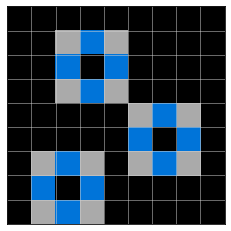

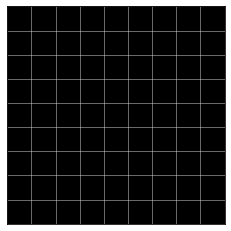

41500
Loss: 0.10667796432971954
Val loss: 2.5390186309814453


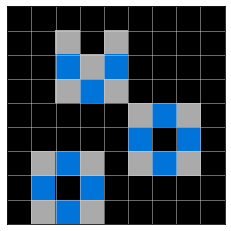

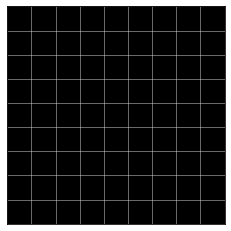

41600
Loss: 0.05108511447906494
Val loss: 0.8274591565132141


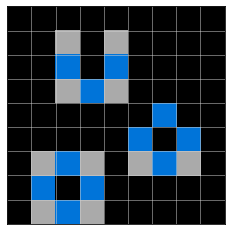

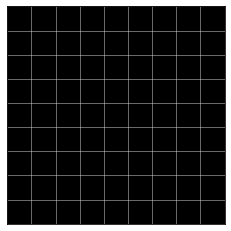

41700
Loss: 0.04630887880921364
Val loss: 1.072891116142273


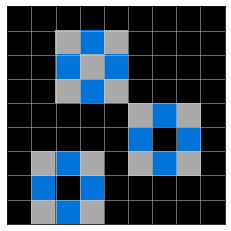

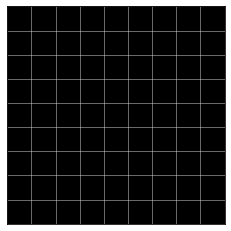

41800
Loss: 0.04458535462617874
Val loss: 0.7075955867767334


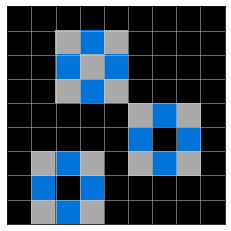

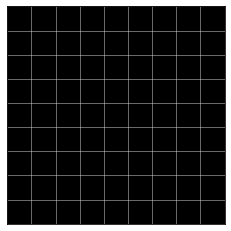

41900
Loss: 0.09674053639173508
Val loss: 1.0613832473754883


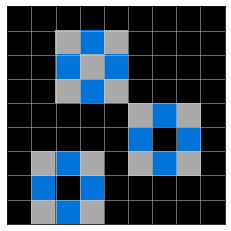

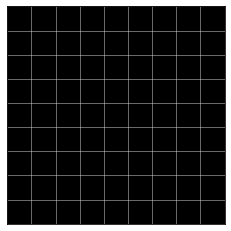

42000
Loss: 0.48291993141174316
Val loss: 0.7513155341148376


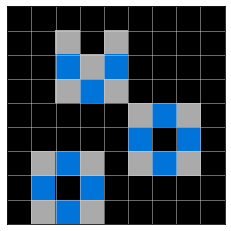

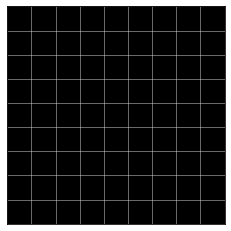

42100
Loss: 0.04570522531867027
Val loss: 1.9559158086776733


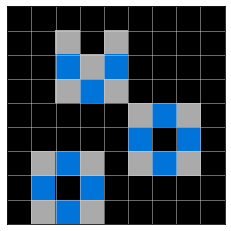

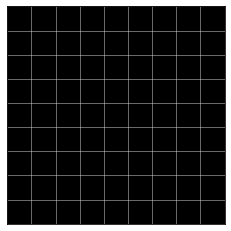

42200
Loss: 0.09965170919895172
Val loss: 0.1390712410211563


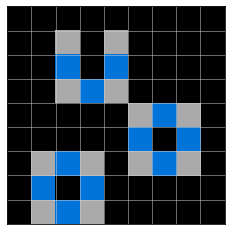

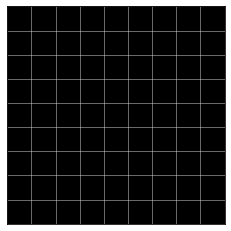

42300
Loss: 0.4607503116130829
Val loss: 0.30096936225891113


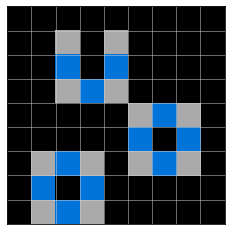

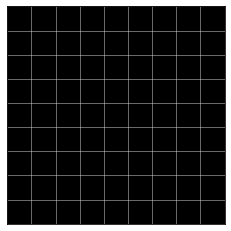

42400
Loss: 0.10358191281557083
Val loss: 0.26492878794670105


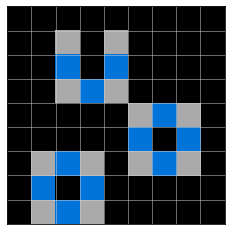

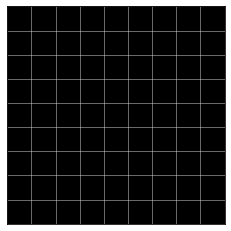

42500
Loss: 0.17997100949287415
Val loss: 0.1752914935350418


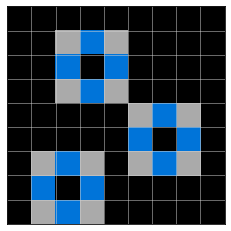

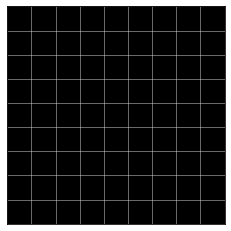

42600
Loss: 0.07068241387605667
Val loss: 0.2302710860967636


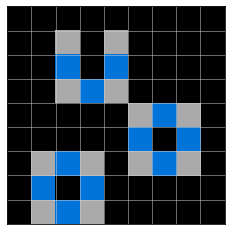

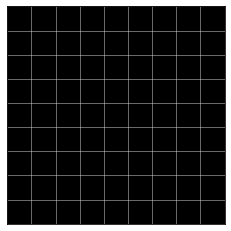

42700
Loss: 0.04730439931154251
Val loss: 0.06312192976474762


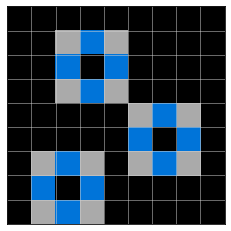

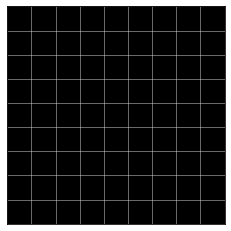

42800
Loss: 0.17951425909996033
Val loss: 0.6308827996253967


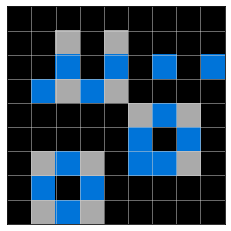

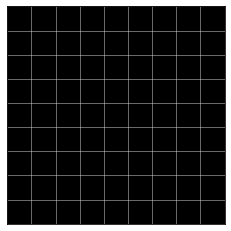

42900
Loss: 0.13001663982868195
Val loss: 0.31324106454849243


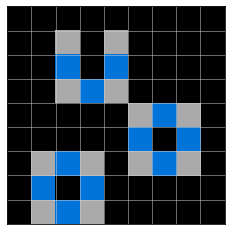

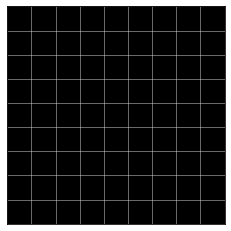

43000
Loss: 0.1133512407541275
Val loss: 0.3547329902648926


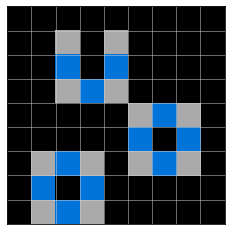

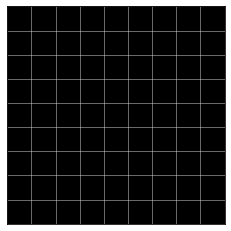

43100
Loss: 0.046831391751766205
Val loss: 0.07272560894489288


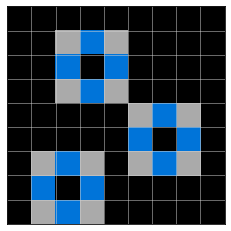

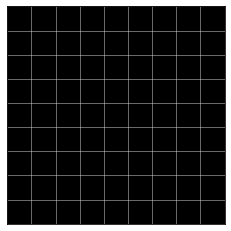

43200
Loss: 0.09599991142749786
Val loss: 0.5266551971435547


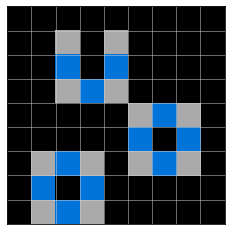

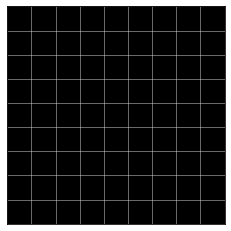

43300
Loss: 0.2876308262348175
Val loss: 0.07078395783901215


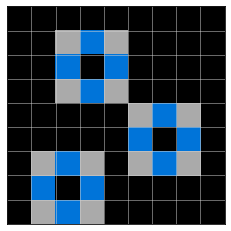

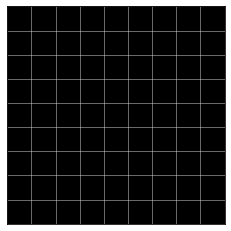

43400
Loss: 0.2357867956161499
Val loss: 0.4354654550552368


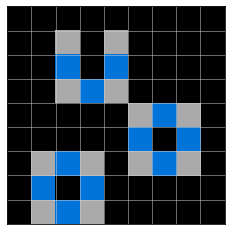

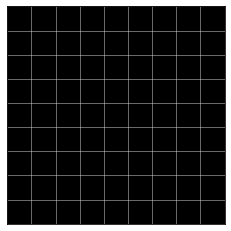

43500
Loss: 0.04832452908158302
Val loss: 0.35901936888694763


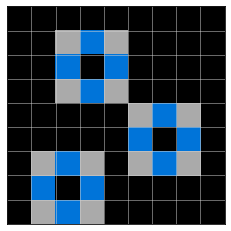

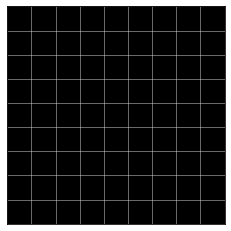

43600
Loss: 0.1593082696199417
Val loss: 0.3048303723335266


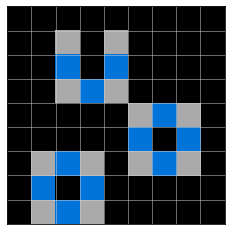

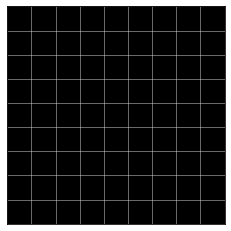

43700
Loss: 0.045503173023462296
Val loss: 0.5713955760002136


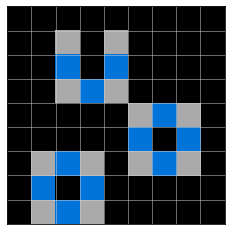

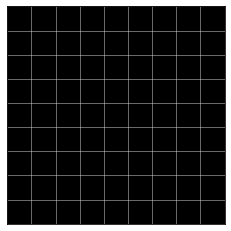

43800
Loss: 0.06076708436012268
Val loss: 0.37333643436431885


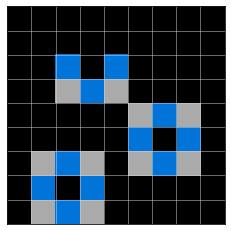

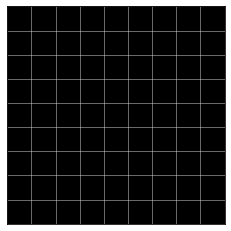

43900
Loss: 0.13903950154781342
Val loss: 0.5377554297447205


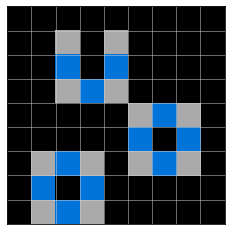

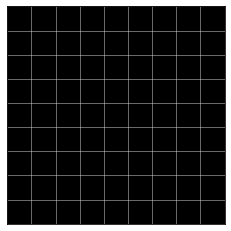

44000
Loss: 0.04895266517996788
Val loss: 0.3448495864868164


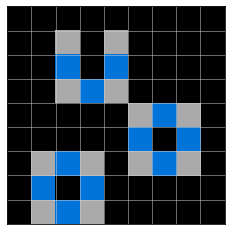

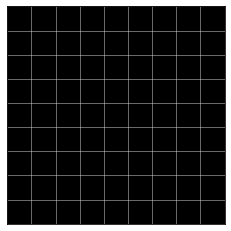

44100
Loss: 0.07970239222049713
Val loss: 0.6750909686088562


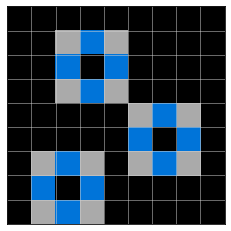

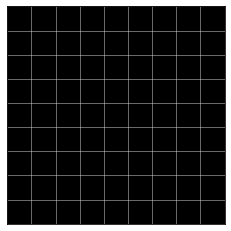

44200
Loss: 0.10371870547533035
Val loss: 0.39382603764533997


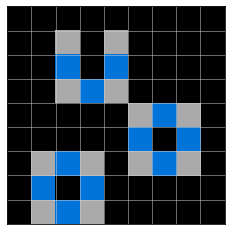

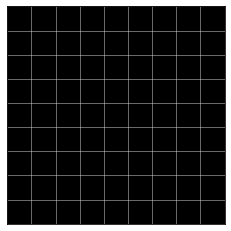

44300
Loss: 0.05287216603755951
Val loss: 0.3947397768497467


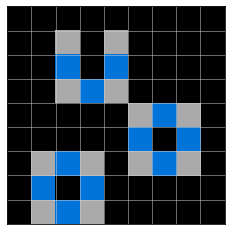

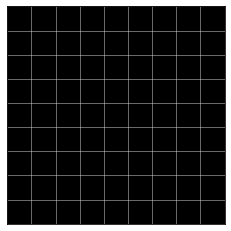

44400
Loss: 0.10428529232740402
Val loss: 0.31670427322387695


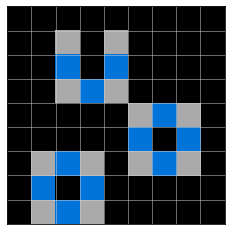

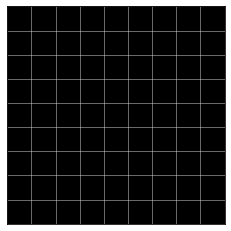

44500
Loss: 0.0507010780274868
Val loss: 1.80784273147583


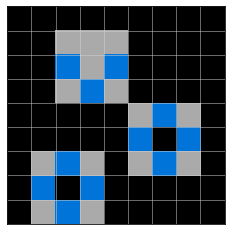

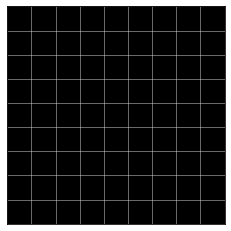

44600
Loss: 0.16367094218730927
Val loss: 0.056439172476530075


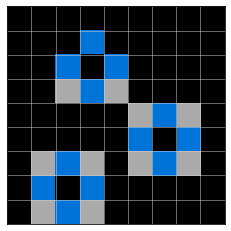

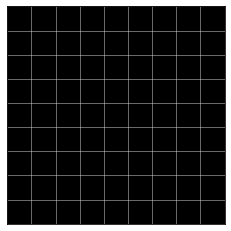

44700
Loss: 0.2296294867992401
Val loss: 0.41388753056526184


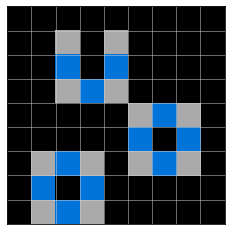

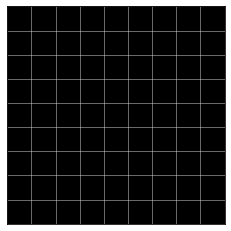

44800
Loss: 0.04548051208257675
Val loss: 0.38395652174949646


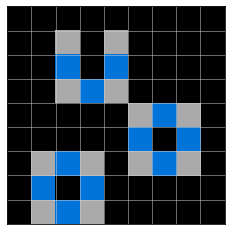

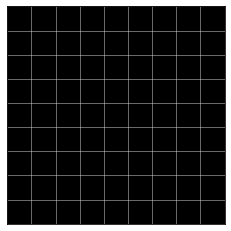

44900
Loss: 0.16788241267204285
Val loss: 0.45089301466941833


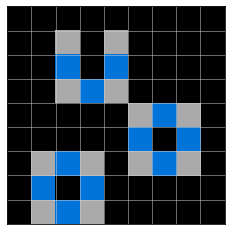

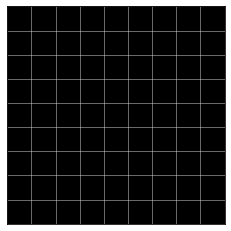

45000
Loss: 0.15836240351200104
Val loss: 1.8991799354553223


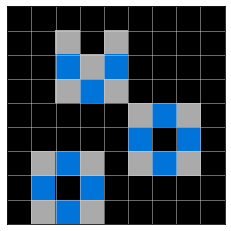

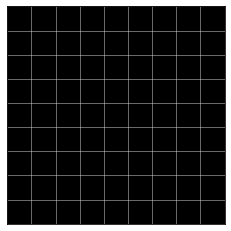

45100
Loss: 0.05071922764182091
Val loss: 0.30883023142814636


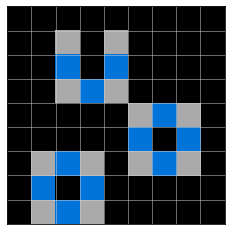

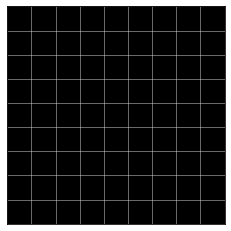

45200
Loss: 0.04882688447833061
Val loss: 1.4380208253860474


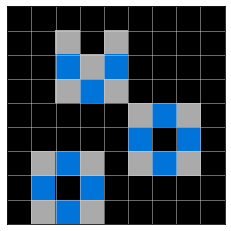

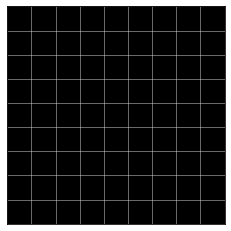

45300
Loss: 0.3349898159503937
Val loss: 0.6053134799003601


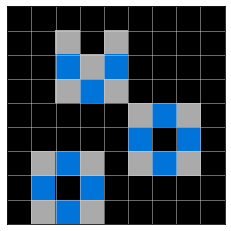

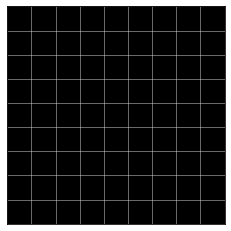

45400
Loss: 0.11338213831186295
Val loss: 1.9263559579849243


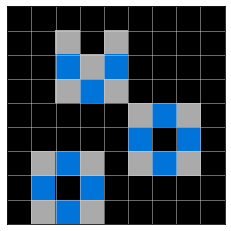

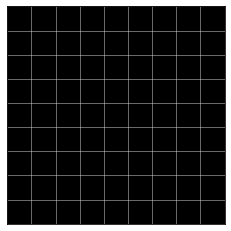

45500
Loss: 0.5265244245529175
Val loss: 0.6219229698181152


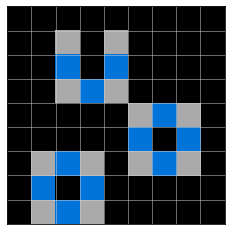

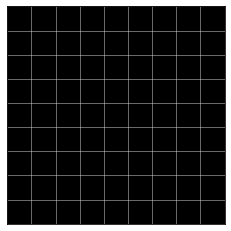

45600
Loss: 0.20663346350193024
Val loss: 0.4430798292160034


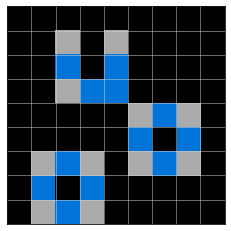

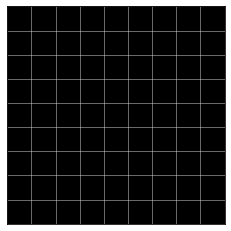

45700
Loss: 0.12444872409105301
Val loss: 1.8109172582626343


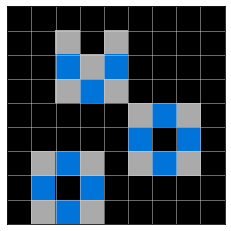

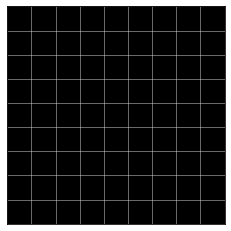

45800
Loss: 0.1841716766357422
Val loss: 2.605238914489746


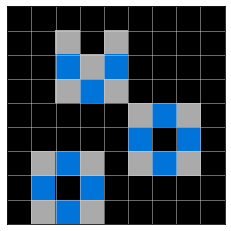

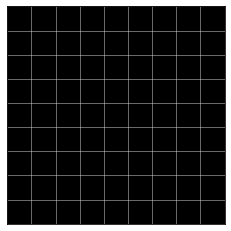

45900
Loss: 0.06292326748371124
Val loss: 2.587007999420166


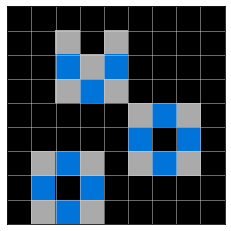

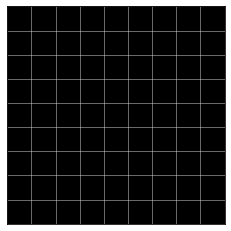

46000
Loss: 0.051273178309202194
Val loss: 0.9087448120117188


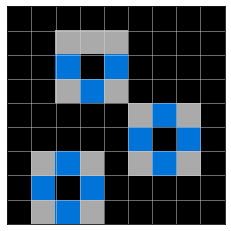

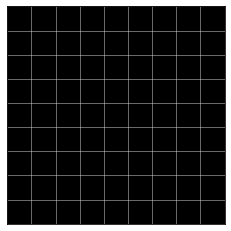

46100
Loss: 0.2430010586977005
Val loss: 0.34240975975990295


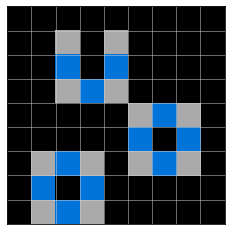

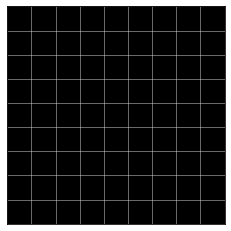

46200
Loss: 0.07501901686191559
Val loss: 0.7484303116798401


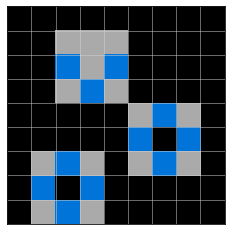

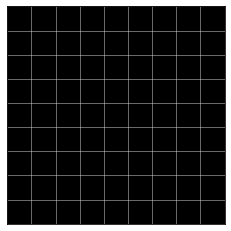

46300
Loss: 0.05374827980995178
Val loss: 0.5562008023262024


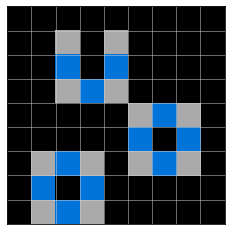

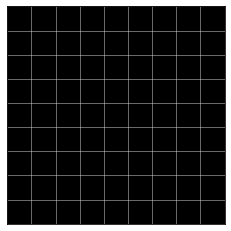

46400
Loss: 0.3000081777572632
Val loss: 0.3978980481624603


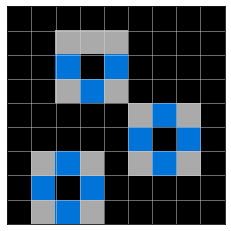

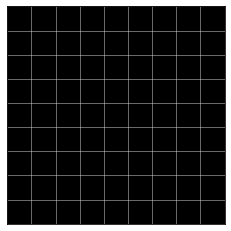

46500
Loss: 0.10538388043642044
Val loss: 0.4297485649585724


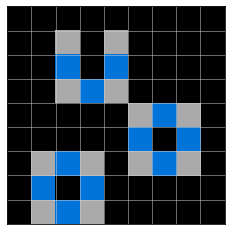

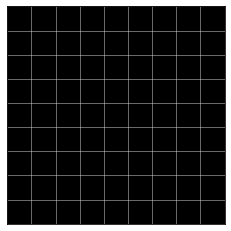

46600
Loss: 0.05028536915779114
Val loss: 1.4105201959609985


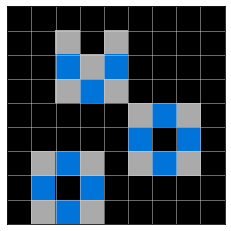

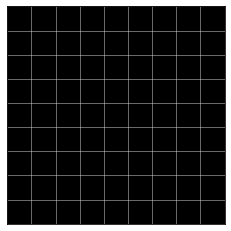

46700
Loss: 0.050375424325466156
Val loss: 0.6343898177146912


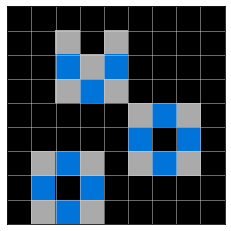

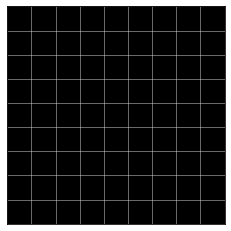

46800
Loss: 0.08043847978115082
Val loss: 1.5274447202682495


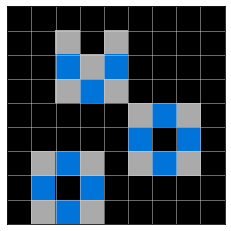

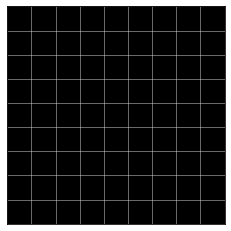

46900
Loss: 0.08076336234807968
Val loss: 0.34768548607826233


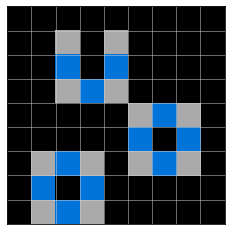

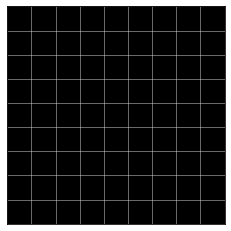

47000
Loss: 0.05095411837100983
Val loss: 0.3606143295764923


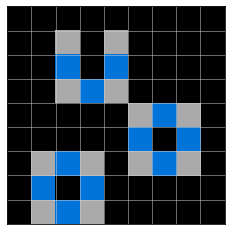

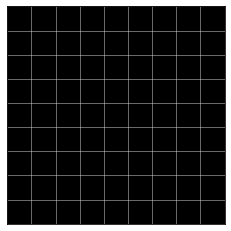

47100
Loss: 0.050117816776037216
Val loss: 1.2366142272949219


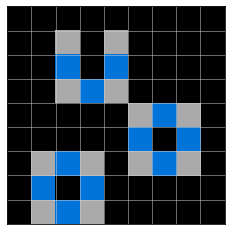

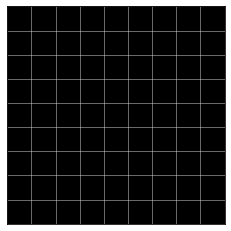

47200
Loss: 0.05083965137600899
Val loss: 0.24368947744369507


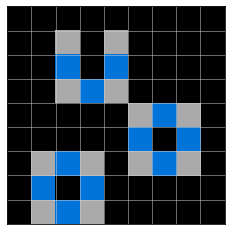

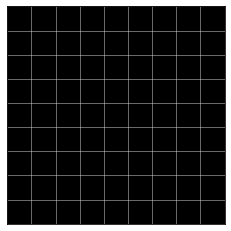

47300
Loss: 0.12424887716770172
Val loss: 3.204758405685425


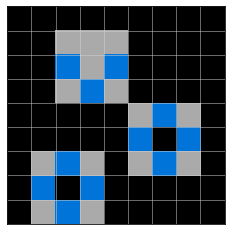

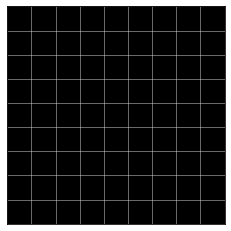

47400
Loss: 0.14461682736873627
Val loss: 3.6328907012939453


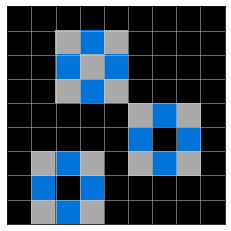

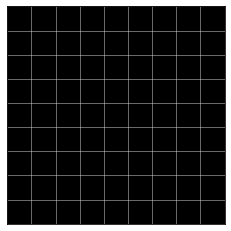

47500
Loss: 0.19432982802391052
Val loss: 2.8559763431549072


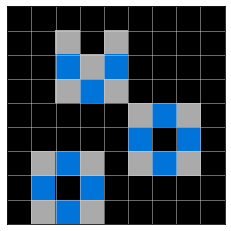

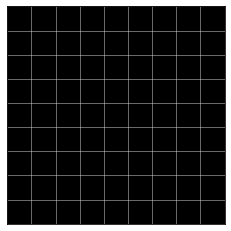

47600
Loss: 0.2569212019443512
Val loss: 0.45001593232154846


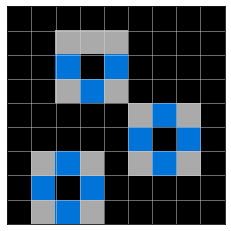

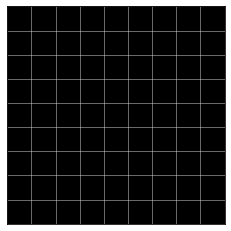

47700
Loss: 0.10820865631103516
Val loss: 3.6800506114959717


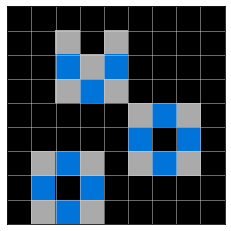

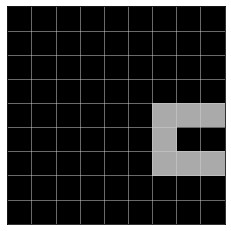

47800
Loss: 0.05047757551074028
Val loss: 1.0363702774047852


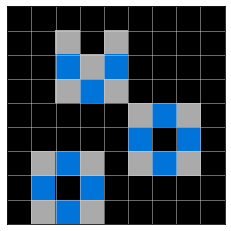

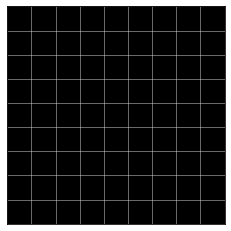

47900
Loss: 0.05108782276511192
Val loss: 2.4476027488708496


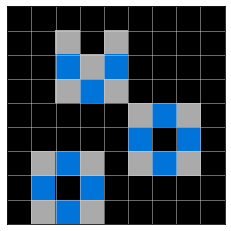

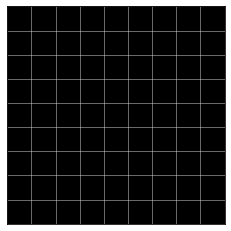

48000
Loss: 0.0519849918782711
Val loss: 2.0834426879882812


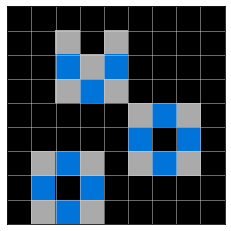

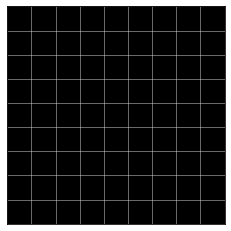

48100
Loss: 0.05142677575349808
Val loss: 2.627199649810791


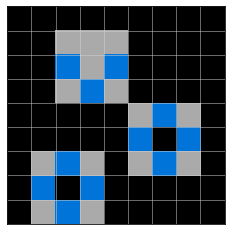

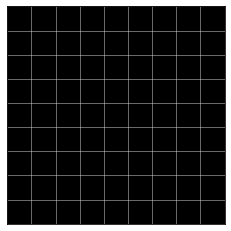

48200
Loss: 0.10612040013074875
Val loss: 4.840358257293701


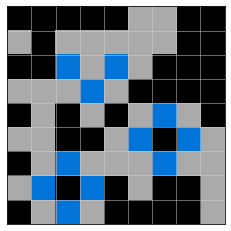

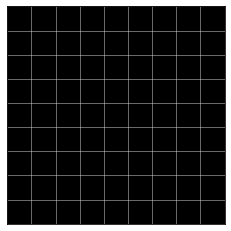

48300
Loss: 0.07320444285869598
Val loss: 4.2439351081848145


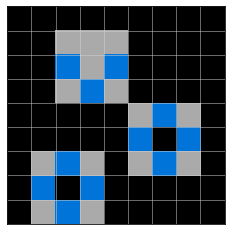

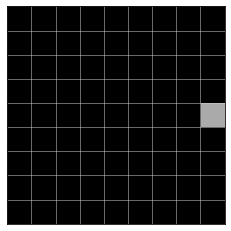

48400
Loss: 0.21500979363918304
Val loss: 2.39412260055542


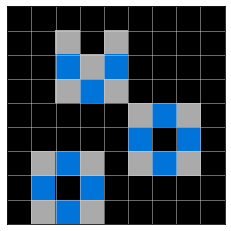

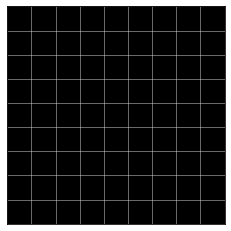

48500
Loss: 0.1295190304517746
Val loss: 0.9577389359474182


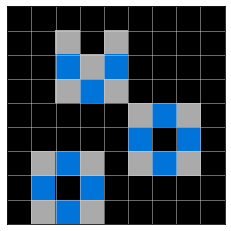

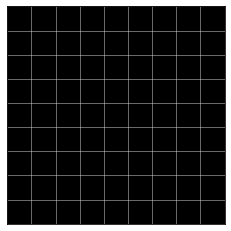

48600
Loss: 0.06682876497507095
Val loss: 1.7079263925552368


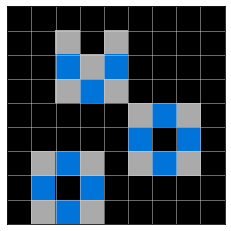

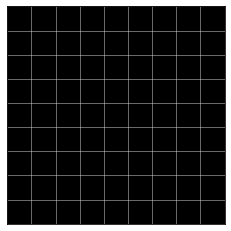

48700
Loss: 0.05589192733168602
Val loss: 2.655210256576538


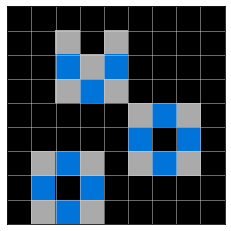

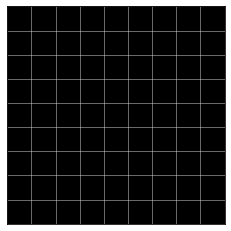

48800
Loss: 0.10538958013057709
Val loss: 4.1751203536987305


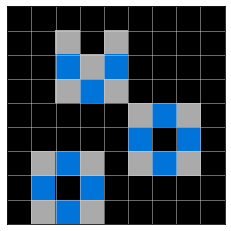

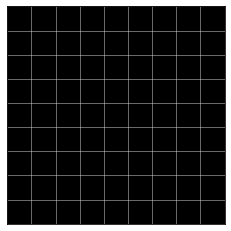

48900
Loss: 0.060758329927921295
Val loss: 1.453191876411438


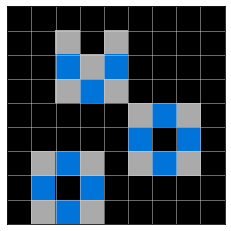

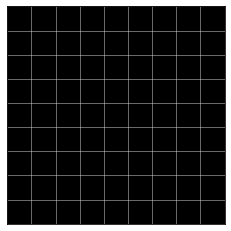

49000
Loss: 0.05639626085758209
Val loss: 0.9675605893135071


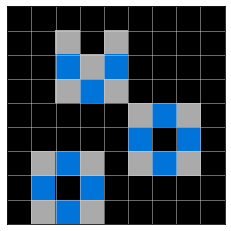

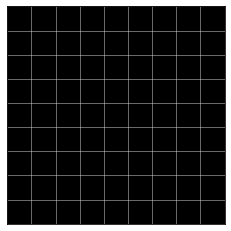

49100
Loss: 0.05784676596522331
Val loss: 3.1154229640960693


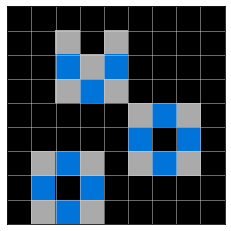

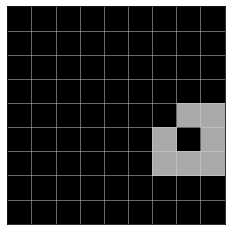

49200
Loss: 0.06246502324938774
Val loss: 4.349509239196777


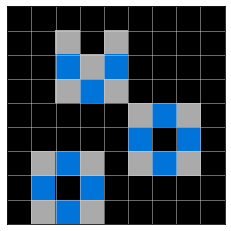

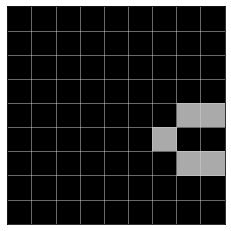

49300
Loss: 0.8031635284423828
Val loss: 2.710068941116333


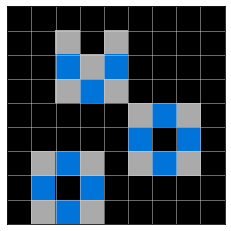

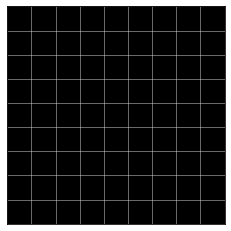

49400
Loss: 0.058749884366989136
Val loss: 2.6472814083099365


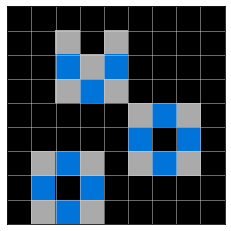

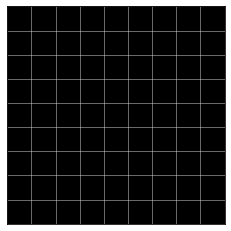

49500
Loss: 0.5021843910217285
Val loss: 0.5159140229225159


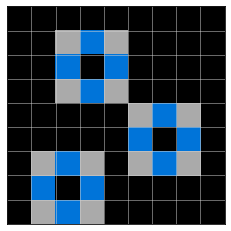

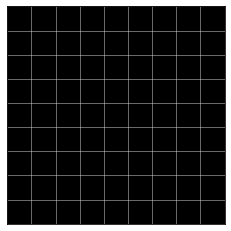

49600
Loss: 0.05999055877327919
Val loss: 3.063002586364746


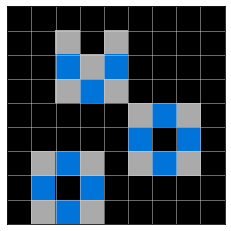

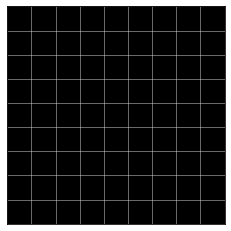

49700
Loss: 0.08446024358272552
Val loss: 3.7123310565948486


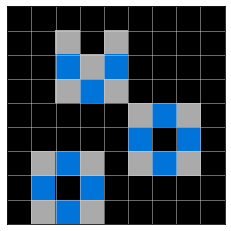

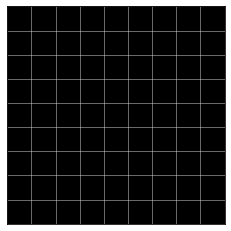

49800
Loss: 0.06179780513048172
Val loss: 3.0458061695098877


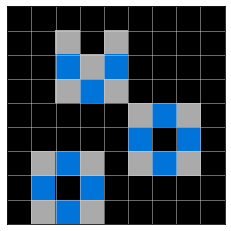

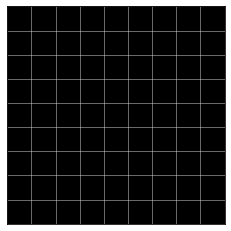

49900
Loss: 0.14449894428253174
Val loss: 0.30285724997520447


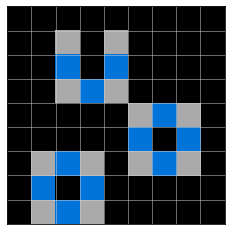

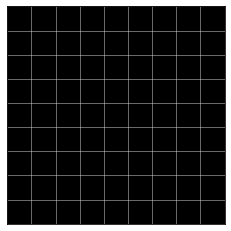

50000
Loss: 1.063875436782837
Val loss: 1.238674283027649


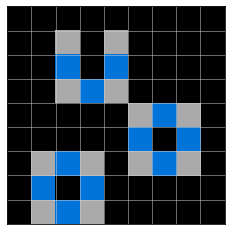

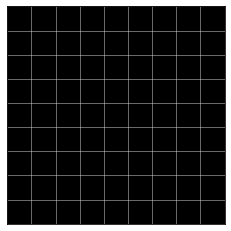

In [88]:
# test_img = np.array(train_tasks[task_id]['train'][0]['input'])
train_img = np.array(train_tasks[task_id]['train'][0]['input'])
train_img_rgb = get_img_rgb(train_img)
test_img = np.array(train_tasks[task_id]['test'][0]['input'])
test_img_rgb = get_img_rgb(test_img)

X_testing = np.array(
    [get_cnn_img(test_img_rgb, r, c) for r in range(len(test_img_rgb)) for c in range(len(test_img_rgb[0]))])
X_testing_color = test_img_rgb.reshape(-1, test_img_rgb.shape[-1])

X_train_for_test = np.array(
    [get_cnn_img(train_img_rgb, r, c) for r in range(len(train_img_rgb)) for c in range(len(train_img_rgb[0]))])
X_train_for_test_color = train_img_rgb.reshape(-1, train_img_rgb.shape[-1])

models = []

for i in range(500):
    print((i+1)*100)
#     history = model.fit([X_train, X_train_color], y_train, epochs=100,
#                         class_weight=cw,
#                         verbose=False)
    history = model.fit([X_train, X_train_color], y_train,
                        validation_data=([X_valid, X_valid_color], y_valid),
                        epochs=100,
                        class_weight=cw,
                        verbose=False)
    
    print('Loss:', history.history['loss'][-1])
    print('Val loss:', history.history['val_loss'][-1])
    print('Acc:', history.history['accuracy'][-1])
    print('Val acc:', history.history['val_accuracy'][-1])
    models.append(keras.models.clone_model(model))
    
    # pred train
    y_pred = model.predict([X_train_for_test, X_train_for_test_color]).argmax(axis=1)
    img_pred = y_pred.copy()
    img_pred.shape = train_img.shape
    plot_image(img_pred)
    
    # pred test
    y_pred = model.predict([X_testing, X_testing_color]).argmax(axis=1)
    img_pred = y_pred.copy()
    img_pred.shape = test_img.shape
    plot_image(img_pred)



# model.fit([X_train, X_train_color], y_train, epochs=100, class_weight=tmp)
# model.fit([X_train, X_train_color], y_train,
#           validation_data=([X_valid, X_valid_color], y_valid),
#           epochs=1000,
#           class_weight=tmp)

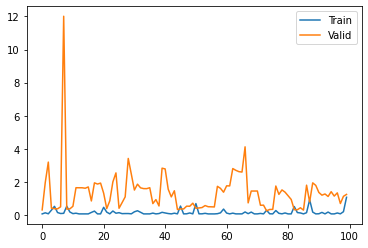

In [89]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.show()

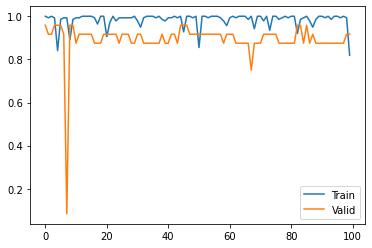

In [90]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.show()

100


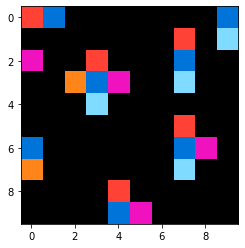

200


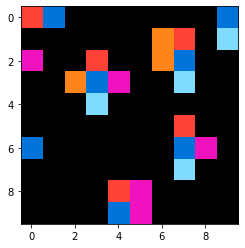

300


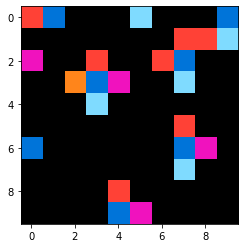

400


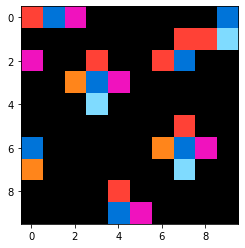

500


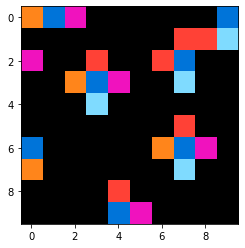

600


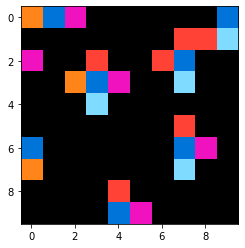

700


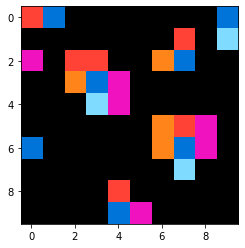

800


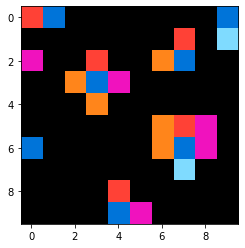

900


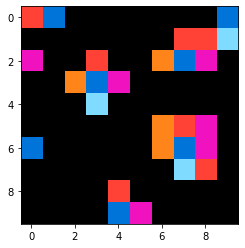

1000


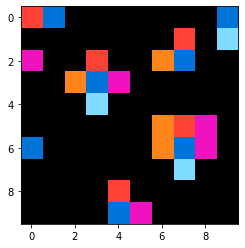

1100


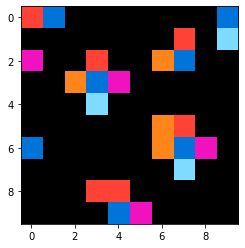

1200


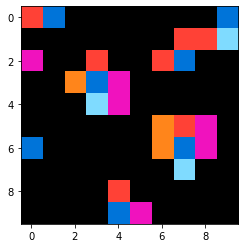

1300


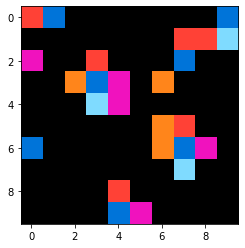

1400


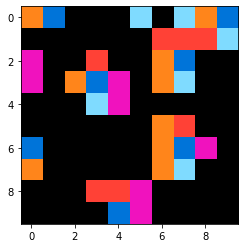

1500


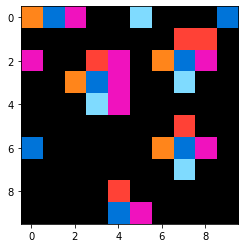

1600


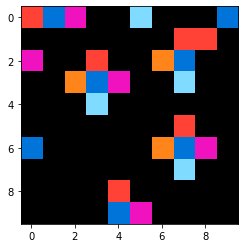

1700


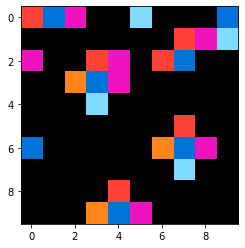

1800


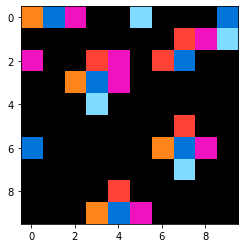

1900


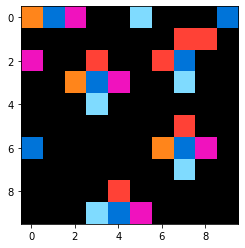

2000


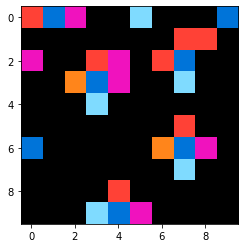

2100


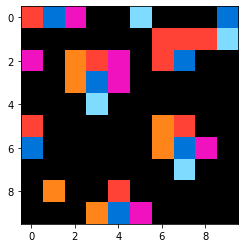

2200


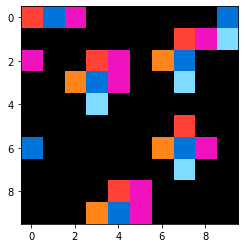

2300


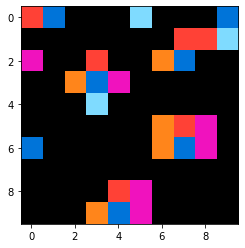

2400


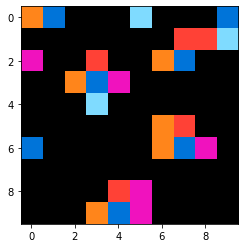

2500


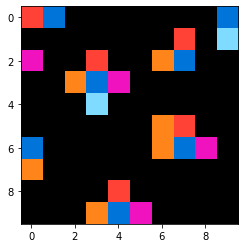

2600


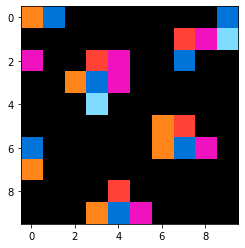

2700


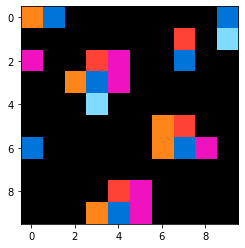

2800


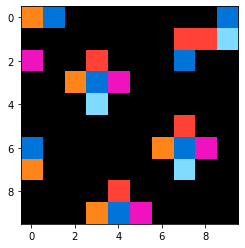

2900


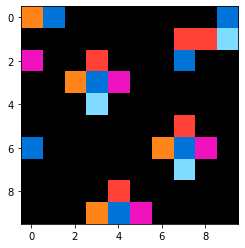

3000


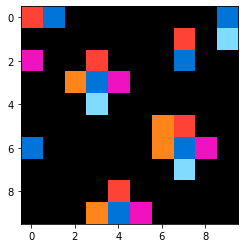

3100


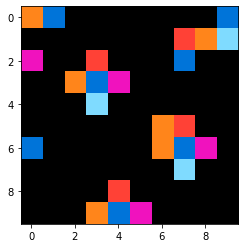

3200


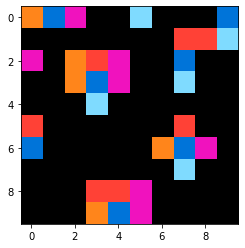

3300


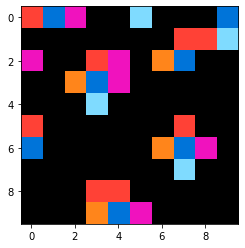

3400


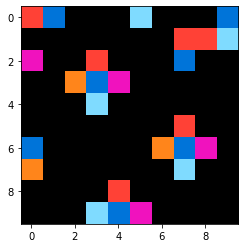

3500


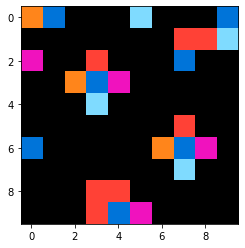

3600


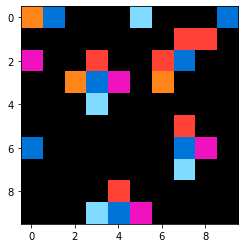

3700


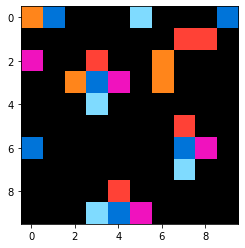

3800


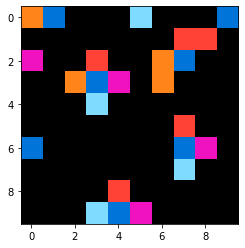

3900


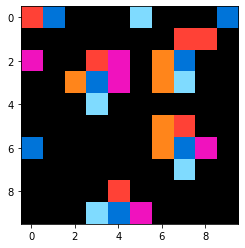

4000


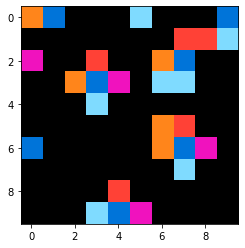

4100


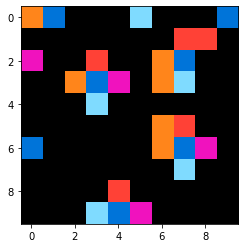

4200


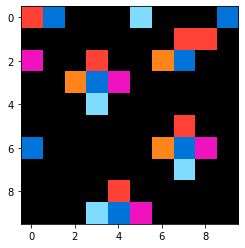

4300


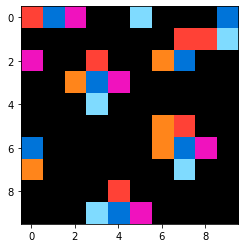

4400


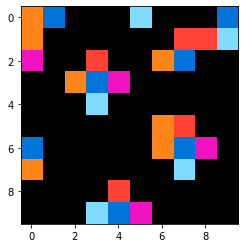

4500


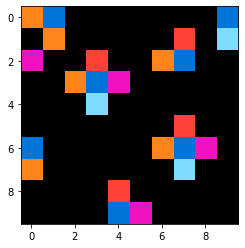

4600


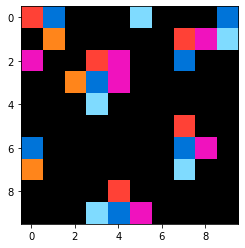

4700


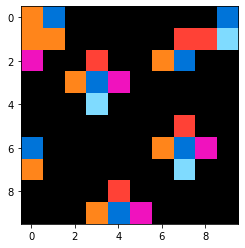

4800


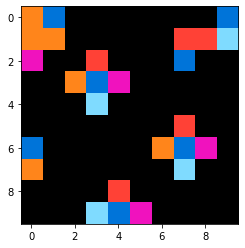

4900


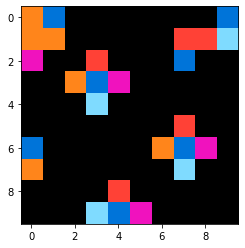

5000


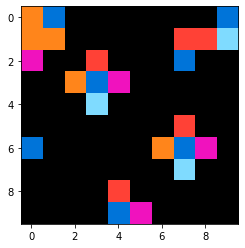

5100


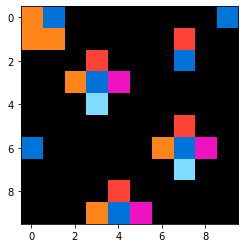

5200


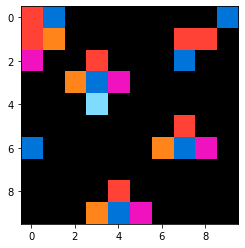

5300


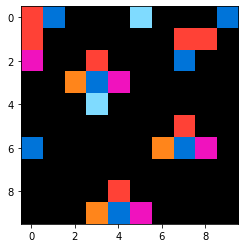

5400


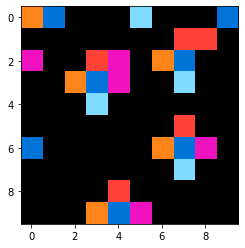

5500


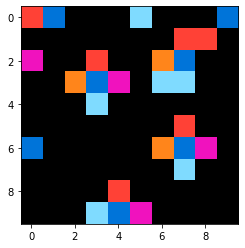

5600


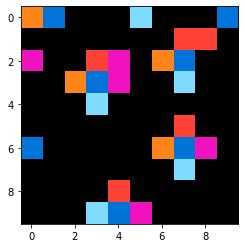

5700


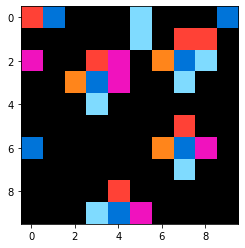

5800


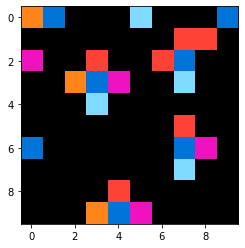

5900


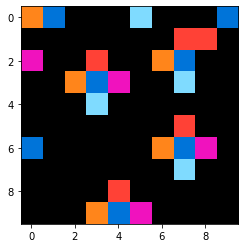

6000


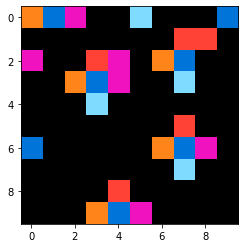

6100


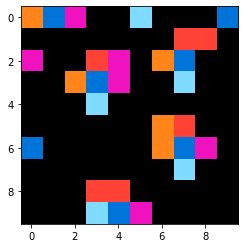

6200


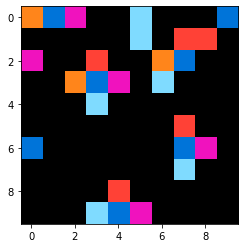

6300


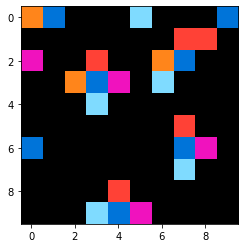

6400


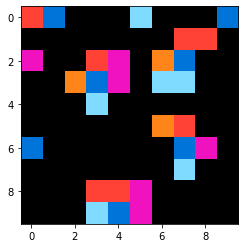

6500


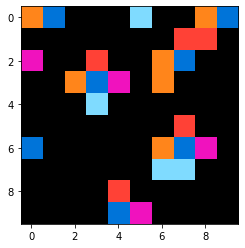

6600


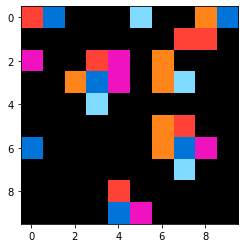

6700


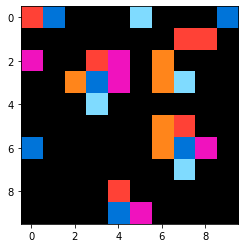

6800


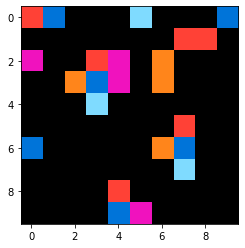

6900


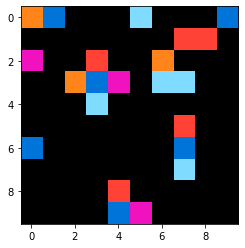

7000


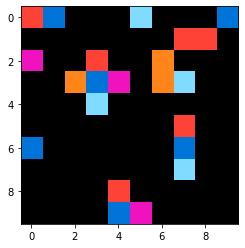

7100


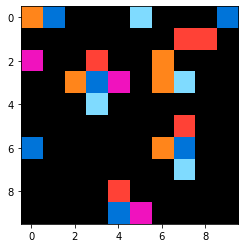

7200


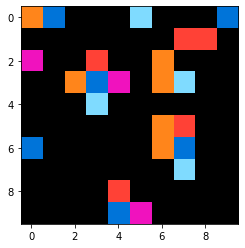

7300


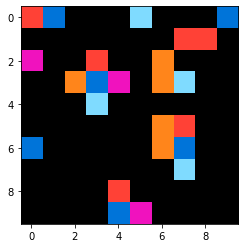

7400


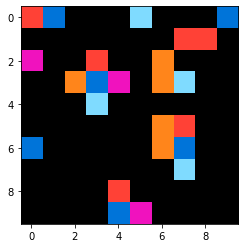

7500


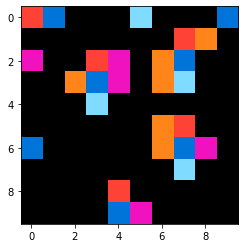

7600


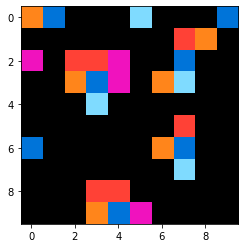

7700


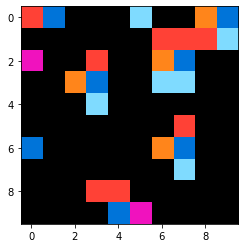

7800


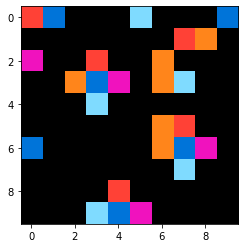

7900


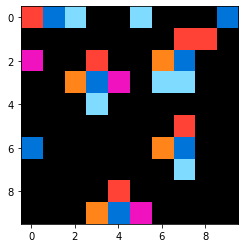

8000


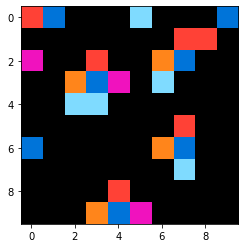

8100


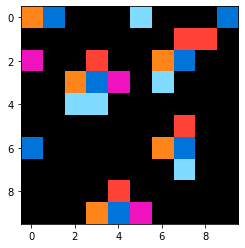

8200


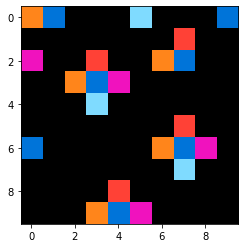

8300


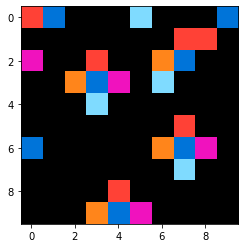

8400


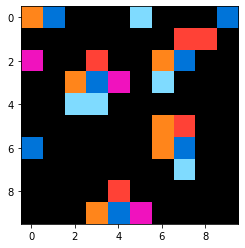

8500


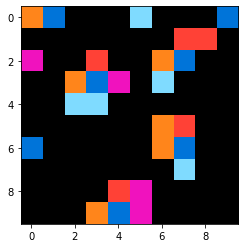

8600


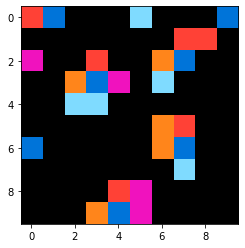

8700


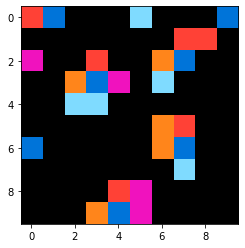

8800


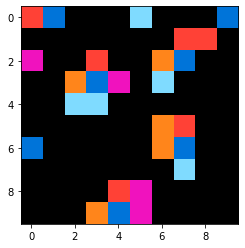

8900


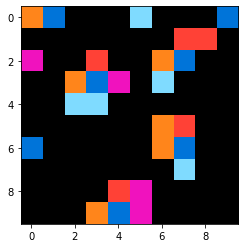

9000


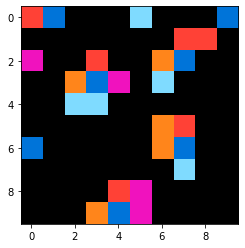

9100


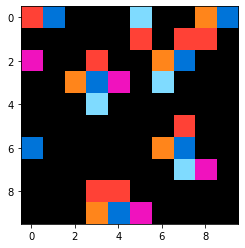

9200


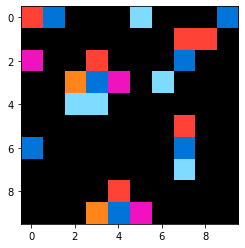

9300


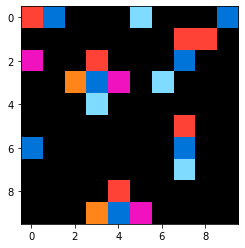

9400


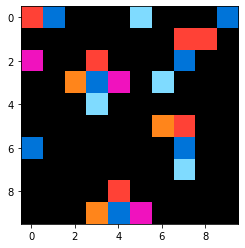

9500


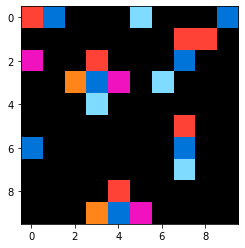

9600


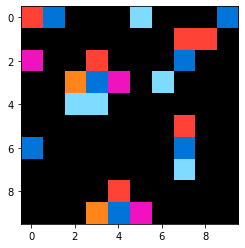

9700


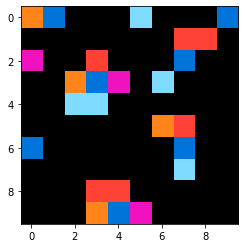

9800


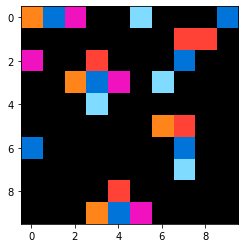

9900


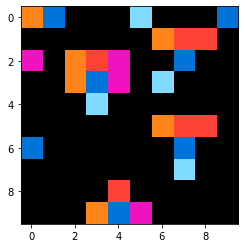

10000


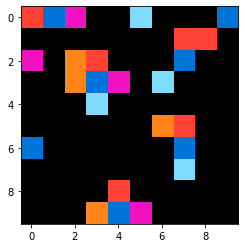

10100


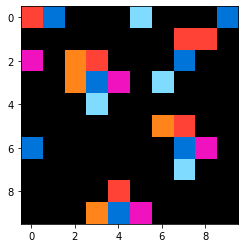

10200


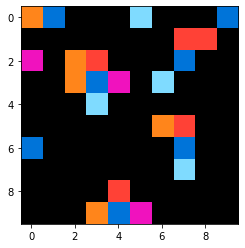

10300


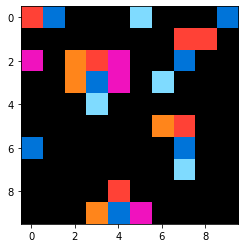

10400


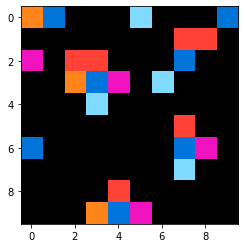

10500


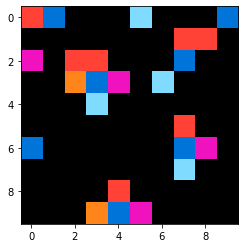

10600


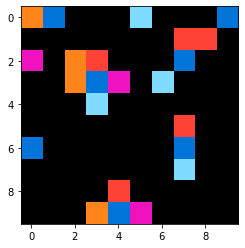

10700


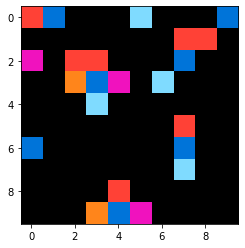

10800


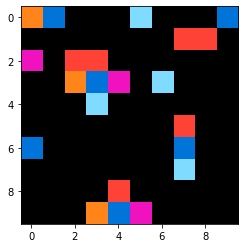

10900


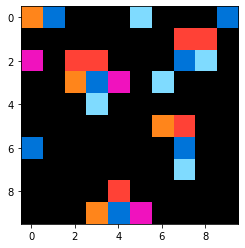

11000


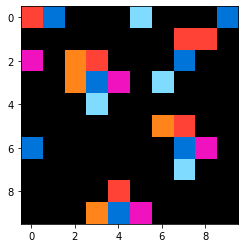

11100


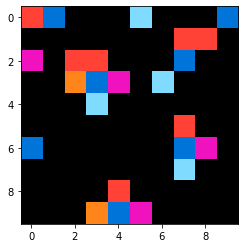

11200


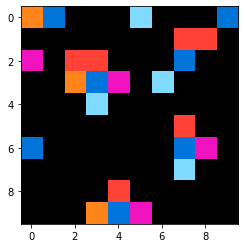

11300


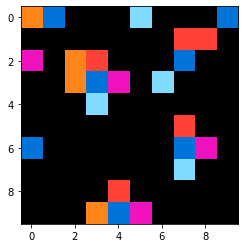

11400


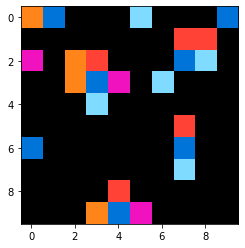

11500


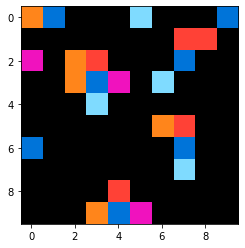

11600


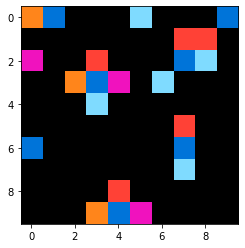

11700


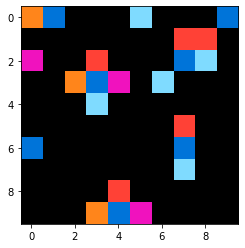

11800


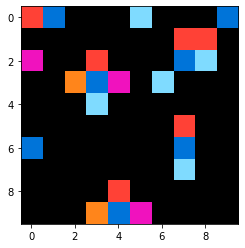

11900


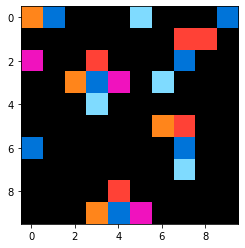

12000


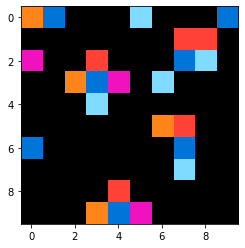

12100


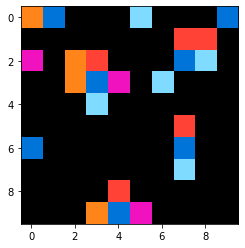

12200


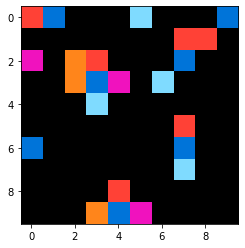

12300


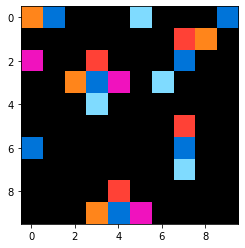

12400


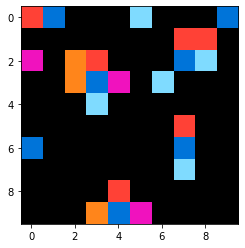

12500


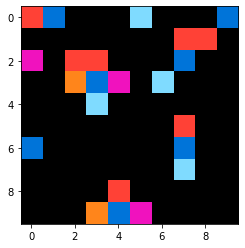

12600


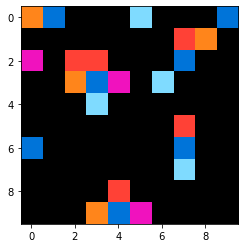

12700


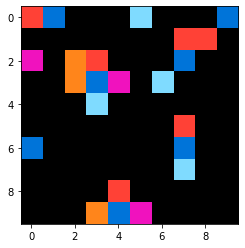

12800


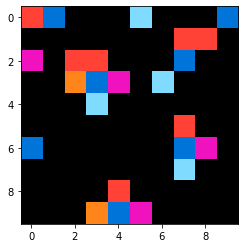

12900


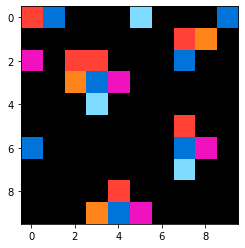

13000


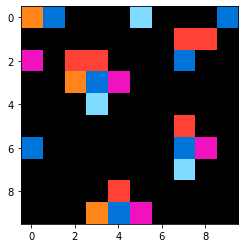

13100


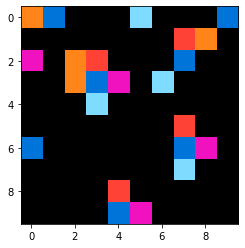

13200


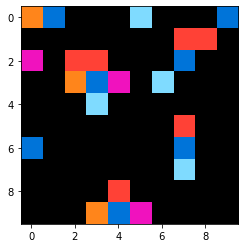

13300


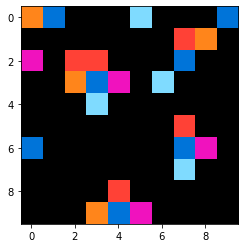

13400


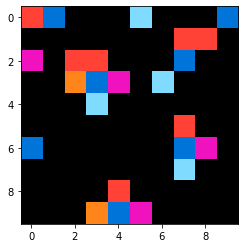

13500


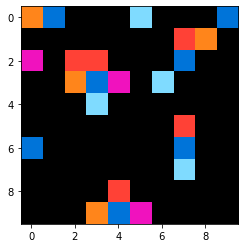

13600


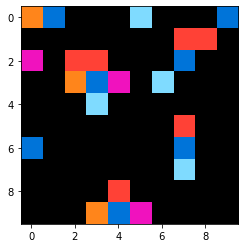

13700


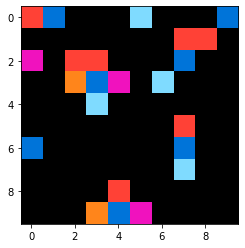

13800


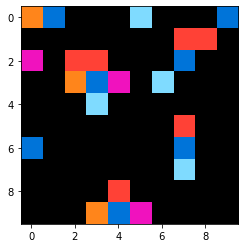

13900


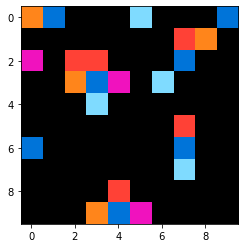

14000


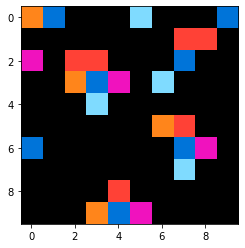

14100


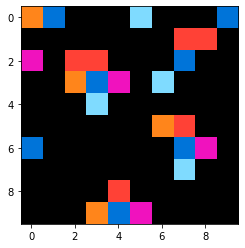

14200


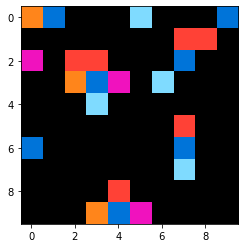

14300


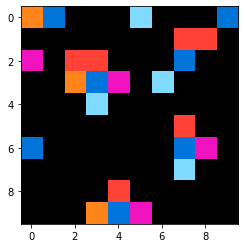

14400


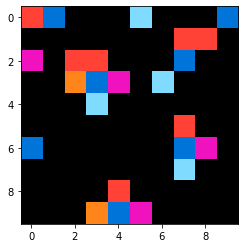

14500


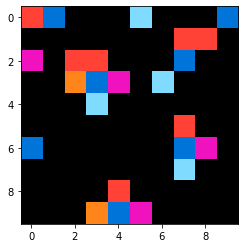

14600


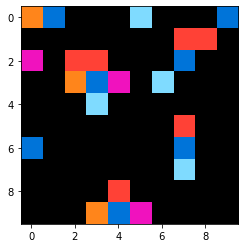

14700


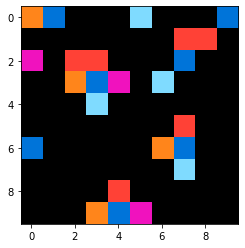

14800


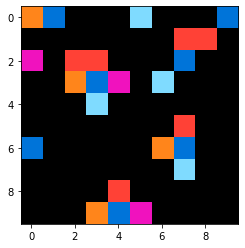

14900


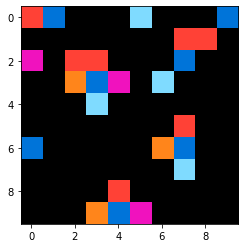

15000


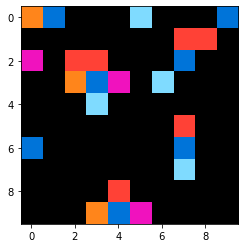

15100


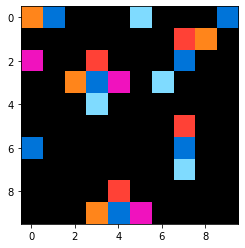

15200


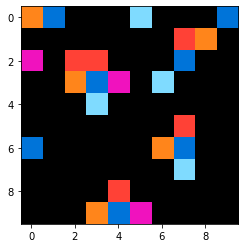

15300


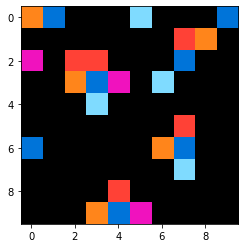

15400


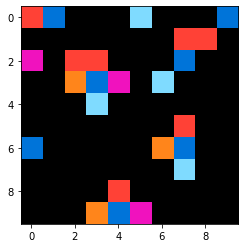

15500


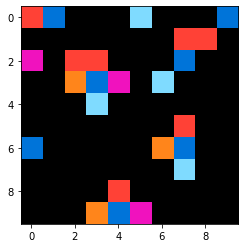

15600


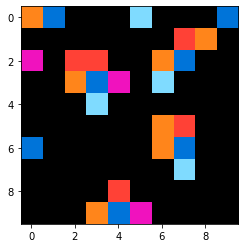

15700


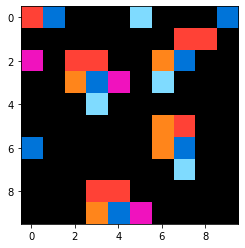

15800


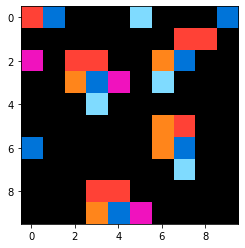

15900


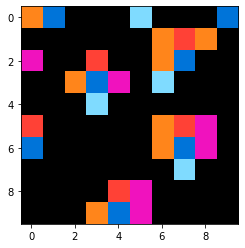

16000


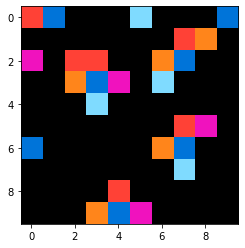

16100


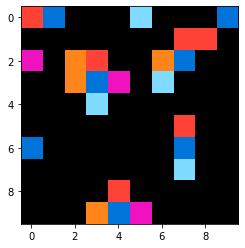

16200


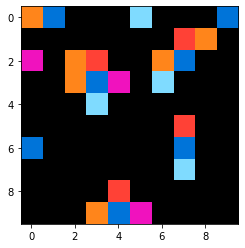

16300


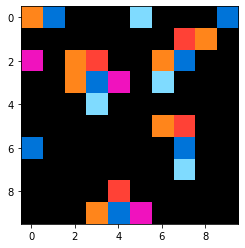

16400


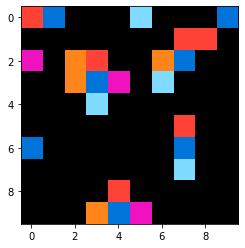

16500


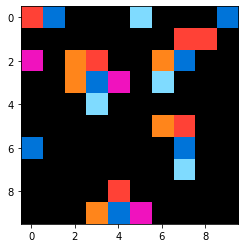

16600


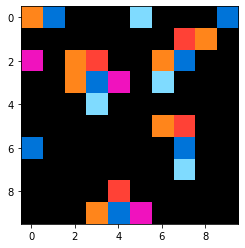

16700


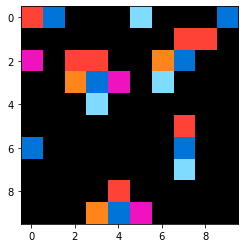

16800


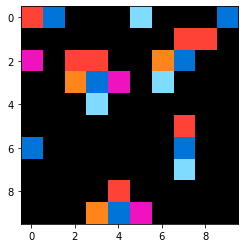

16900


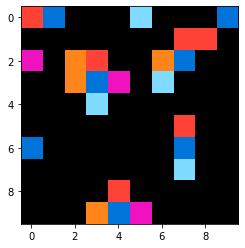

17000


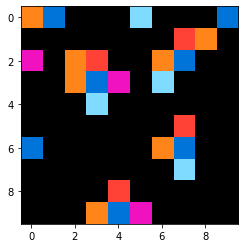

17100


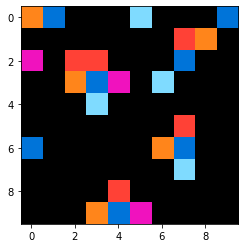

17200


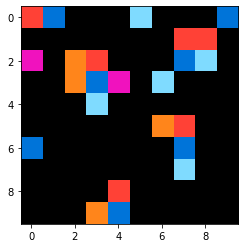

17300


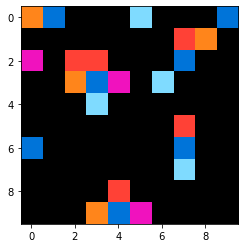

17400


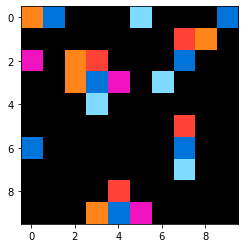

17500


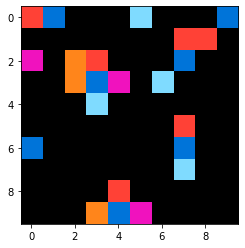

17600


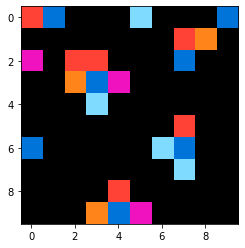

17700


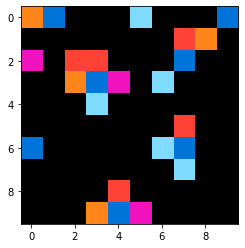

17800


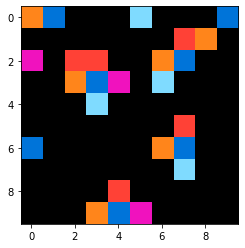

17900


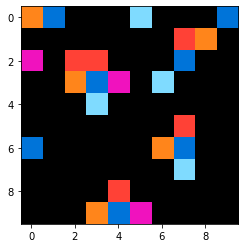

18000


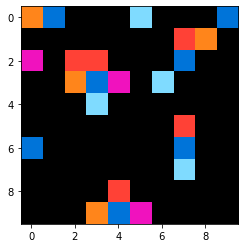

18100


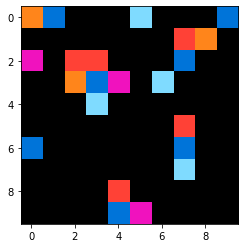

18200


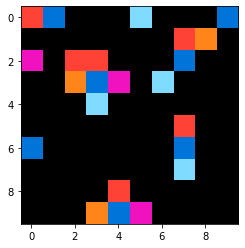

18300


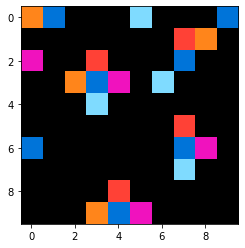

18400


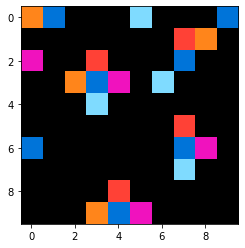

18500


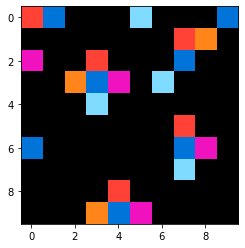

18600


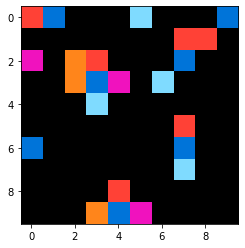

18700


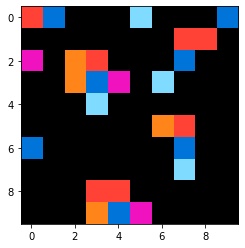

18800


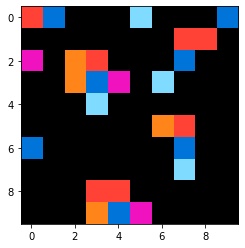

18900


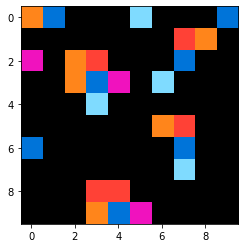

19000


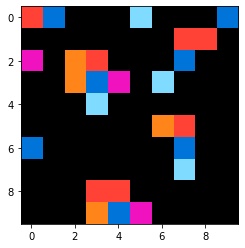

19100


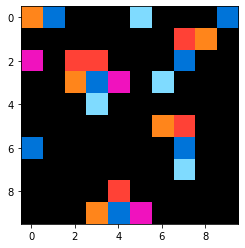

19200


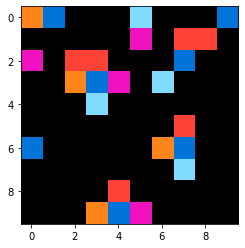

19300


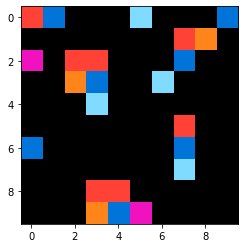

19400


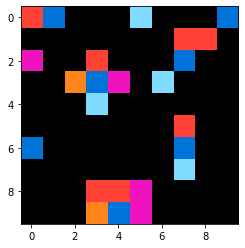

19500


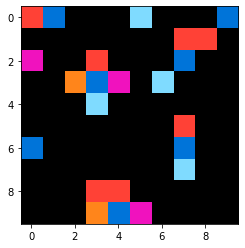

19600


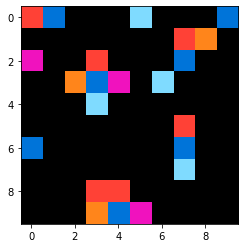

19700


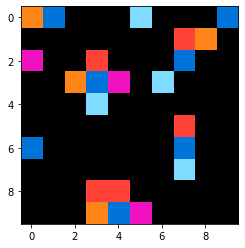

19800


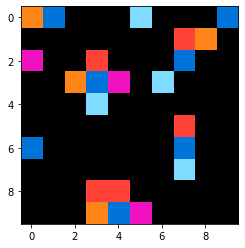

19900


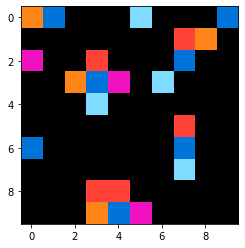

20000


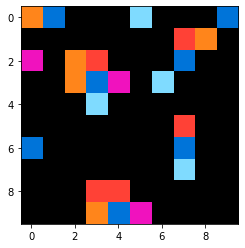

In [27]:
# test_img = np.array(train_tasks[task_id]['train'][0]['input'])
test_img = np.array(train_tasks[task_id]['test'][0]['input'])
test_img_rgb = get_img_rgb(test_img)

X_testing = np.array(
    [get_cnn_img(test_img_rgb, r, c) for r in range(len(test_img_rgb)) for c in range(len(test_img_rgb[0]))])
X_testing_color = test_img_rgb.reshape(-1, test_img_rgb.shape[-1])


for i in range(200):
    print((i+1)*100)
    model.fit([X_train, X_train_color], y_train, epochs=100, class_weight=tmp, verbose=False)
    y_pred = model.predict([X_testing, X_testing_color]).argmax(axis=1)
    img_pred = y_pred.copy()
    img_pred.shape = test_img.shape
    plot_image(img_pred)

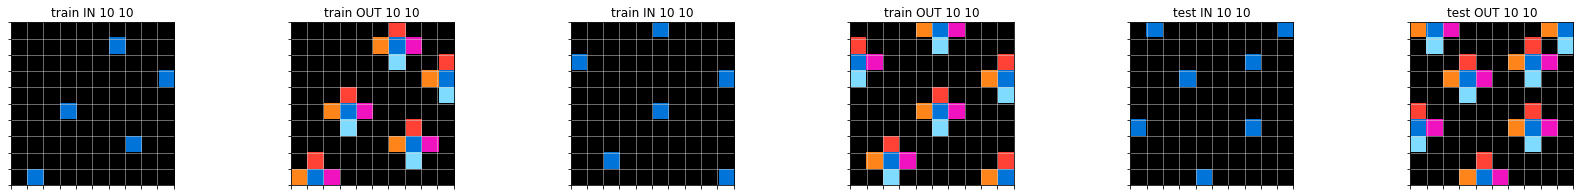

In [540]:
plot_task(train_tasks[task_id])

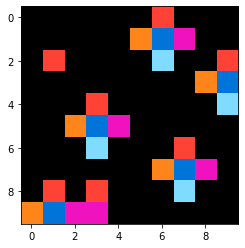

In [24]:
test_img = np.array(train_tasks[task_id]['train'][0]['input'])
# test_img = np.array(train_tasks[task_id]['test'][0]['input'])
test_img_rgb = get_img_rgb(test_img)

X_testing = np.array(
    [get_cnn_img(test_img_rgb, r, c) for r in range(len(test_img_rgb)) for c in range(len(test_img_rgb[0]))])
X_testing_color = test_img_rgb.reshape(-1, test_img_rgb.shape[-1])

y_pred = model.predict([X_testing, X_testing_color]).argmax(axis=1)
img_pred = y_pred.copy()
img_pred.shape = test_img.shape
plot_image(img_pred)

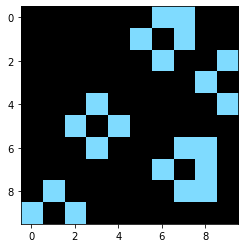

In [242]:
test_img = np.array(train_tasks[task_id]['train'][0]['input'])
test_img_rgb = get_img_rgb(test_img)

X_testing = np.array(
    [get_cnn_img(test_img_rgb, r, c) for r in range(len(test_img_rgb)) for c in range(len(test_img_rgb[0]))])

y_pred = model.predict(X_testing).argmax(axis=1)
img_pred = y_pred.copy()
img_pred.shape = test_img.shape
plot_image(img_pred)